In [41]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc as pm
from pymc.Matplot import plot as pmplot


sns.set()


In [42]:
dick = pd.read_pickle('country_data.pkl')

### 2020-04-14
# Germany has a negative dead_inc 2020-04-11, which makes poisson obs fail. 
# patching that number here

ger = dick['Germany']
ger.at['2020-04-11','dead_inc'] = 0
dick['Germany'] = ger
ger

confirmed    factor     inc  deceased  dead_factor  dead_inc  \
2020-01-24          0       NaN     NaN         0          NaN       NaN   
2020-01-25          0       NaN     0.0         0          NaN       0.0   
2020-01-26          0       NaN     0.0         0          NaN       0.0   
2020-01-27          1       NaN     1.0         0          NaN       0.0   
2020-01-28          4  4.000000     3.0         0          NaN       0.0   
...               ...       ...     ...       ...          ...       ...   
2020-04-22     150648  1.015894  2357.0      5279     1.048877     246.0   
2020-04-23     153129  1.016469  2481.0      5575     1.056071     296.0   
2020-04-24     154999  1.012212  1870.0      5760     1.033184     185.0   
2020-04-25     156513  1.009768  1514.0      5877     1.020312     117.0   
2020-04-26     157770  1.008031  1257.0      5976     1.016845      99.0   

            pct_dead  conf_over_dead  dead_conf_ratio  
2020-01-24       NaN             NaN              NaN  
2020-01-25       NaN             NaN              NaN  
2020-01-26       NaN             NaN              NaN  
2020-01-27  0.000000             NaN              NaN  
2020-01-28  0.000000             NaN              NaN  
...              ...             ...              ...  
2020-04-22  3.504195       28.537223         1.032467  
2020-04-23  3.640721       27.467085         1.038961  
2020-04-24  3.716153       26.909549         1.020719  
2020-04-25  3.754960       26.631445         1.010443  
2020-04-26  3.787792       26.400602         1.008744  

[94 rows x 9 columns]

In [43]:


def strip(x):
    return x.replace('\t','')

country_populations = pd.read_csv('world_pop.csv',
                                  sep=';',header=None,index_col=0,names=['population'],
                                 thousands=',',converters={0 : strip})

def process_country(country_name):
    
    country = dick[country_name]
    country_population = country_populations.loc[country_name,'population']
    country['conf_per_M'] = country['confirmed'] / (country_population / 1e6)
    country['dead_per_M'] = country['deceased'] / (country_population / 1e6)
    
    return country



In [44]:
r_prior = pm.rlognormal(0.27,1/0.05**2,100000)
f_prior = pm.rbeta(5,200,100000)

In [45]:
### ASSUMPTIONS ###
### 1) nr of dead inc is a function of nr of confirmed
### D = mortality rate (f) x confirmed total (C) x growth rate for confirmed (r)
### 2) D = f * C
### 3) D = C * r * f 

def inference(df,C,D,country_name):
    
    f_alpha = pm.Uniform('f_alpha',1,100)
    f_beta = pm.Uniform ('f_beta',50,500)
    
    #r_mu = pm.Uniform('r_mu',0.2,0.6) #high autocorrelation for Italy
    r_mu = pm.Uniform('r_mu',0.05,0.6)

    r_sigma = pm.Uniform('r_sigma',0,0.2)
    
    r = pm.Lognormal('r',r_mu, 1 / r_sigma ** 2)
    
    #r = pm.Lognormal('r',0.27,1/0.05**2)
    
    f = pm.Beta('f',f_alpha,f_beta)
    #m = pm.Uniform ('m',-2,2)

    @pm.deterministic()
    def prediction(C=C,r=r,f=f):
        return C * r * f 

    obs = pm.Poisson('obs',prediction, observed=True,value=D)

    model = pm.Model([f,r,prediction,obs])
    try:
        map_ = pm.MAP(model)
        map_.fit()
        
    except:
        print ('cant fit {}'.format(country_name))

    mcmc = pm.MCMC(model)

    mcmc.sample(200000,60000,4)
    
    r_mu_post = mcmc.trace('r_mu')[:]
    r_sigma_post = mcmc.trace('r_sigma')[:]
    r_post = mcmc.trace('r')[:]
    f_post = mcmc.trace('f')[:]
    f_alpha_post = mcmc.trace('f_alpha')[:]
    f_beta_post = mcmc.trace('f_beta')[:]
    
    
    pmplot(r_mu_post,'r_mu_post')
    pmplot(r_sigma_post,'r_sigma_post')
    pmplot(f_alpha_post,'f_alpha_post')
    pmplot(f_beta_post,'f_beta_post')
    pmplot(r_post,'r_post')
    pmplot(f_post,'f_post')

    prediction_post = mcmc.trace('prediction')[:,0]

    result = pd.DataFrame({'r_post':r_post,
                          'f_post':f_post,
                          'prediction_post':prediction_post})

    print ()
    print ('++++++++++++++ {} ++++++++++++++++'.format(country_name))
    print (result.describe())
    print()
    
    plt.figure(figsize=(18,12))
    plt.hist(r_prior,color='r',label='r prior',alpha=0.5,histtype='stepfilled',density=True)
    plt.hist(result.r_post,color='g',label='r posterior',alpha=0.7,histtype='stepfilled',density=True)
    plt.legend(loc='upper left')

    plt.figure(figsize=(18,12))
    plt.hist(f_prior,color='r',label='f prior',alpha=0.5,histtype='stepfilled',density=True)
    plt.hist(result.f_post,color='g',label='f posterior',alpha=0.7,histtype='stepfilled',density=True)
    
    plt.legend(loc='upper left')
    
    return result



In [46]:

def create_posterior_samples(result):
    N = 10000
    f_samples = np.random.choice(result.f_post,replace=True,size=N)
    r_samples = np.random.choice(result.r_post,replace=True,size=N)

    death_samples = np.array([pm.rpoisson(C[i] * r_samples * f_samples,N) for i in range(len(C))])
    conf_samples = np.array([pm.rpoisson(C[i] * r_samples,N) for i in range(len(C))])

    death_sample_df = pd.DataFrame(death_samples,index=range(len(death_samples)))
    death_sample_df.index.name='day'
    death_sample_df.columns.name='sample_nr'
    
    conf_sample_df = pd.DataFrame(conf_samples,index=range(len(conf_samples)))
    conf_sample_df.index.name='day'
    conf_sample_df.columns.name='sample_nr'
    
    
    return death_sample_df,conf_sample_df

In [47]:

def plot(result,df,sample_df,country_name,param='dead_inc',title_patch='deaths per day'):
    
    if title_patch == 'deaths per day':
        col = 5 # dead_inc
    else:
        col = 0 # confirmed
    
    samples_89 = np.percentile(sample_df.iloc[-1,:],[5.5,94.5])
    samples_daily_mean = sample_df.mean(axis=1)
    
    plt.figure(figsize=(18,12))
    title_postfix = r' posterior mean growth factor $\mu$: {:.2f} posterior mean mortality rate $\mu$: {:.4f}'.format(
    result.r_post.mean(),result.f_post.mean())
    
    title_postfix_2 = ' Last Day Sample 89% CI: {:.2f} , {:.2f} : Last Day Actual: {}'.format(
        int(samples_89[0]),int(samples_89[1]),df.iloc[-1,col])

    sns.violinplot(data=sample_df.T,inner='quartile',scale='count',palette=['orange'])
    
    plt.plot(range(len(df)),samples_daily_mean,color='crimson',ls='dashed',label='death samples daily mean ')

    plt.title('Bayesian Posterior Expected number of {} {}, after the day CONFIRMED hit {} \n'.format(
       title_patch, country_name,limit) + title_postfix + '\n' + title_postfix_2)

    plt.ylabel('Expected number of {}'.format(title_patch))
    plt.xlabel('Day after number of confirmed hit {}'.format(limit))
    plt.scatter(range(len(df)),df[param],color='crimson',label='actual data')
    plt.legend(loc='upper left')
    
    plt.savefig('{}_violinplot_{}.jpg'.format(country_name,param),format='jpg')


++++++++++++++++++++++ Sweden +++++++++++++++++++++++
            confirmed    factor    inc  deceased  dead_factor  dead_inc  \
2020-04-22      16004  1.044511  682.0      1937     1.097450     172.0   
2020-04-23      16755  1.046926  751.0      2021     1.043366      84.0   
2020-04-24      17567  1.048463  812.0      2152     1.064819     131.0   
2020-04-25      18177  1.034724  610.0      2192     1.018587      40.0   
2020-04-26      18640  1.025472  463.0      2194     1.000912       2.0   

             pct_dead  conf_over_dead  dead_conf_ratio   conf_per_M  \
2020-04-22  12.103224        8.262261         1.050683  1584.669775   
2020-04-23  12.062071        8.290450         0.996600  1659.031623   
2020-04-24  12.250242        8.163104         1.015600  1739.433513   
2020-04-25  12.059196        8.292427         0.984405  1799.833948   
2020-04-26  11.770386        8.495898         0.976051  1845.678869   

            dead_per_M  
2020-04-22  191.796136  
2020-04-23  200.1


++++++++++++++++++++++ Italy +++++++++++++++++++++++
            confirmed    factor     inc  deceased  dead_factor  dead_inc  \
2020-04-22     187327  1.018319  3370.0     25085     1.017730     437.0   
2020-04-23     189973  1.014125  2646.0     25549     1.018497     464.0   
2020-04-24     192994  1.015902  3021.0     25969     1.016439     420.0   
2020-04-25     195351  1.012213  2357.0     26384     1.015981     415.0   
2020-04-26     197675  1.011897  2324.0     26644     1.009854     260.0   

             pct_dead  conf_over_dead  dead_conf_ratio   conf_per_M  \
2020-04-22  13.391022        7.467690         0.999421  3098.268980   
2020-04-23  13.448753        7.435633         1.004311  3142.032131   
2020-04-24  13.455859        7.431707         1.000528  3191.997542   
2020-04-25  13.505946        7.404146         1.003722  3230.980818   
2020-04-26  13.478690        7.419119         0.997982  3269.418294   

            dead_per_M  
2020-04-22  414.889884  
2020-04-23  


++++++++++++++++++++++ Spain +++++++++++++++++++++++
            confirmed    factor     inc  deceased  dead_factor  dead_inc  \
2020-04-22     208389  1.020624  4211.0     21717     1.020440     435.0   
2020-04-23     213024  1.022242  4635.0     22157     1.020261     440.0   
2020-04-24     219764  1.031640  6740.0     22524     1.016564     367.0   
2020-04-25     223759  1.018179  3995.0     22902     1.016782     378.0   
2020-04-26     226629  1.012826  2870.0     23190     1.012575     288.0   

             pct_dead  conf_over_dead  dead_conf_ratio   conf_per_M  \
2020-04-22  10.421375        9.595662         0.999819  4457.063190   
2020-04-23  10.401175        9.614298         0.998062  4556.197444   
2020-04-24  10.249176        9.756882         0.985386  4700.353833   
2020-04-25  10.235119        9.770282         0.998628  4785.799646   
2020-04-26  10.232583        9.772704         0.999752  4847.183747   

            dead_per_M  
2020-04-22  464.487287  
2020-04-23  

/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ Spain ++++++++++++++++
             r_post        f_post  prediction_post
count  35000.000000  35000.000000     35000.000000
mean       1.328969      0.003449         4.796604
std        0.207563      0.000563         0.031631
min        0.786437      0.002261         4.654394
25%        1.188309      0.003071         4.775389
50%        1.318640      0.003389         4.796490
75%        1.455397      0.003762         4.817943
max        1.965544      0.005664         4.918206



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


sample_df()
sample_nr  0     1     2     3     4     5     6     7     8     9     ...  \
day                                                                    ...   
9            60    69    64    55    81    81    92    48    81    59  ...   
10          100    83    93    58    84   111   148    87   103    72  ...   
11           89   107    85    87   116   135   142    64   116    79  ...   
12          141   130   128   122   122   157   173   104   154    85  ...   
13          141   141   105   112   161   183   185   123   164    99  ...   
14          164   169   163   104   192   241   281   157   195   123  ...   
15          184   186   161   137   234   273   242   178   210   137  ...   
16          234   223   221   188   299   289   348   197   296   181  ...   
17          293   263   230   214   331   387   360   238   302   190  ...   
18          322   308   296   222   378   437   436   267   332   233  ...   
19          377   339   302   246   425   446   495 

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':



++++++++++++++++++++++ US +++++++++++++++++++++++
            confirmed    factor      inc  deceased  dead_factor  dead_inc  \
2020-04-22     840351  1.035087  28486.0     46622     1.049005    2178.0   
2020-04-23     869170  1.034294  28819.0     49954     1.071468    3332.0   
2020-04-24     905358  1.041635  36188.0     51949     1.039937    1995.0   
2020-04-25     938154  1.036224  32796.0     53755     1.034765    1806.0   
2020-04-26     965785  1.029453  27631.0     54881     1.020947    1126.0   

            pct_dead  conf_over_dead  dead_conf_ratio   conf_per_M  dead_per_M  
2020-04-22  5.547920       18.024774         1.013447  2538.804440  140.850836  
2020-04-23  5.747322       17.399407         1.035942  2625.870208  150.917220  
2020-04-24  5.737951       17.427823         0.998370  2735.198637  156.944362  
2020-04-25  5.729870       17.452404         0.998592  2834.279415  162.400512  
2020-04-26  5.682528       17.597803         0.991738  2917.756088  165.802297  


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ US ++++++++++++++++
             r_post        f_post  prediction_post
count  35000.000000  35000.000000     35000.000000
mean       1.465979      0.002330         4.260679
std        0.236046      0.000387         0.018191
min        0.965616      0.001594         4.187045
25%        1.271600      0.002021         4.248345
50%        1.470026      0.002264         4.260701
75%        1.645385      0.002615         4.272895
max        2.090937      0.003456         4.334921



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


sample_df()
sample_nr  0     1     2     3     4     5     6     7     8     9     ...  \
day                                                                    ...   
7            20    27    24    44    28    23    20    39    11    22  ...   
8            27    42    32    73    38    31    31    56    30    43  ...   
9            54    78    58    87    39    49    47    92    50    67  ...   
10           74   112    58   119    58    73    63   138    62    86  ...   
11           91   102    91   159    77    94    81   161    91   106  ...   
12          124   195   142   202   109   127   104   218    94   154  ...   
13          176   197   156   247   125   147   132   296   120   152  ...   
14          205   262   174   323   182   185   158   282   175   218  ...   
15          240   337   217   400   237   247   206   406   160   263  ...   
16          331   392   267   492   290   246   242   512   234   307  ...   
17          378   477   355   613   354   301   307 

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':



++++++++++++++++++++++ United Kingdom +++++++++++++++++++++++
            confirmed    factor     inc  deceased  dead_factor  dead_inc  \
2020-04-22     134638  1.034308  4466.0     18151     1.044482     773.0   
2020-04-23     139246  1.034225  4608.0     18791     1.035260     640.0   
2020-04-24     144640  1.038737  5394.0     19567     1.041296     776.0   
2020-04-25     149569  1.034078  4929.0     20381     1.041601     814.0   
2020-04-26     154037  1.029873  4468.0     20794     1.020264     413.0   

             pct_dead  conf_over_dead  dead_conf_ratio   conf_per_M  \
2020-04-22  13.481335        7.417663         1.009836  1983.295203   
2020-04-23  13.494822        7.410250         1.001000  2051.173695   
2020-04-24  13.528070        7.392038         1.002464  2130.630418   
2020-04-25  13.626487        7.338649         1.007275  2203.237424   
2020-04-26  13.499354        7.407762         0.990670  2269.053635   

            dead_per_M  
2020-04-22  267.374673  
202

/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ United Kingdom ++++++++++++++++
             r_post        f_post  prediction_post
count  35000.000000  35000.000000     35000.000000
mean       1.388472      0.006083         9.349880
std        0.248287      0.001123         0.065306
min        0.843965      0.003743         9.083031
25%        1.166984      0.005199         9.305287
50%        1.403280      0.005822         9.349611
75%        1.570464      0.007005         9.394466
max        2.183433      0.009766         9.604936



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


sample_df()
sample_nr  0     1     2     3     4     5     6     7     8     9     ...  \
day                                                                    ...   
4            24    22    13    22    22    32    21    37    21    12  ...   
5            23    17    12    18     9    50    28    31    31    18  ...   
6            28    39    21    30    25    54    48    48    25    19  ...   
7            50    53    32    31    30    86    47    81    47    30  ...   
8            60    50    27    31    51    90    49    54    48    34  ...   
9            48    44    44    45    40    95    52    81    66    36  ...   
10           61    77    41    67    50   124    71   112    91    50  ...   
11           78    85    50    63    65   137    76   111    90    59  ...   
12           93   102    64    89    85   204   118   129   115    80  ...   
13          141   136    85   118   107   233   131   175   159    87  ...   
14          135   159   103   116   106   251   155 

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':



++++++++++++++++++++++ Korea, South +++++++++++++++++++++++
            confirmed    factor   inc  deceased  dead_factor  dead_inc  \
2020-04-22      10694  1.001030  11.0       238     1.004219       1.0   
2020-04-23      10708  1.001309  14.0       240     1.008403       2.0   
2020-04-24      10718  1.000934  10.0       240     1.000000       0.0   
2020-04-25      10728  1.000933  10.0       242     1.008333       2.0   
2020-04-26      10738  1.000932  10.0       243     1.004132       1.0   

            pct_dead  conf_over_dead  dead_conf_ratio  conf_per_M  dead_per_M  
2020-04-22  2.225547       44.932773         1.003186  208.585332    4.642165  
2020-04-23  2.241315       44.616667         1.007085  208.858401    4.681174  
2020-04-24  2.239224       44.658333         0.999067  209.053450    4.681174  
2020-04-25  2.255779       44.330579         1.007393  209.248499    4.720184  
2020-04-26  2.262991       44.189300         1.003197  209.443548    4.739689  
 [------------

/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ Korea, South ++++++++++++++++
             r_post        f_post  prediction_post
count  35000.000000  35000.000000     35000.000000
mean       1.347377      0.000344         0.562024
std        0.266013      0.000072         0.036644
min        0.578793      0.000147         0.427248
25%        1.146428      0.000290         0.537054
50%        1.314421      0.000337         0.561281
75%        1.527799      0.000390         0.586288
max        3.059291      0.000809         0.723848



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


sample_df()
sample_nr  0     1     2     3     4     5     6     7     8     9     ...  \
day                                                                    ...   
21            5     6     9     3     4     2     4     4     4     3  ...   
22            4     9     2     5     3     3     4     4     2     8  ...   
23            3     6     3     2     3     8     4     3     2     4  ...   
24            5     3     2     7     7     2     5     4     8    10  ...   
25            4     9     4     6     4     3     4     7     5     6  ...   
26            5     8     8     9     4     1     7     3     1     6  ...   
27            7     5     5     4     4     3     5     4     1     1  ...   
28            3     5     4     8     1     6     2     5     1     6  ...   
29            7    10     3     5     3     2     2     3     2     7  ...   
30            7     7     7    10     9     7     3     4     0     4  ...   
31            7    13     2     2     3     4     4 

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':



++++++++++++++++++++++ Netherlands +++++++++++++++++++++++
            confirmed    factor    inc  deceased  dead_factor  dead_inc  \
2020-04-22      35032  1.020835  715.0      4068     1.035378     139.0   
2020-04-23      35921  1.025377  889.0      4192     1.030482     124.0   
2020-04-24      36729  1.022494  808.0      4304     1.026718     112.0   
2020-04-25      37384  1.017833  655.0      4424     1.027881     120.0   
2020-04-26      38040  1.017548  656.0      4491     1.015145      67.0   

             pct_dead  conf_over_dead  dead_conf_ratio   conf_per_M  \
2020-04-22  11.612240        8.611603         1.014246  2044.485655   
2020-04-23  11.670054        8.568941         1.004979  2096.368155   
2020-04-24  11.718261        8.533690         1.004131  2143.523453   
2020-04-25  11.833940        8.450271         1.009872  2181.749592   
2020-04-26  11.805994        8.470274         0.997638  2220.034092   

            dead_per_M  
2020-04-22  237.410586  
2020-04-23  

/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ Netherlands ++++++++++++++++
             r_post        f_post  prediction_post
count  35000.000000  35000.000000     35000.000000
mean       1.335191      0.004394         6.455833
std        0.249916      0.000802         0.095985
min        0.741744      0.002444         6.093718
25%        1.146550      0.003791         6.390445
50%        1.299361      0.004366         6.455921
75%        1.496745      0.004946         6.520108
max        2.340814      0.007683         6.893620



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


sample_df()
sample_nr  0     1     2     3     4     5     6     7     8     9     ...  \
day                                                                    ...   
3            18    26    28     9     7    15    17    13     8    14  ...   
4            26    19    31    16     6     9    17     6    13     6  ...   
5            28    28    29    11    11    19    31    20    10    19  ...   
6            30    35    27     7     6    27    20    21    14    20  ...   
7            19    34    46    12    23    25    28    16    15    22  ...   
8            36    33    46    19    27    20    27    28    17    21  ...   
9            35    52    58    16    29    15    60    31    10    36  ...   
10           34    61    70    23    31    39    61    41    23    51  ...   
11           74    58    82    21    33    38    63    42    25    39  ...   
12           62    82    92    31    34    59    70    48    24    63  ...   
13           98    69   122    40    35    53    80 

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':



++++++++++++++++++++++ Canada +++++++++++++++++++++++
            confirmed    factor     inc  deceased  dead_factor  dead_inc  \
2020-04-22      41648  1.057029  2247.0      2075     1.087526     167.0   
2020-04-23      43285  1.039306  1637.0      2240     1.079518     165.0   
2020-04-24      44054  1.017766   769.0      2384     1.064286     144.0   
2020-04-25      45491  1.032619  1437.0      2547     1.068372     163.0   
2020-04-26      47145  1.036359  1654.0      2661     1.044759     114.0   

            pct_dead  conf_over_dead  dead_conf_ratio   conf_per_M  dead_per_M  
2020-04-22  4.982232       20.071325         1.028852  1103.487628   54.978314  
2020-04-23  5.175003       19.323661         1.038692  1146.860881   59.350084  
2020-04-24  5.411540       18.479027         1.045708  1167.235977   63.165446  
2020-04-25  5.598910       17.860620         1.034624  1205.310116   67.484225  
2020-04-26  5.644289       17.717024         1.008105  1249.133793   70.504720  
 [

/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ Canada ++++++++++++++++
             r_post        f_post  prediction_post
count  35000.000000  35000.000000     35000.000000
mean       1.377014      0.002589         4.414457
std        0.241696      0.000462         0.085167
min        0.730937      0.001524         4.073098
25%        1.186376      0.002225         4.356511
50%        1.356830      0.002547         4.413802
75%        1.551056      0.002916         4.471477
max        2.277607      0.004727         4.789261



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


sample_df()
sample_nr  0     1     2     3     4     5     6     7     8     9     ...  \
day                                                                    ...   
0             2     4     4     3     2     1     5     6     4     6  ...   
1             4     1     7     3     1     5     2     3     5     8  ...   
2             5     5     5     0     7     8    10     3    12     9  ...   
3             3    10     8     5     6     7     5     7    12    13  ...   
4             6     7     9    11     6    10    13     7    18    18  ...   
5            11     9     9    11    13    15     8    10     9    24  ...   
6             9    13    15    13    20    10    10    20    15    30  ...   
7            24    14    17    17    15    15    11    20    21    35  ...   
8            20    16    13    19    15    21    15    17    30    36  ...   
9            23    15    25    33    16    20    20    18    33    36  ...   
10           28    27    34    30    28    22     8 

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':



++++++++++++++++++++++ Germany +++++++++++++++++++++++
            confirmed    factor     inc  deceased  dead_factor  dead_inc  \
2020-04-22     150648  1.015894  2357.0      5279     1.048877     246.0   
2020-04-23     153129  1.016469  2481.0      5575     1.056071     296.0   
2020-04-24     154999  1.012212  1870.0      5760     1.033184     185.0   
2020-04-25     156513  1.009768  1514.0      5877     1.020312     117.0   
2020-04-26     157770  1.008031  1257.0      5976     1.016845      99.0   

            pct_dead  conf_over_dead  dead_conf_ratio   conf_per_M  dead_per_M  
2020-04-22  3.504195       28.537223         1.032467  1798.053379   63.007300  
2020-04-23  3.640721       27.467085         1.038961  1827.665258   66.540197  
2020-04-24  3.716153       26.909549         1.020719  1849.984571   68.748257  
2020-04-25  3.754960       26.631445         1.010443  1868.054859   70.144706  
2020-04-26  3.787792       26.400602         1.008744  1883.057734   71.326317  
 

/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ Germany ++++++++++++++++
             r_post        f_post  prediction_post
count  35000.000000  35000.000000     35000.000000
mean       1.329555      0.001206         1.608351
std        0.257096      0.000230         0.020627
min        0.701199      0.000644         1.534486
25%        1.131057      0.001031         1.594561
50%        1.282488      0.001205         1.608131
75%        1.500072      0.001366         1.622214
max        2.407425      0.002188         1.693928



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


sample_df()
sample_nr  0     1     2     3     4     5     6     7     8     9     ...  \
day                                                                    ...   
10           18    17    19    13    22    21    22    22    28    18  ...   
11           18    17    22    21    21    24    20    26    35    17  ...   
12           27    30    28    32    37    39    36    25    39    30  ...   
13           33    32    13    29    47    29    26    38    50    32  ...   
14           31    28    28    31    48    55    40    34    45    36  ...   
15           40    49    27    32    50    56    33    36    68    44  ...   
16           41    63    38    28    58    55    50    62    61    50  ...   
17           49    57    39    41    67    60    57    70    57    53  ...   
18           56    66    53    55    73    75    53    87   109    75  ...   
19           57    69    57    70    95    82    84   114   102    93  ...   
20           72    85    74    73    90   105   102 

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':



++++++++++++++++++++++ France +++++++++++++++++++++++
            confirmed    factor     inc  deceased  dead_factor  dead_inc  \
2020-04-22     155980  0.986167 -2188.0     21373     1.026117     544.0   
2020-04-23     158303  1.014893  2323.0     21889     1.024143     516.0   
2020-04-24     159952  1.010417  1649.0     22279     1.017817     390.0   
2020-04-25     161644  1.010578  1692.0     22648     1.016563     369.0   
2020-04-26     162220  1.003563   576.0     22890     1.010685     242.0   

             pct_dead  conf_over_dead  dead_conf_ratio   conf_per_M  \
2020-04-22  13.702398        7.297993         1.040511  2389.637046   
2020-04-23  13.827281        7.232080         1.009114  2425.225755   
2020-04-24  13.928554        7.179496         1.007324  2450.488683   
2020-04-25  14.011037        7.137231         1.005922  2476.410377   
2020-04-26  14.110467        7.086938         1.007097  2485.234784   

            dead_per_M  
2020-04-22  327.437573  
2020-04-23 

/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ France ++++++++++++++++
             r_post        f_post  prediction_post
count  35000.000000  35000.000000     35000.000000
mean       1.299474      0.005235         7.511117
std        0.225864      0.000864         0.050072
min        0.776852      0.003110         7.293868
25%        1.133195      0.004659         7.477514
50%        1.264681      0.005226         7.511328
75%        1.418207      0.005832         7.545036
max        2.141955      0.008504         7.715327



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


sample_df()
sample_nr  0     1     2     3     4     5     6     7     8     9     ...  \
day                                                                    ...   
10           41   127    94    47    54    53    72    86    48    55  ...   
11           56   147   124    67    58    73    70    83    61    56  ...   
12           53   192   123    71    65    83    94   131    82    52  ...   
13           86   202   114   101    87    92   120   126    73    70  ...   
14           75   194   153    86    82    96   131   137    80    93  ...   
15          110   260   187   128   119   130   118   193   105   108  ...   
16          136   274   206   133   109   143   161   183   121   105  ...   
17          100   311   244   170   140   165   180   247   139   143  ...   
18          115   394   270   163   158   169   213   261   166   171  ...   
19          162   418   335   233   162   197   252   307   197   188  ...   
20          169   442   378   286   188   248   284 

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':



++++++++++++++++++++++ Belgium +++++++++++++++++++++++
            confirmed    factor     inc  deceased  dead_factor  dead_inc  \
2020-04-22      41889  1.022781   933.0      6262     1.044015     264.0   
2020-04-23      42797  1.021676   908.0      6490     1.036410     228.0   
2020-04-24      44293  1.034956  1496.0      6679     1.029122     189.0   
2020-04-25      45325  1.023299  1032.0      6917     1.035634     238.0   
2020-04-26      46134  1.017849   809.0      7094     1.025589     177.0   

             pct_dead  conf_over_dead  dead_conf_ratio   conf_per_M  \
2020-04-22  14.949032        6.689396         1.020761  3614.353979   
2020-04-23  15.164614        6.594299         1.014421  3692.699926   
2020-04-24  15.079132        6.631681         0.994363  3821.780916   
2020-04-25  15.260894        6.552696         1.012054  3910.826090   
2020-04-26  15.376945        6.503242         1.007605  3980.629914   

            dead_per_M  
2020-04-22  540.310932  
2020-04-23

/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ Belgium ++++++++++++++++
             r_post        f_post  prediction_post
count  35000.000000  35000.000000     35000.000000
mean       1.362786      0.006053         8.444138
std        0.252725      0.001092         0.100704
min        0.739821      0.003041         8.049219
25%        1.166690      0.005221         8.375580
50%        1.335205      0.005974         8.443787
75%        1.526984      0.006839         8.511875
max        2.638373      0.010716         8.848839



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


sample_df()
sample_nr  0     1     2     3     4     5     6     7     8     9     ...  \
day                                                                    ...   
2            11     7    10     3    11     9     9    16    20    16  ...   
3             6    17    11     7    11    12    10    16    25    18  ...   
4             9    12     5     6    13     8    14    17    23    21  ...   
5            11    24    15     6    17    25    15    16    22    18  ...   
6            19    22    14    12    22    17    27    29    27    28  ...   
7            26    30    22    20    29    23    19    33    34    42  ...   
8            19    27    26    20    29    39    38    31    30    38  ...   
9            17    35    42    26    37    22    31    52    39    41  ...   
10           44    34    46    31    47    42    42    60    61    47  ...   
11           41    50    44    36    42    47    42    57    55    56  ...   
12           54    71    52    67    54    56    61 

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':



++++++++++++++++++++++ Austria +++++++++++++++++++++++
            confirmed    factor   inc  deceased  dead_factor  dead_inc  \
2020-04-22      14925  1.003496  52.0       510     1.038697      19.0   
2020-04-23      15002  1.005159  77.0       522     1.023529      12.0   
2020-04-24      15071  1.004599  69.0       530     1.015326       8.0   
2020-04-25      15148  1.005109  77.0       536     1.011321       6.0   
2020-04-26      15225  1.005083  77.0       542     1.011194       6.0   

            pct_dead  conf_over_dead  dead_conf_ratio   conf_per_M  dead_per_M  
2020-04-22  3.417085       29.264706         1.035078  1657.155280   56.626412  
2020-04-23  3.479536       28.739464         1.018276  1665.704758   57.958798  
2020-04-24  3.516688       28.435849         1.010677  1673.365978   58.847055  
2020-04-25  3.538421       28.261194         1.006180  1681.915456   59.513248  
2020-04-26  3.559934       28.090406         1.006080  1690.464934   60.179441  
 [-----------

/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ Austria ++++++++++++++++
             r_post        f_post  prediction_post
count  35000.000000  35000.000000     35000.000000
mean       1.331313      0.000965         1.262633
std        0.253953      0.000186         0.054363
min        0.660762      0.000444         1.039161
25%        1.140586      0.000825         1.225511
50%        1.294454      0.000957         1.261729
75%        1.498985      0.001088         1.298956
max        2.661666      0.001893         1.481899



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


sample_df()
sample_nr  0     1     2     3     4     5     6     7     8     9     ...  \
day                                                                    ...   
2             2     2     2     3     3     1     1     0     2     1  ...   
3             6     2     1     0     1     3     4     2     1     4  ...   
4            11     1     1     3     1     3     2     6     2     6  ...   
5             7     3     1     1     2     5     5     5     4     2  ...   
6             6     3     6     4     4     4     5     3     3     6  ...   
7            10     6     7     7     6     4     6     5     6     5  ...   
8            15     5     4     4     8     4     7     5     3     5  ...   
9            15     8     6     8     8     4     4     5     6     5  ...   
10           20     6     7     7     7     7     9     6     7     9  ...   
11           14     3    13     7     8     7    12    10     9    10  ...   
12           17     1    10     6     7     4    14 

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':



++++++++++++++++++++++ Denmark +++++++++++++++++++++++
            confirmed    factor    inc  deceased  dead_factor  dead_inc  \
2020-04-22       8108  1.027500  217.0       384     1.037838      14.0   
2020-04-23       8271  1.020104  163.0       394     1.026042      10.0   
2020-04-24       8408  1.016564  137.0       403     1.022843       9.0   
2020-04-25       8643  1.027950  235.0       418     1.037221      15.0   
2020-04-26       8773  1.015041  130.0       422     1.009569       4.0   

            pct_dead  conf_over_dead  dead_conf_ratio   conf_per_M  dead_per_M  
2020-04-22  4.736063       21.114583         1.010061  1399.813059   66.296030  
2020-04-23  4.763632       20.992386         1.005821  1427.954343   68.022490  
2020-04-24  4.793054       20.863524         1.006176  1451.606833   69.576303  
2020-04-25  4.836284       20.677033         1.009019  1492.178622   72.165991  
2020-04-26  4.810213       20.789100         0.994609  1514.622591   72.856575  
 [-----

/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ Denmark ++++++++++++++++
             r_post        f_post  prediction_post
count  35000.000000  35000.000000     35000.000000
mean       1.327670      0.001689         2.211768
std        0.262623      0.000341         0.108172
min        0.584261      0.000800         1.778062
25%        1.127246      0.001431         2.138293
50%        1.289238      0.001671         2.210206
75%        1.504728      0.001919         2.283415
max        2.741542      0.003744         2.682237



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


sample_df()
sample_nr  0     1     2     3     4     5     6     7     8     9     ...  \
day                                                                    ...   
1             0     7     4     0     4     2     1     1     5     2  ...   
2             2     3     2     4     1     1     5     2     3     3  ...   
3             3     3     3     3     2     4     2     2     1     4  ...   
4             4     4     2     1     3     3     3     3     5     6  ...   
5             2     6     0     2     4     1     3     3     0     3  ...   
6             2     6     3     2     4     7     2     1    13     3  ...   
7             2     4     4     4     2     1     4     5     5     4  ...   
8             6    13     2     1    10     5     7     4     3     5  ...   
9             3     6     3     4     2     3     4     7     5     6  ...   
10            4     5     4     2     2     7     5     7     7    10  ...   
11            6     9     4     2     4     6     2 

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':



++++++++++++++++++++++ Norway +++++++++++++++++++++++
            confirmed    factor    inc  deceased  dead_factor  dead_inc  \
2020-04-22       7338  1.020442  147.0       187     1.027473       5.0   
2020-04-23       7401  1.008585   63.0       194     1.037433       7.0   
2020-04-24       7463  1.008377   62.0       199     1.025773       5.0   
2020-04-25       7499  1.004824   36.0       201     1.010050       2.0   
2020-04-26       7527  1.003734   28.0       201     1.000000       0.0   

            pct_dead  conf_over_dead  dead_conf_ratio   conf_per_M  dead_per_M  
2020-04-22  2.548378       39.240642         1.006889  1353.564617   34.493947  
2020-04-23  2.621267       38.149485         1.028602  1365.185573   35.785164  
2020-04-24  2.666488       37.502513         1.017251  1376.622069   36.707462  
2020-04-25  2.680357       37.308458         1.005201  1383.262615   37.076382  
2020-04-26  2.670387       37.447761         0.996280  1388.427484   37.076382  
 [------

/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ Norway ++++++++++++++++
             r_post        f_post  prediction_post
count  35000.000000  35000.000000     35000.000000
mean       1.329186      0.000727         1.014146
std        0.262274      0.000150         0.071064
min        0.596329      0.000301         0.750926
25%        1.136024      0.000617         0.965530
50%        1.287635      0.000718         1.013069
75%        1.496479      0.000820         1.061177
max        3.097222      0.001703         1.312837

sample_df()
sample_nr  0     1     2     3     4     5     6     7     8     9     ...  \
day                                                                    ...   
4             1     2     2     0     1     4     2     1     1     2  ...   
5             1     1     2     1     3     2     2     1     2     3  ...   
6             4     1     0     1     5     4     2     3     1     2  ...   
7             2     2     4     0     3     2     3     2     1     2  ...   
8             1     

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0]


++++++++++++++++++++++ Finland +++++++++++++++++++++++
            confirmed    factor    inc  deceased  dead_factor  dead_inc  \
2020-04-22       4129  1.028650  115.0       149     1.056738       8.0   
2020-04-23       4284  1.037539  155.0       172     1.154362      23.0   
2020-04-24       4395  1.025910  111.0       177     1.029070       5.0   
2020-04-25       4475  1.018203   80.0       186     1.050847       9.0   
2020-04-26       4576  1.022570  101.0       190     1.021505       4.0   

            pct_dead  conf_over_dead  dead_conf_ratio  conf_per_M  dead_per_M  
2020-04-22  3.608622       27.711409         1.027306  745.210009   26.891812  
2020-04-23  4.014939       24.906977         1.112596  773.184712   31.042897  
2020-04-24  4.027304       24.830508         1.003080  793.218210   31.945307  
2020-04-25  4.156425       24.059140         1.032061  807.656767   33.569644  
2020-04-26  4.152098       24.084211         0.998959  825.885444   34.291572  


ZeroProbability: Stochastic obs's value is outside its support,
 or it forbids its parents' current values.

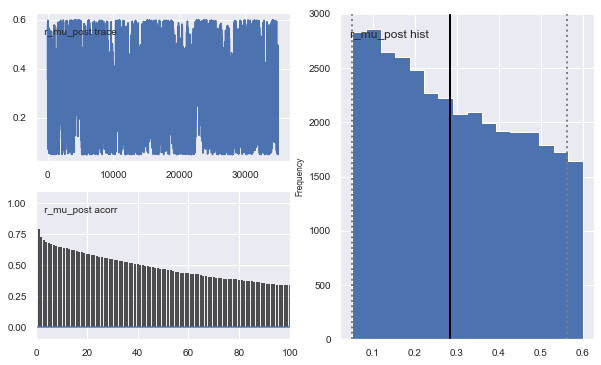

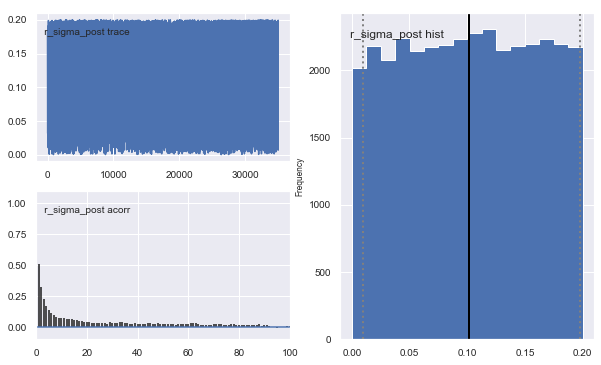

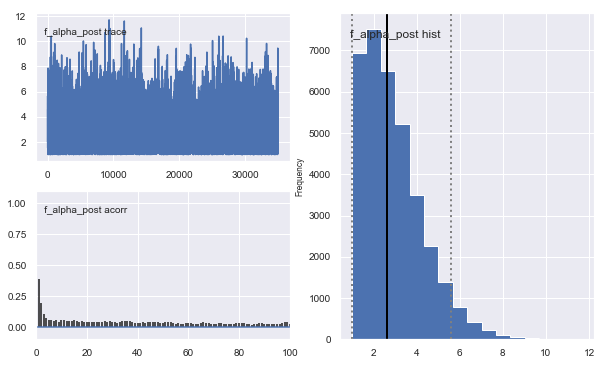

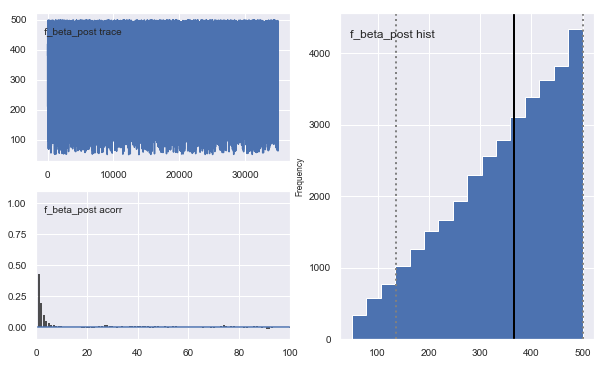

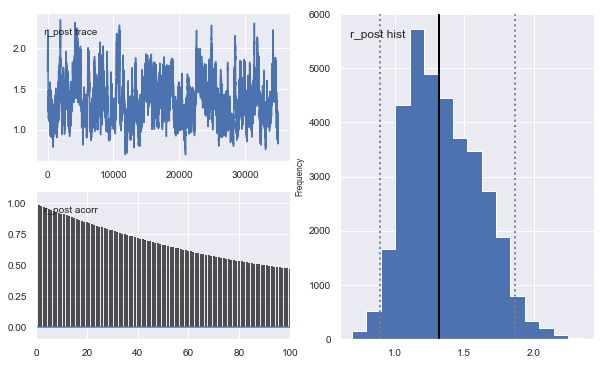

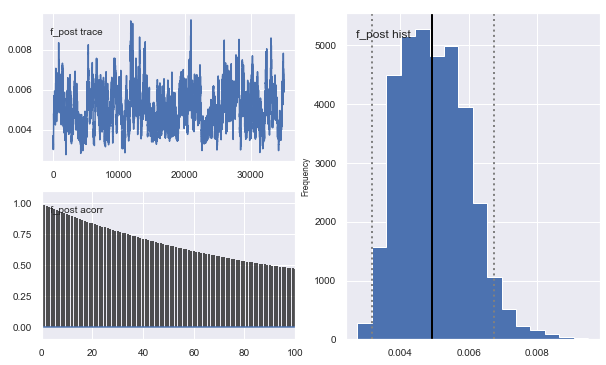

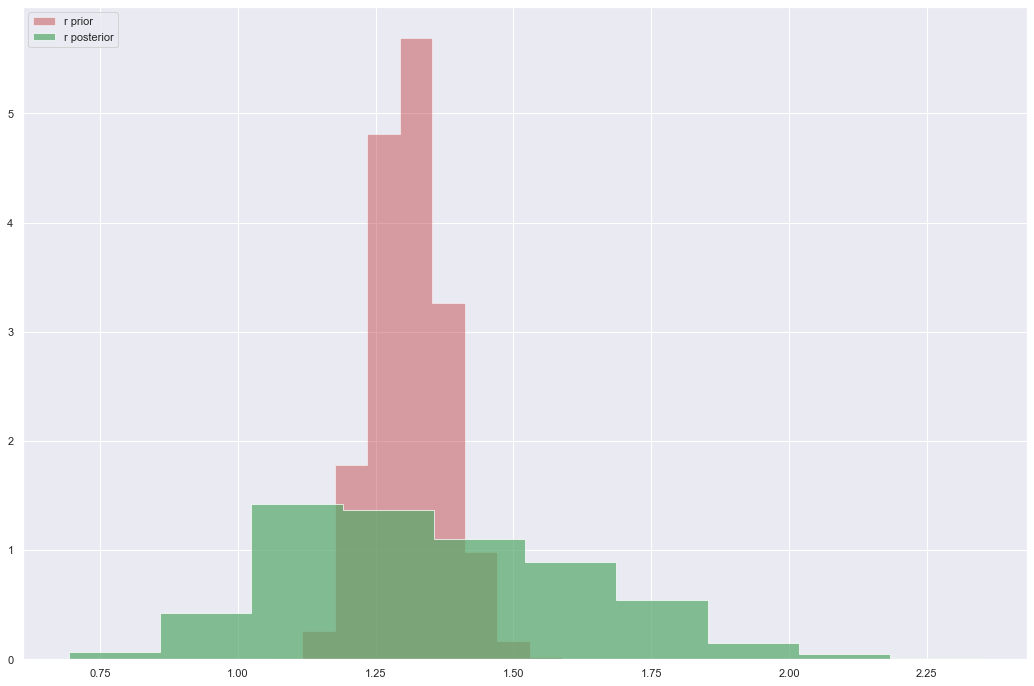

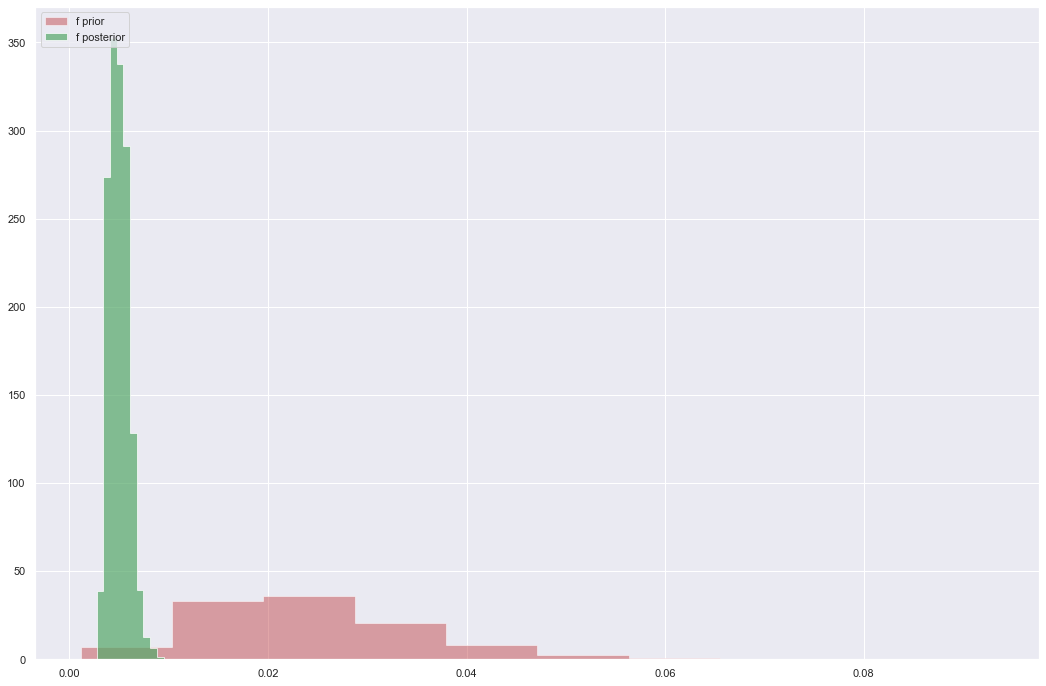

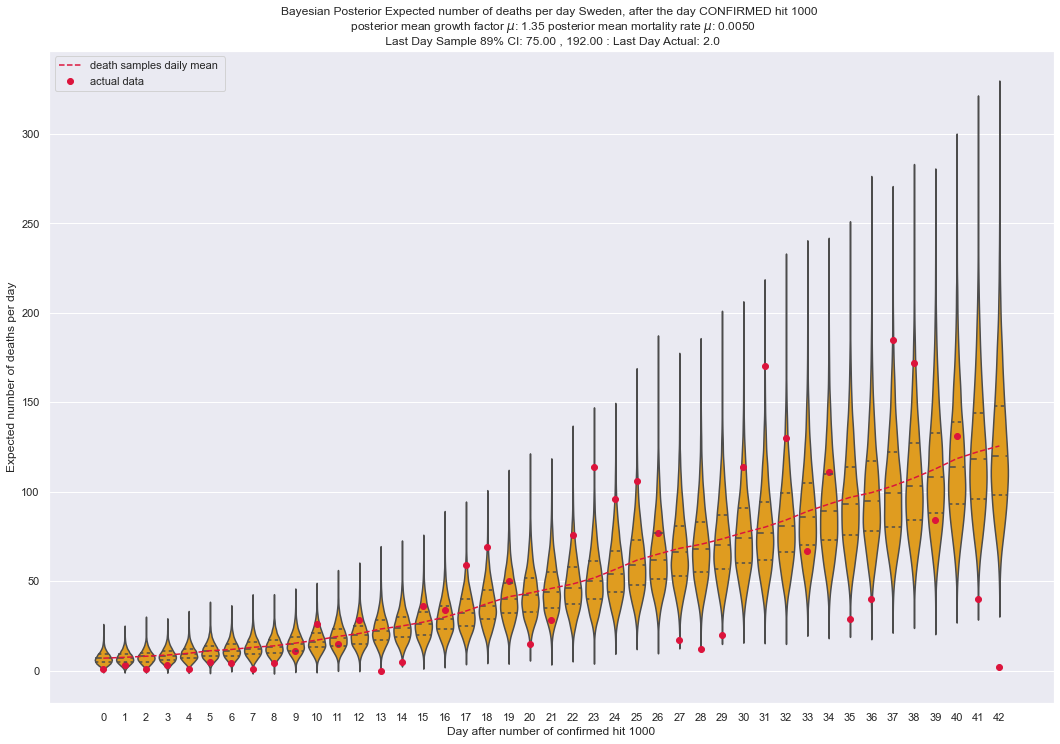

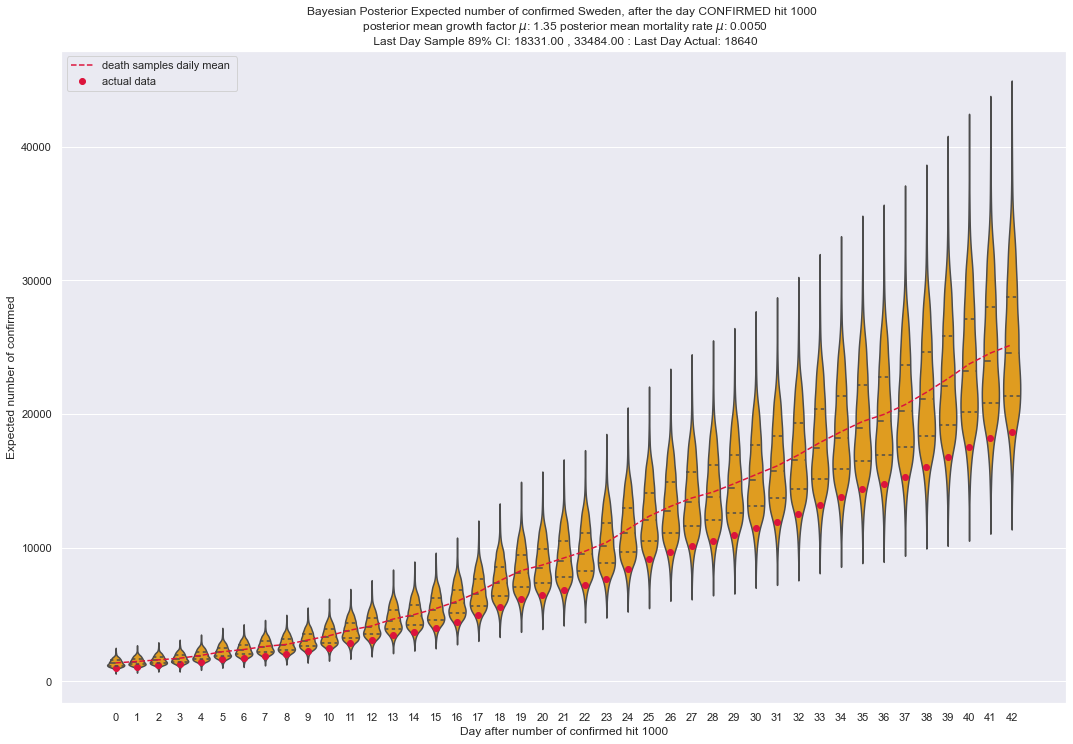

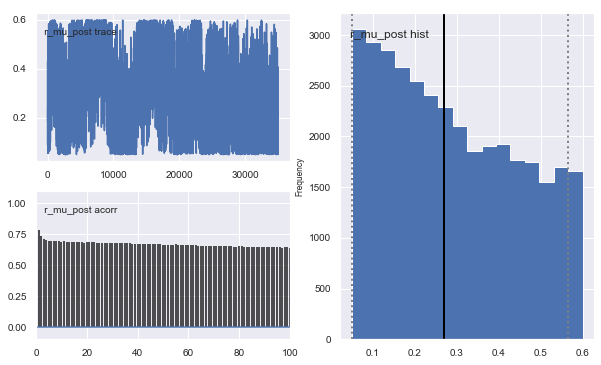

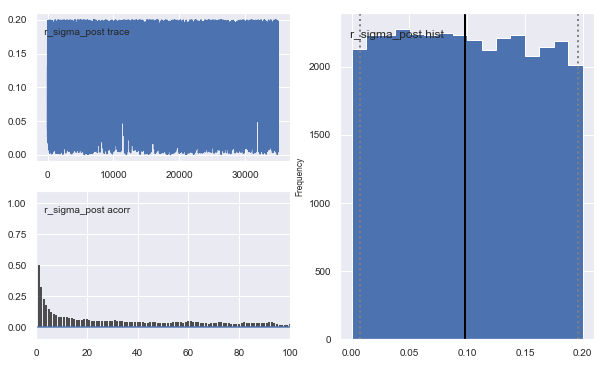

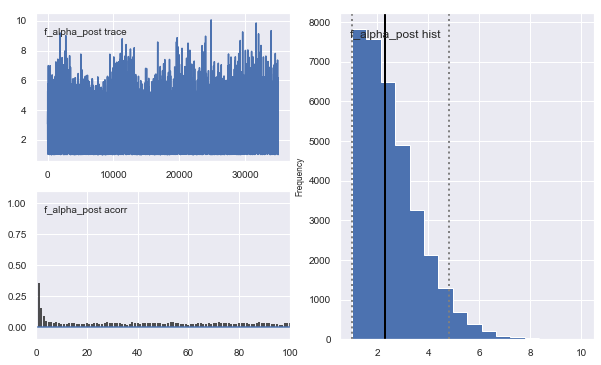

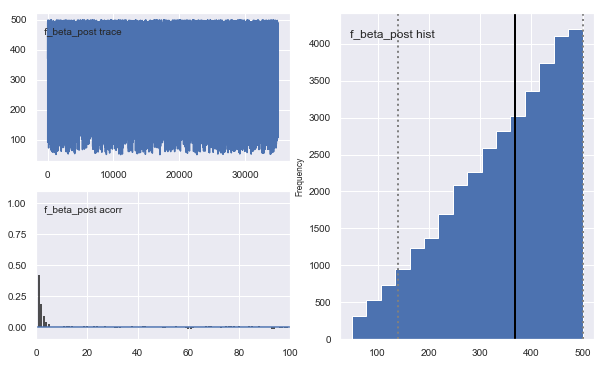

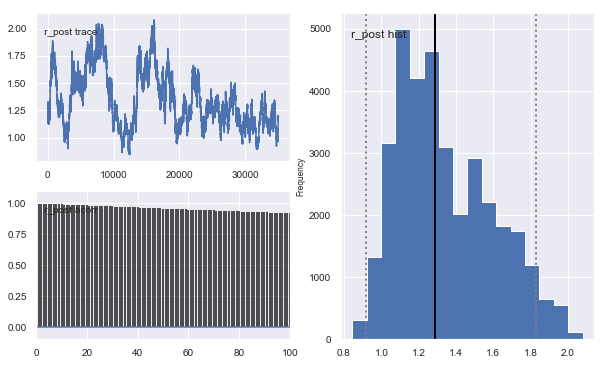

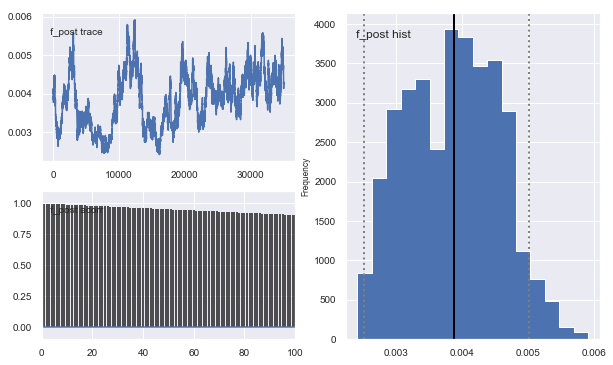

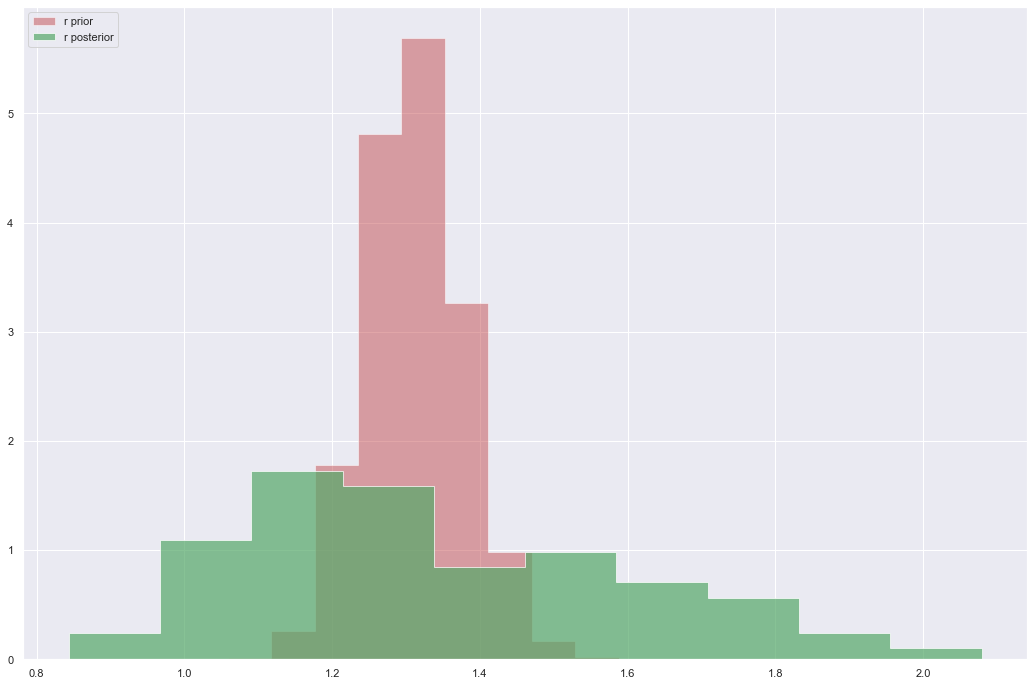

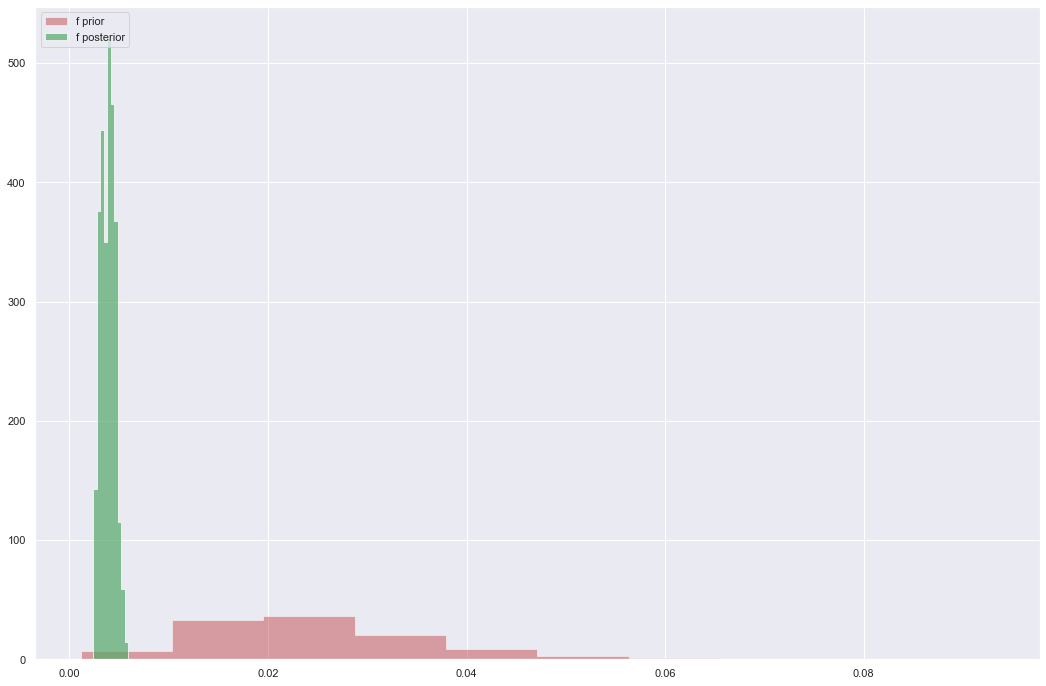

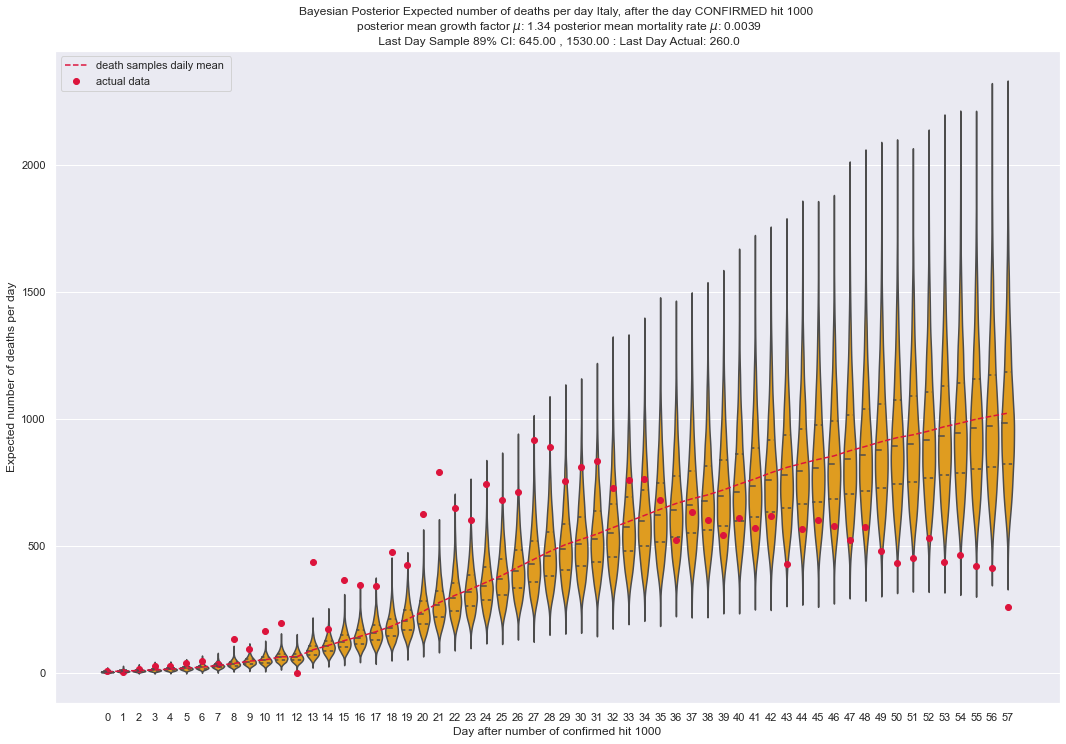

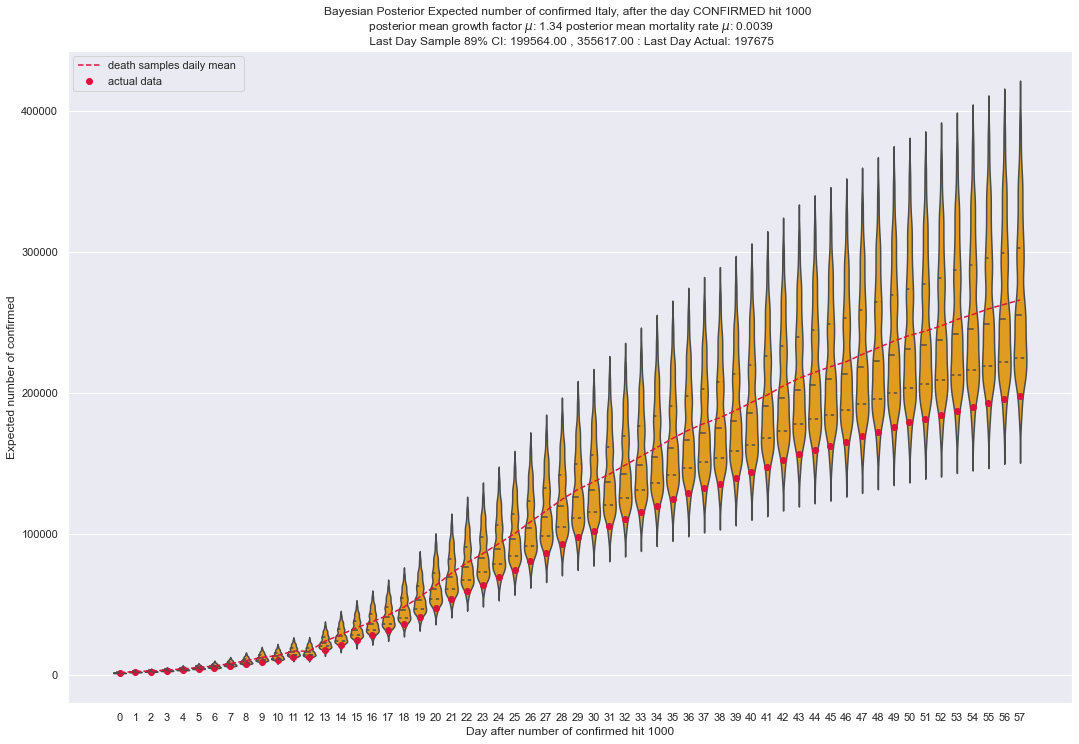

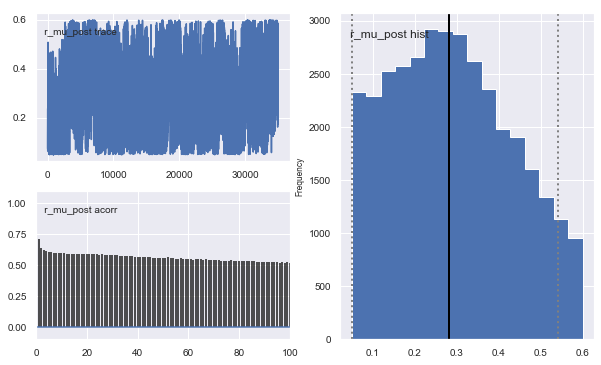

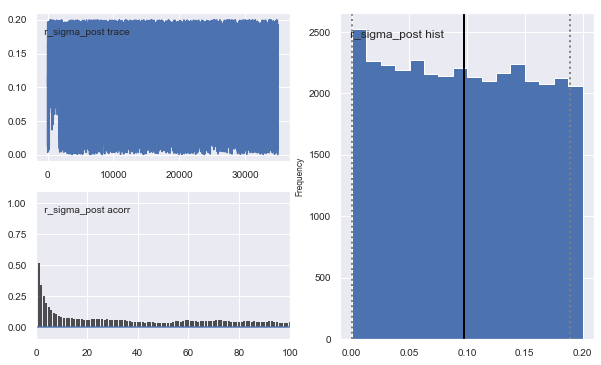

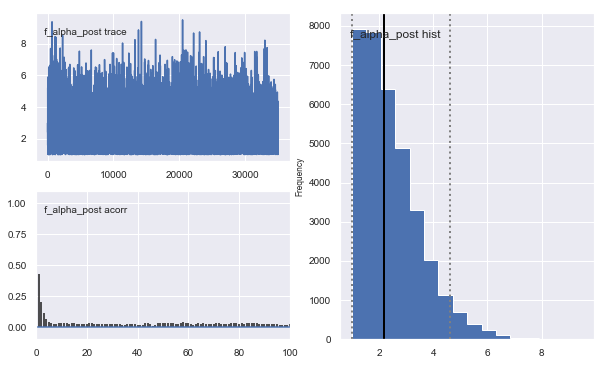

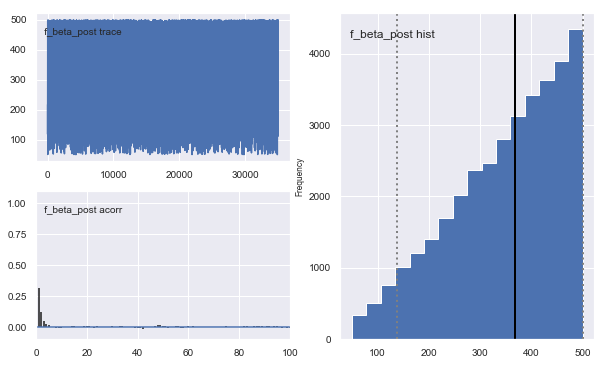

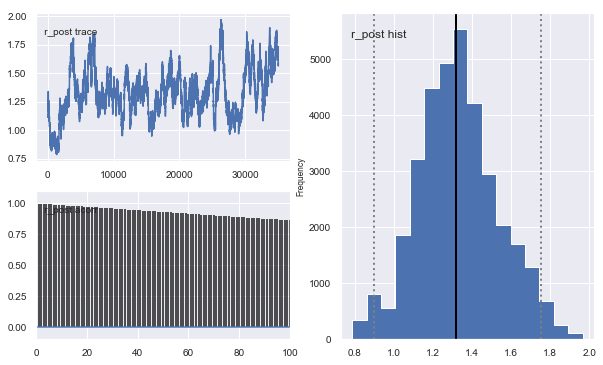

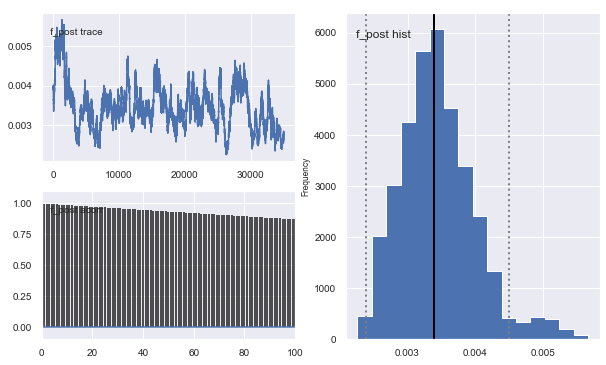

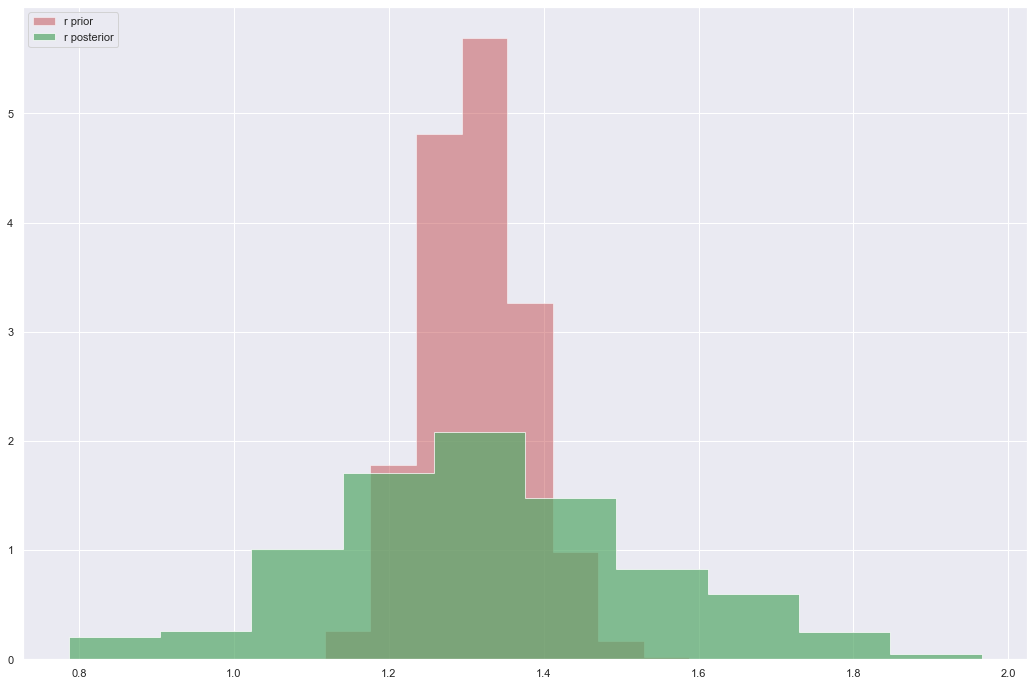

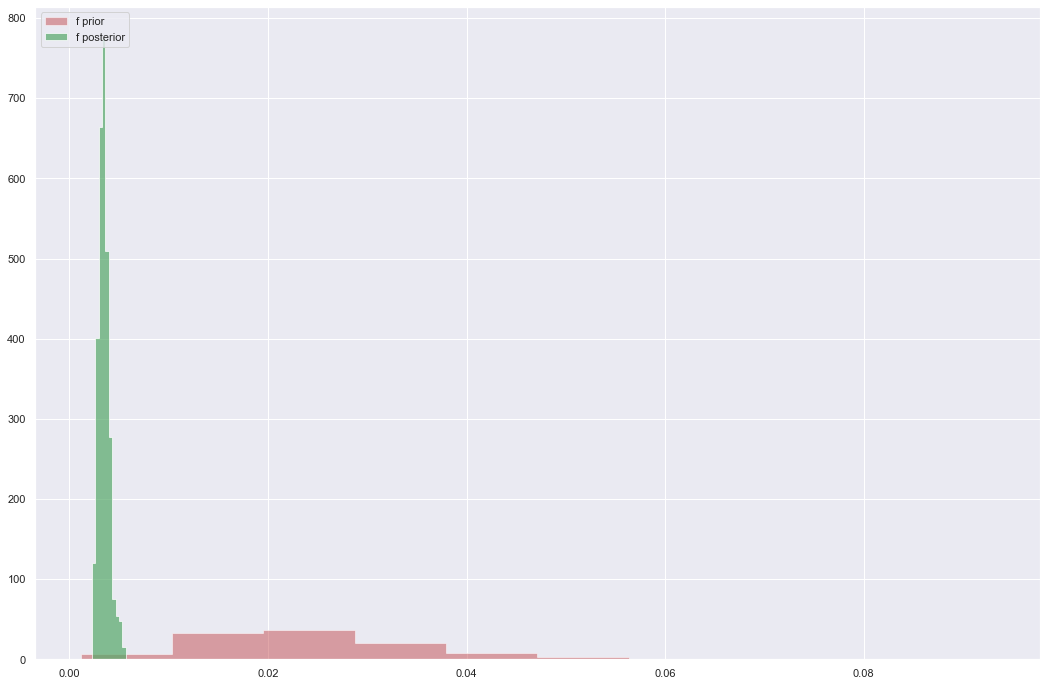

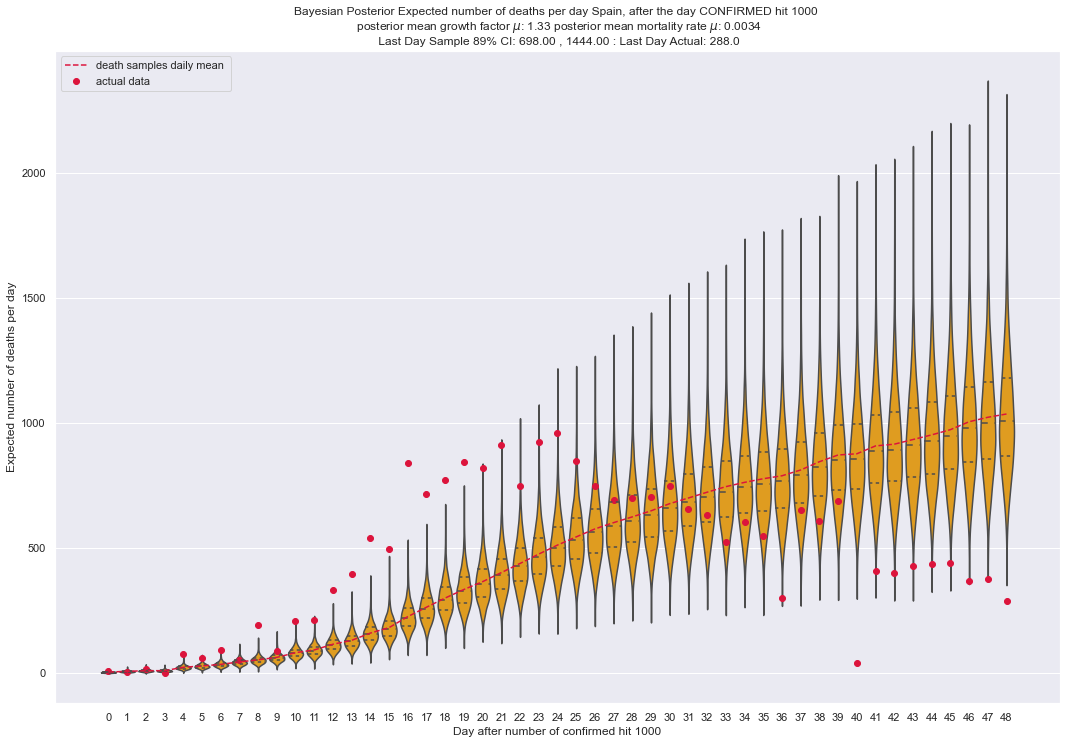

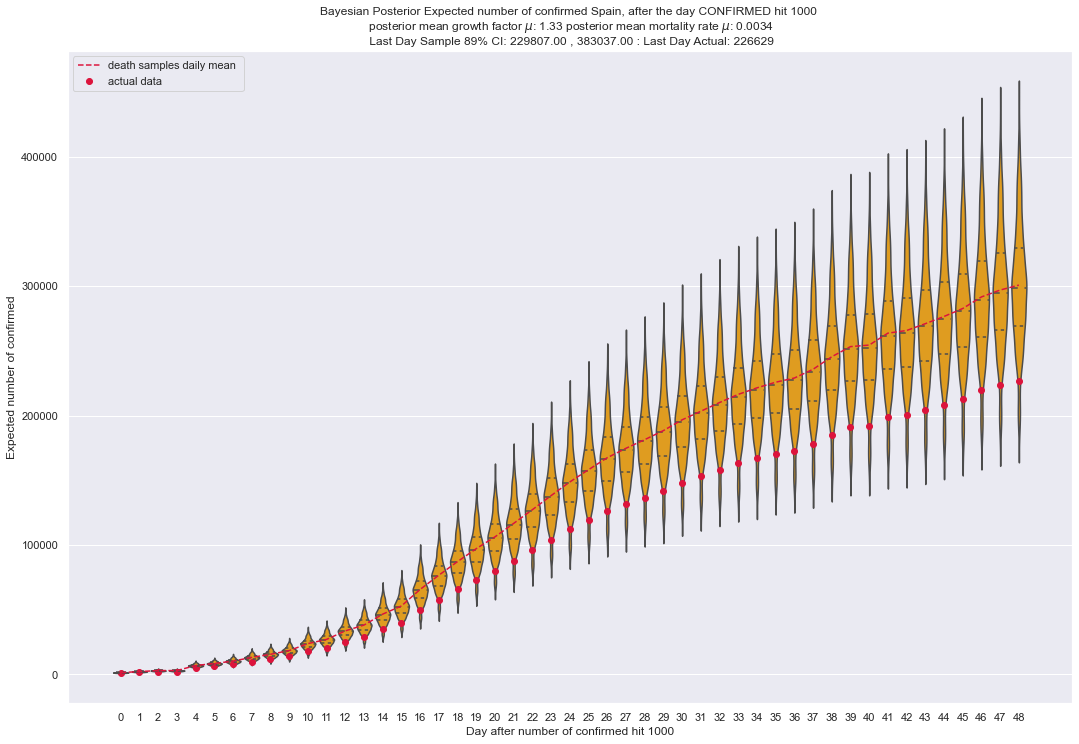

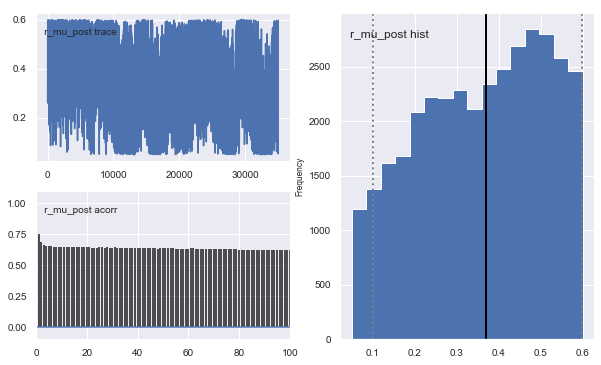

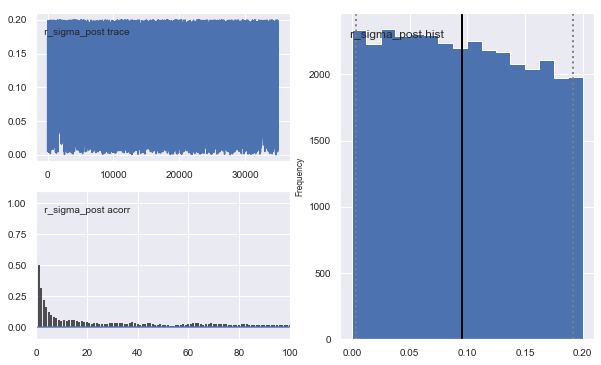

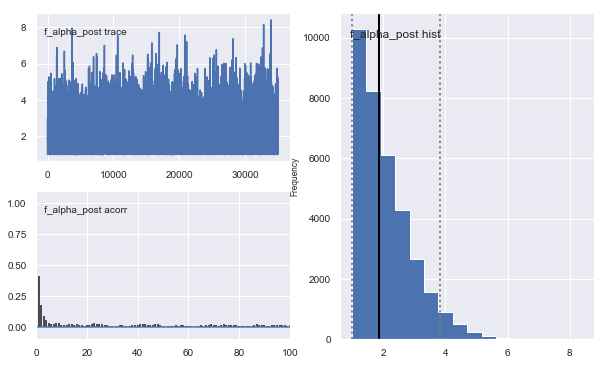

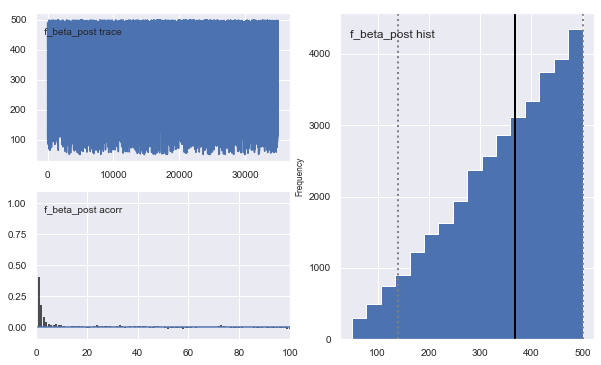

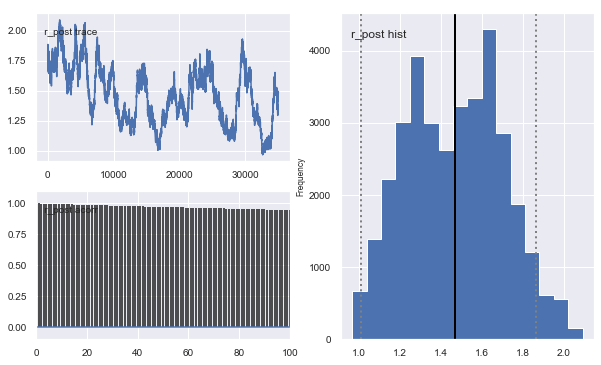

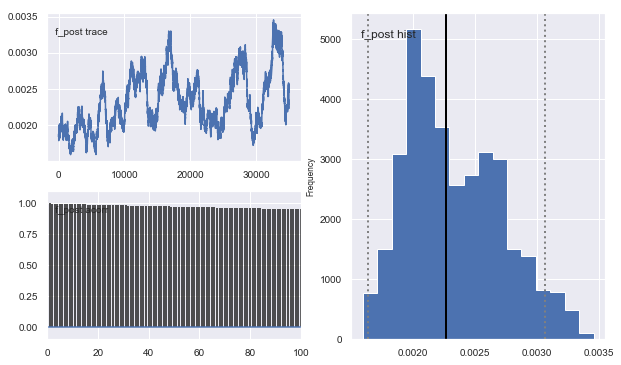

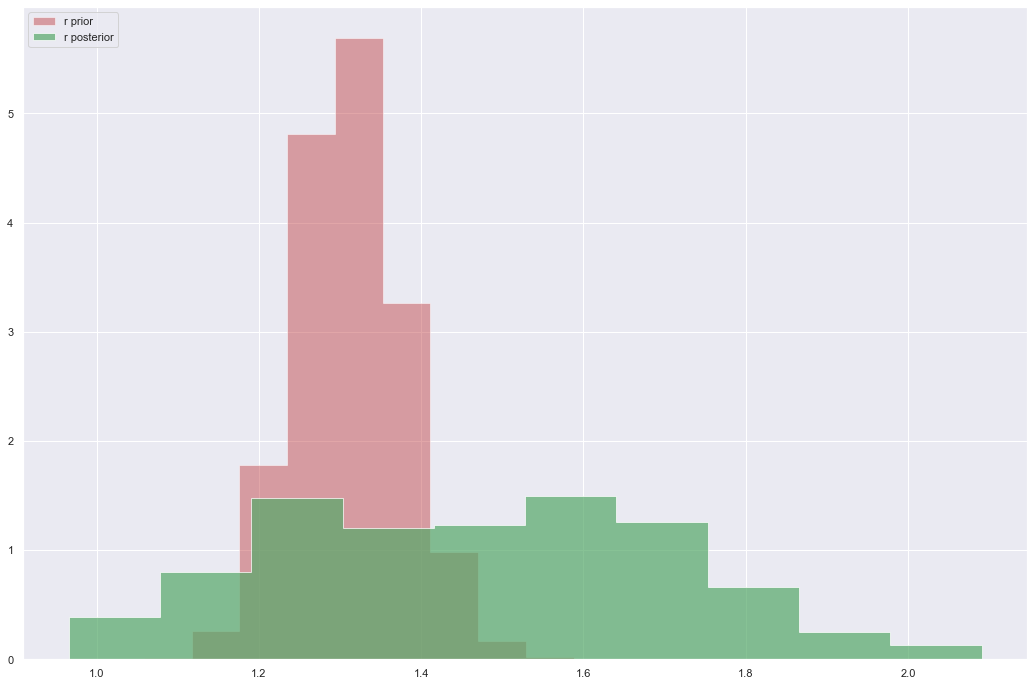

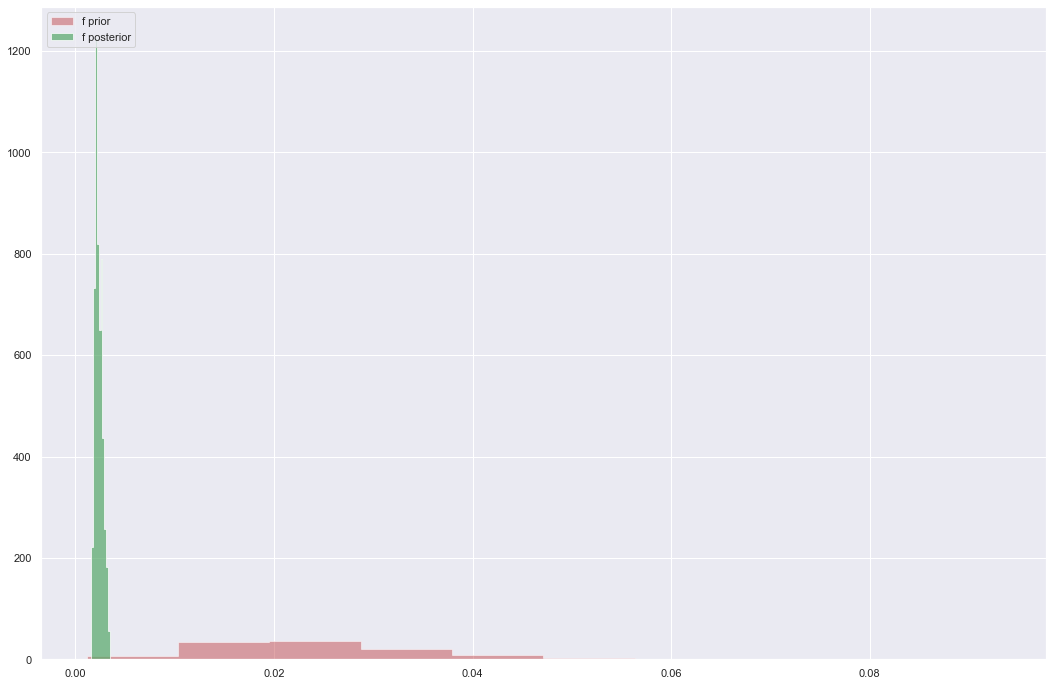

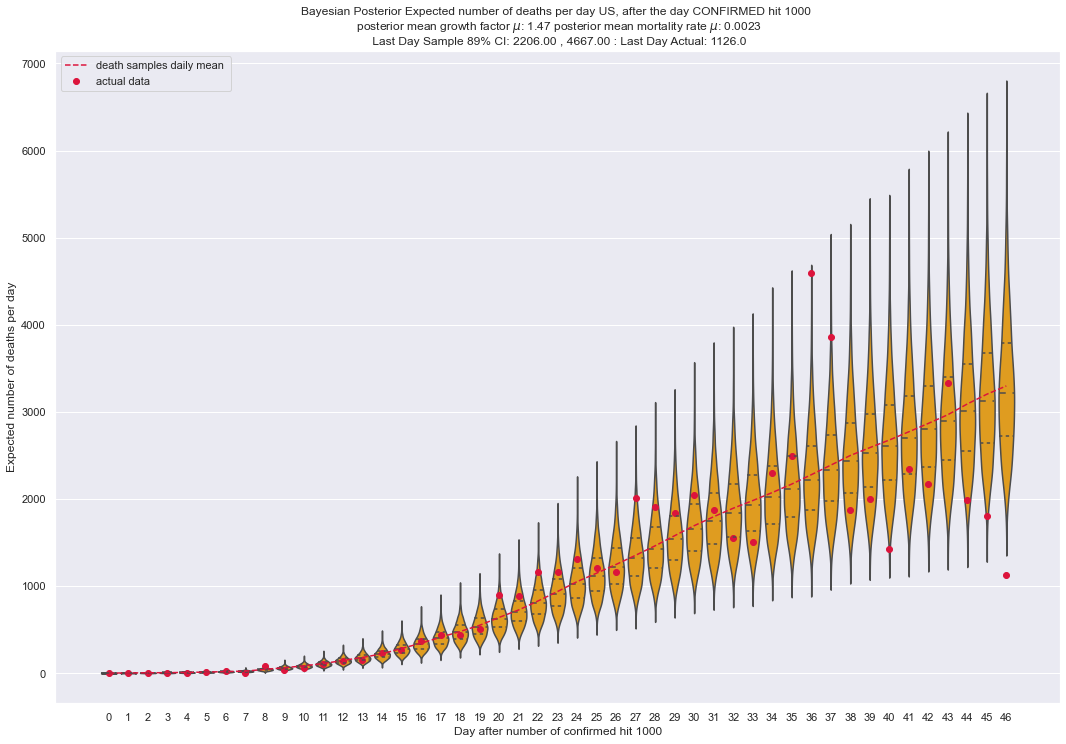

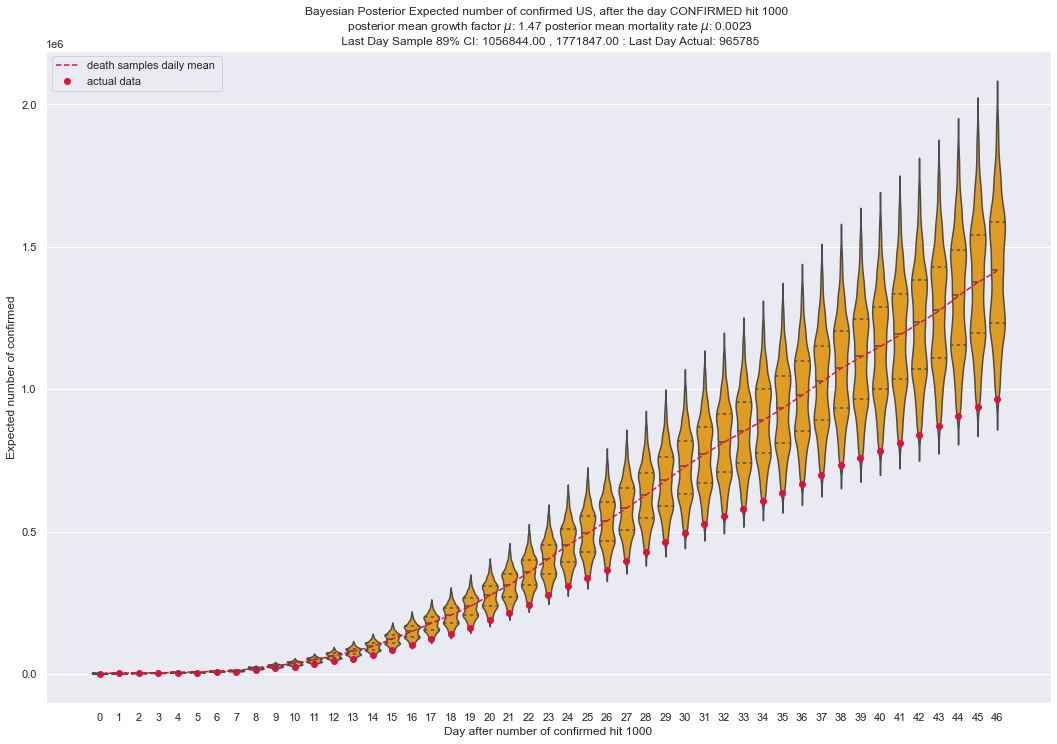

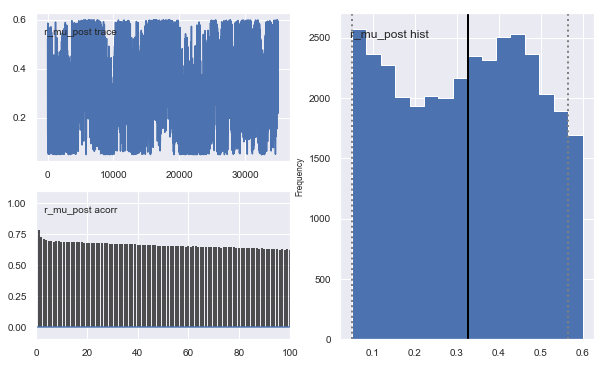

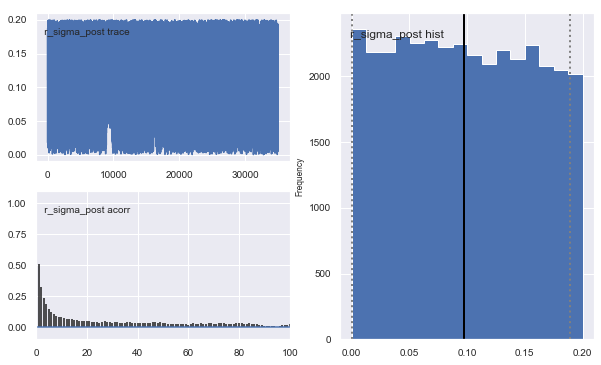

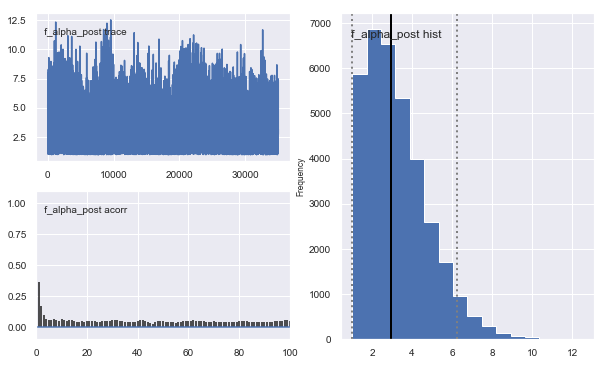

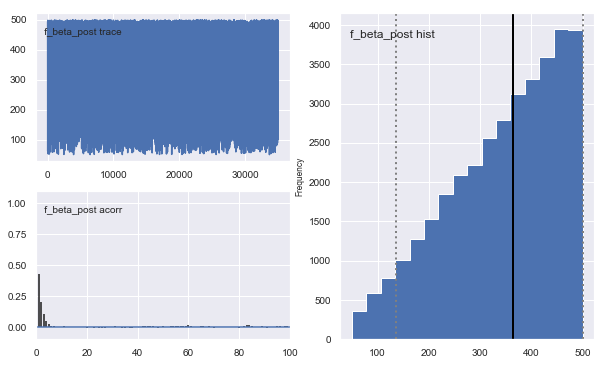

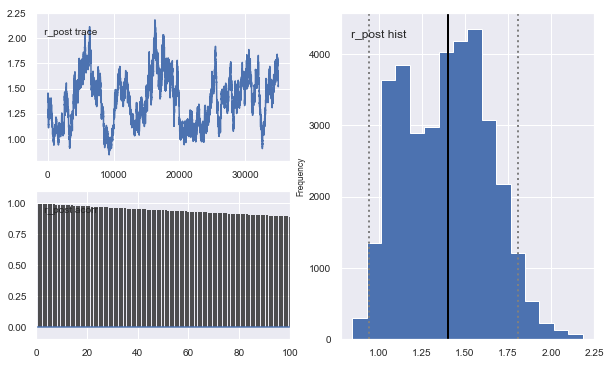

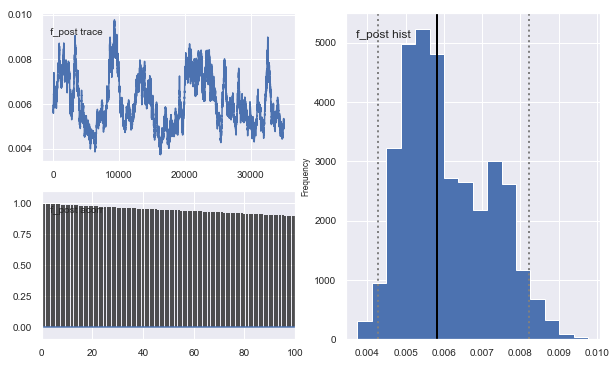

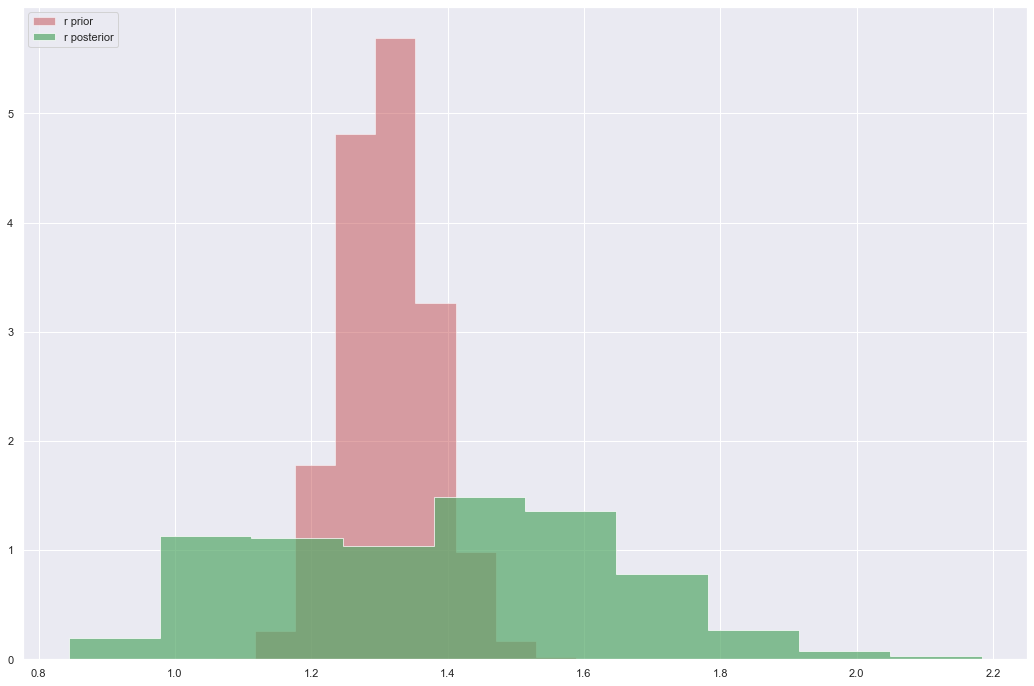

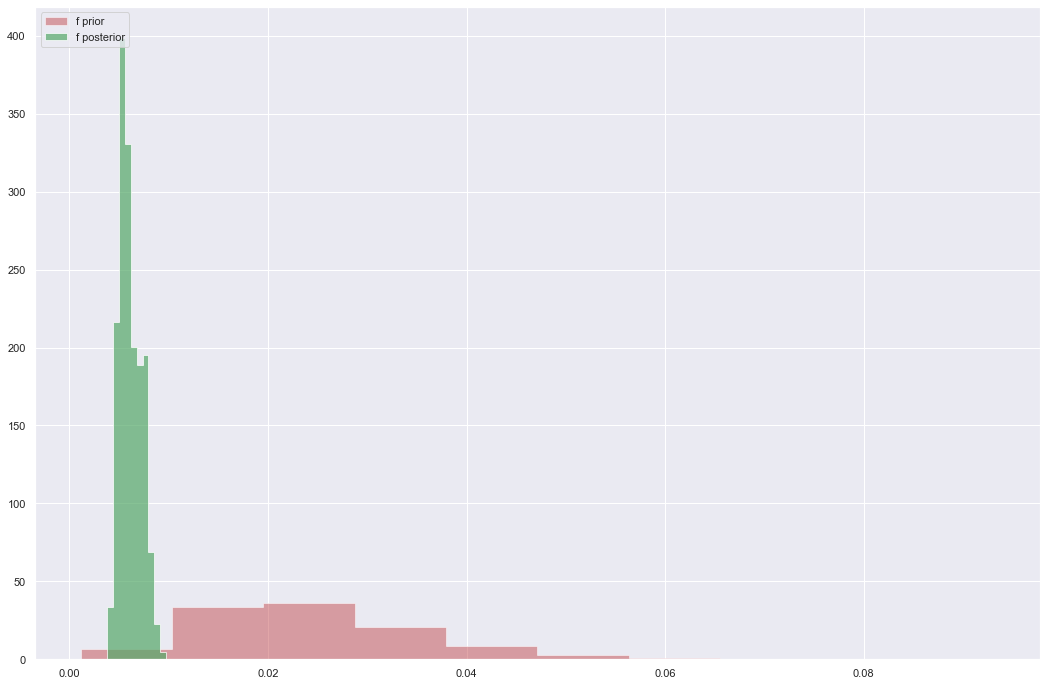

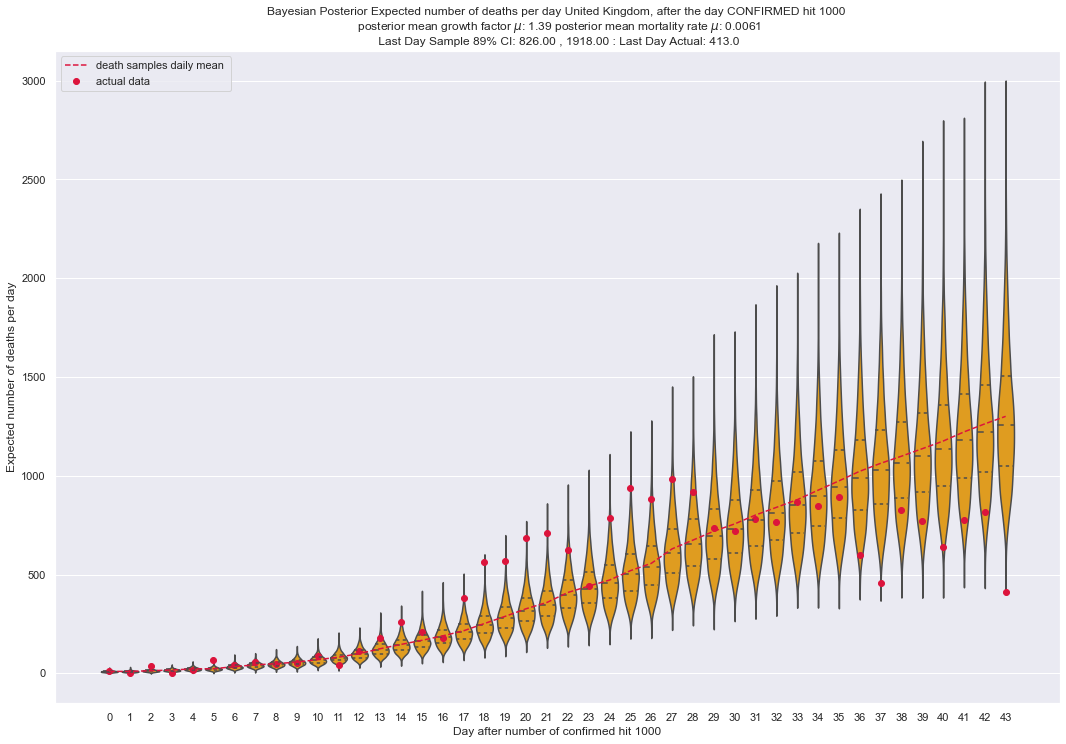

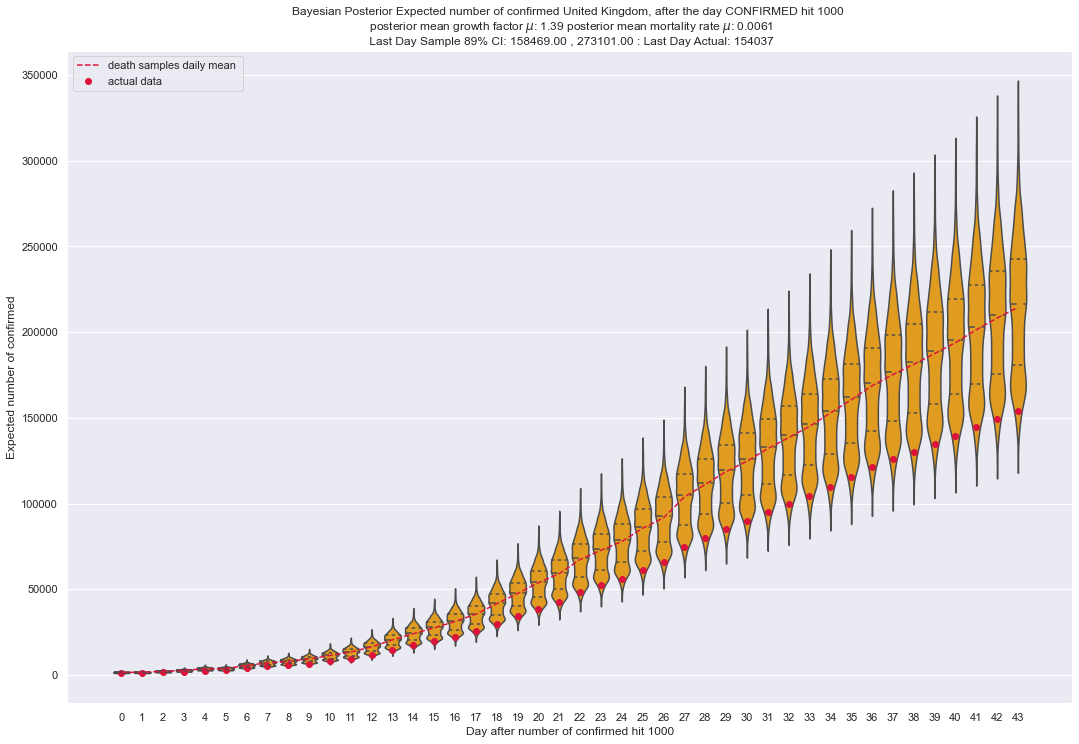

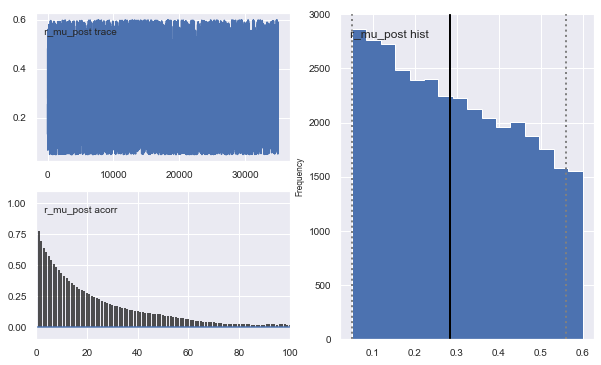

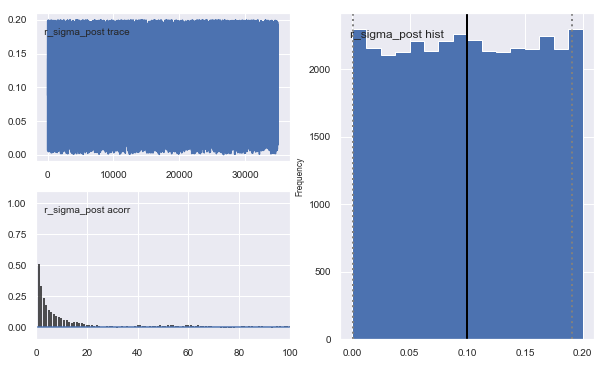

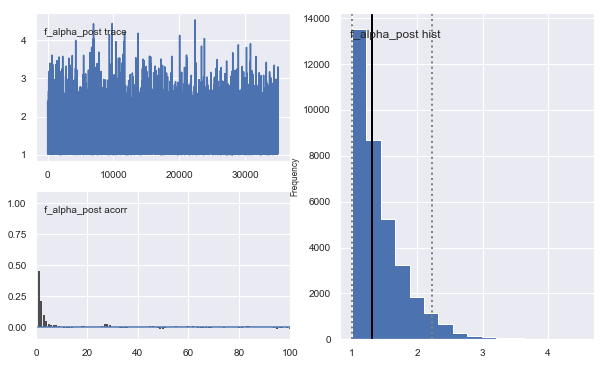

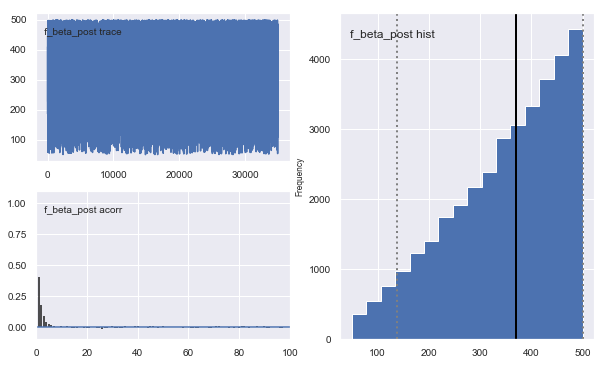

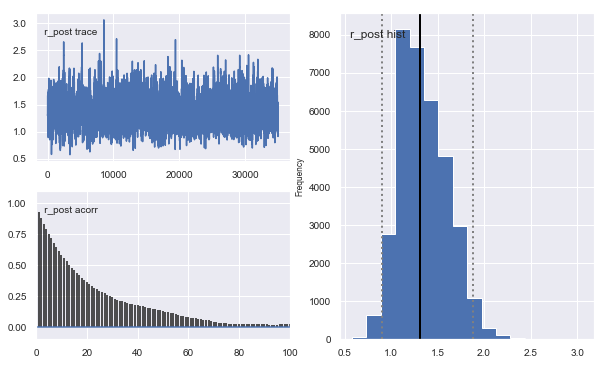

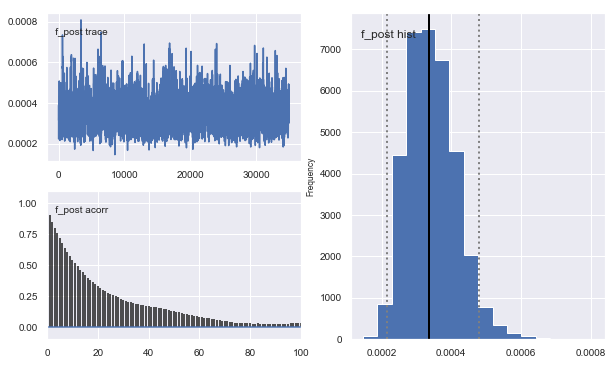

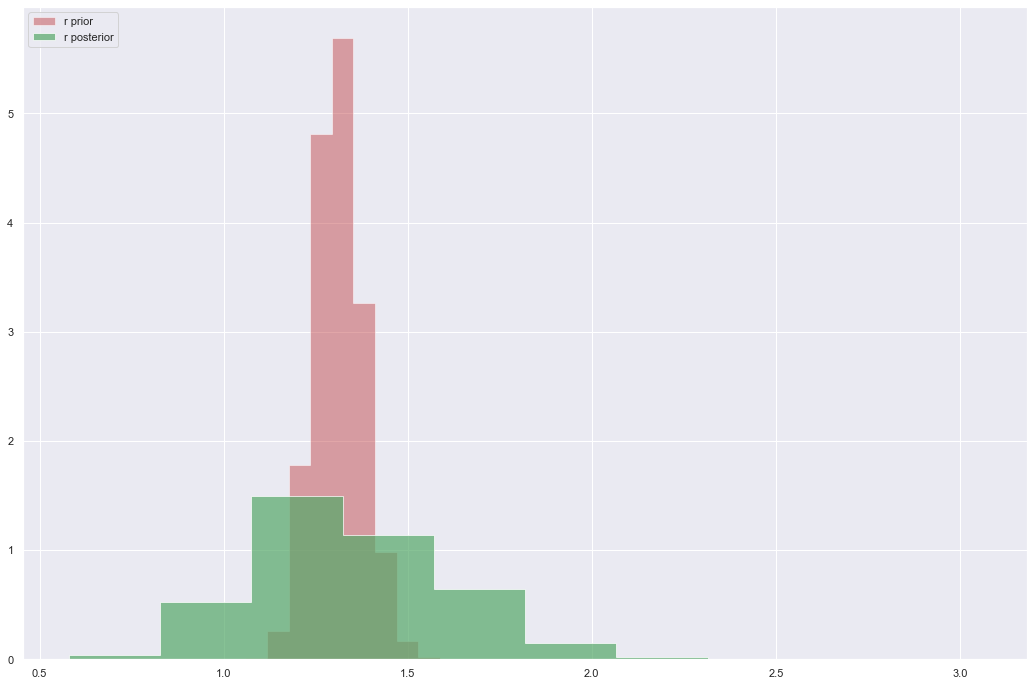

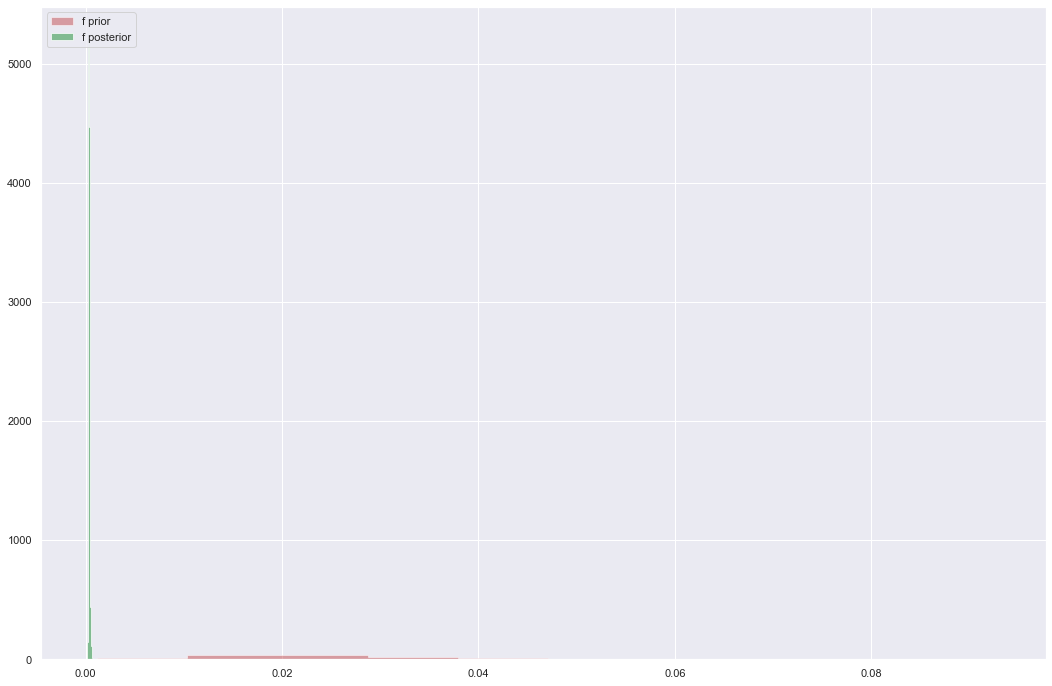

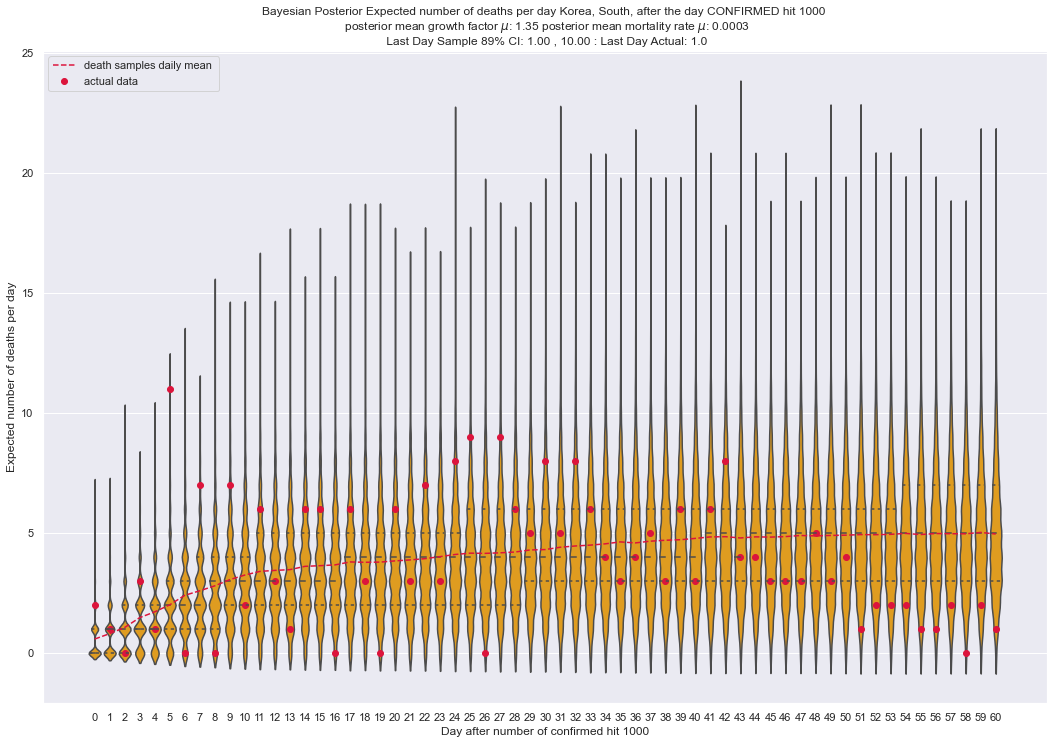

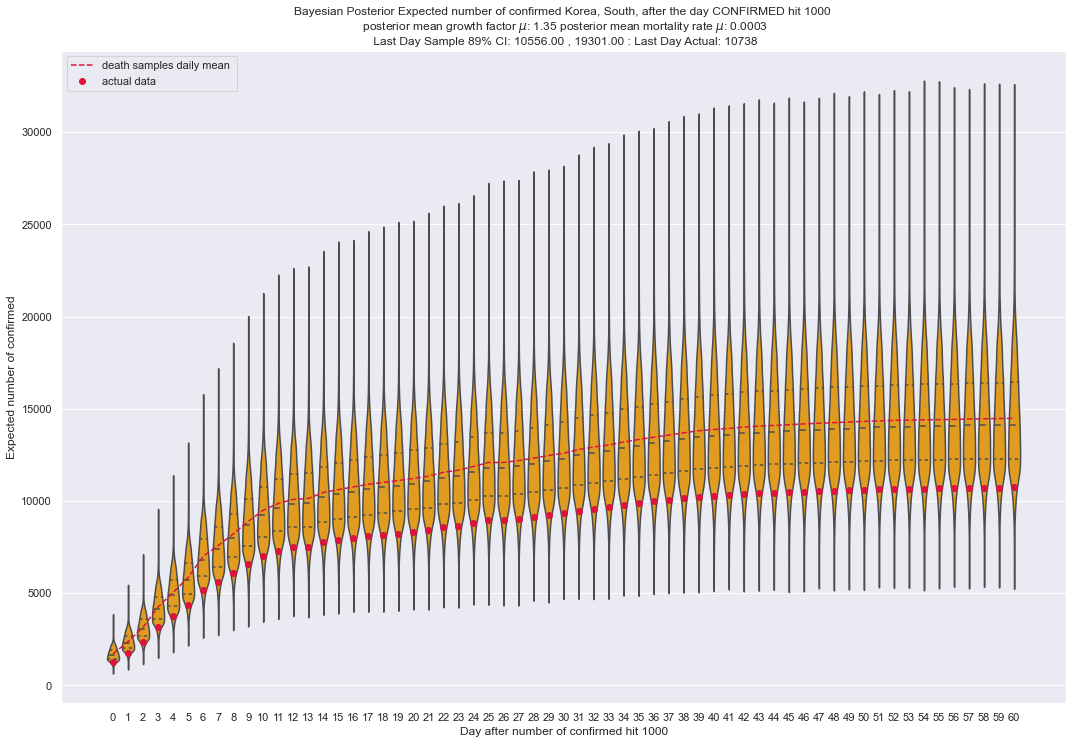

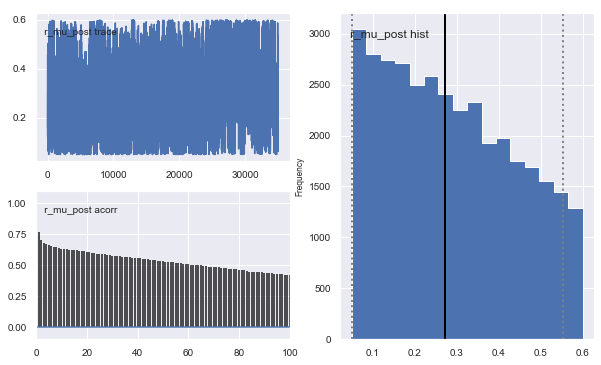

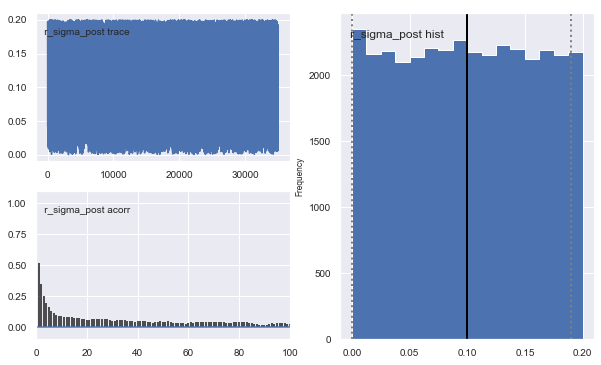

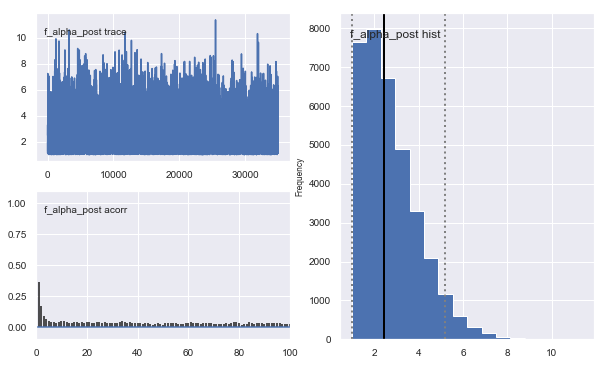

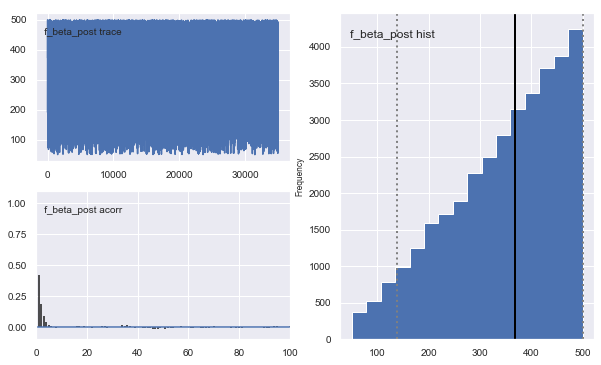

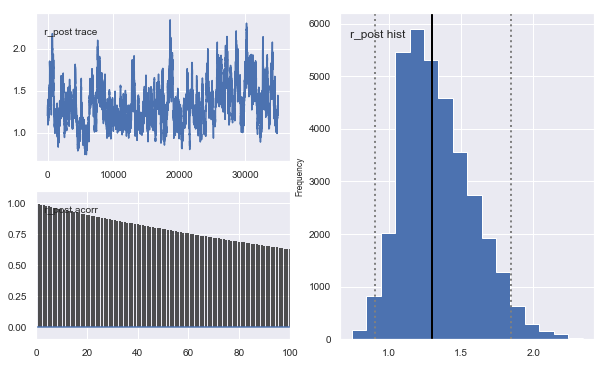

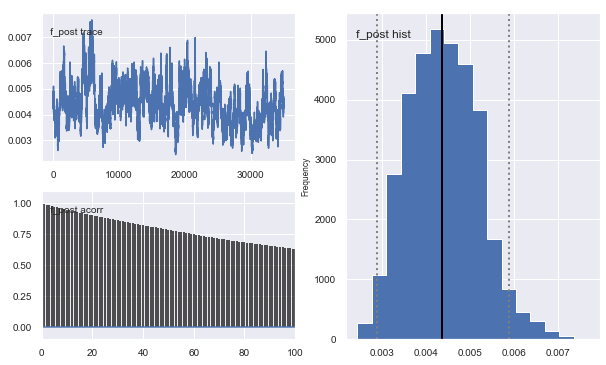

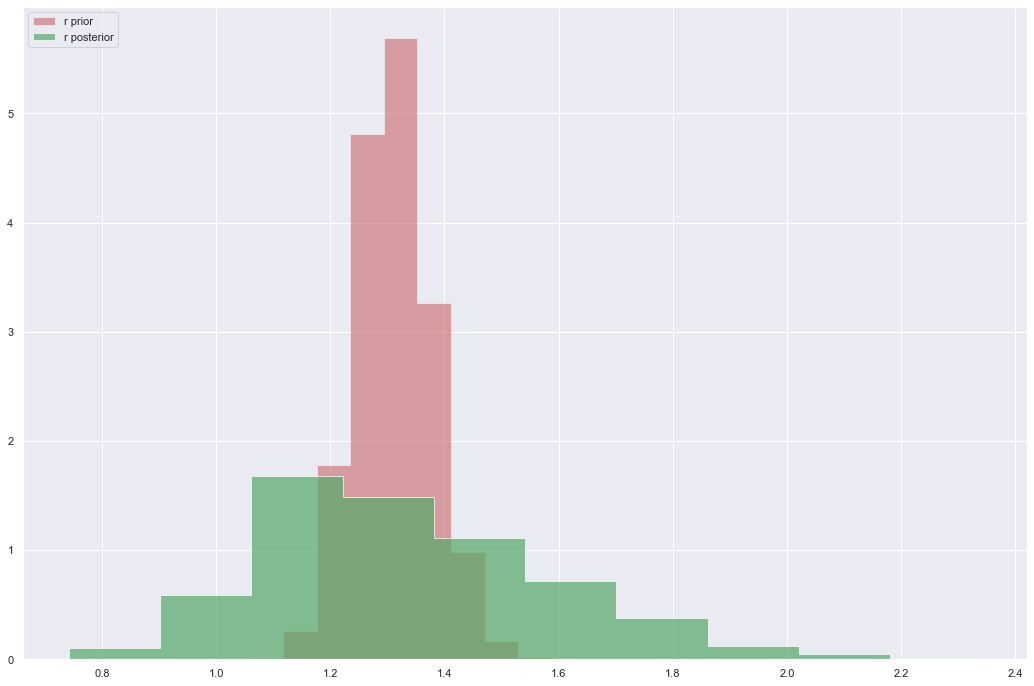

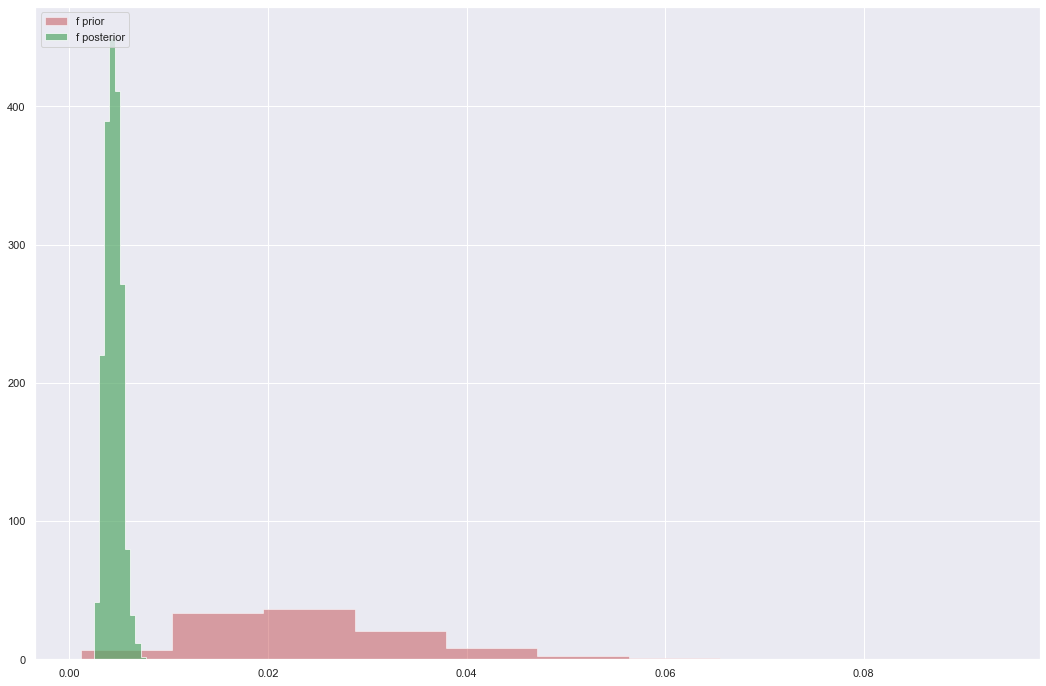

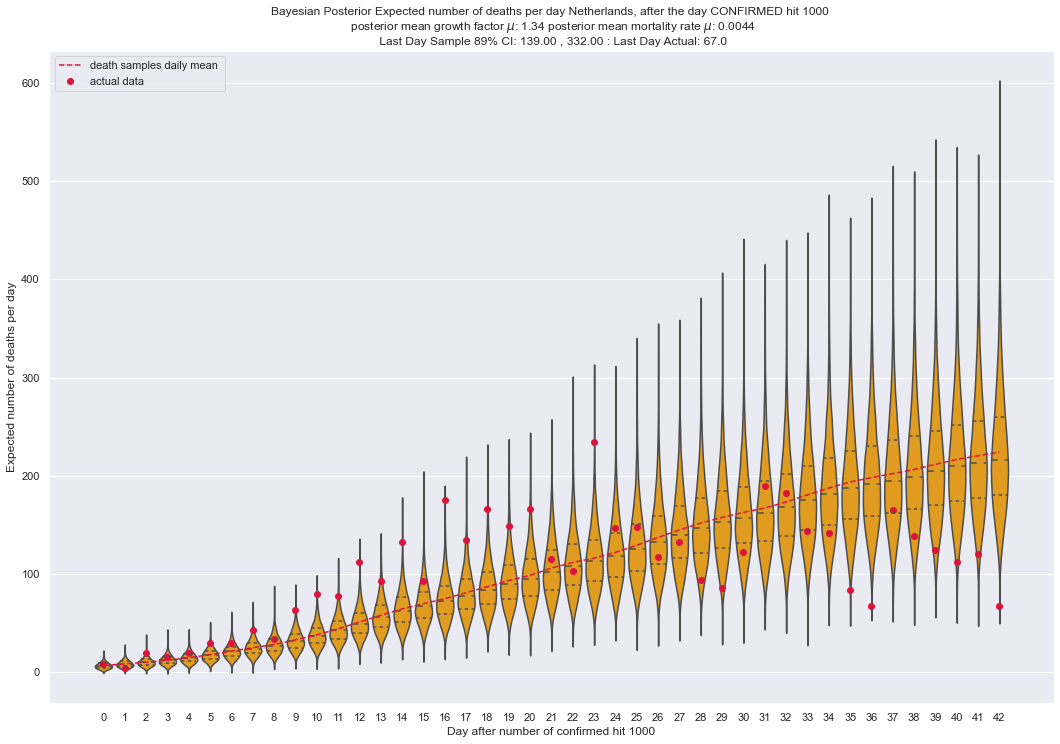

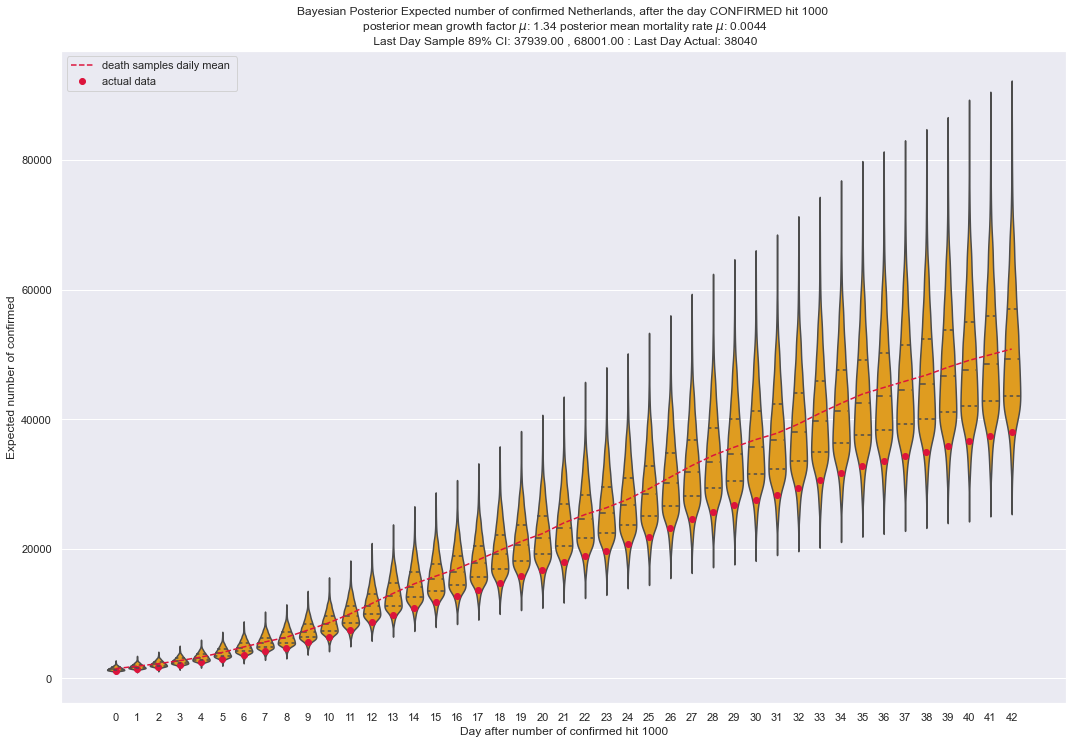

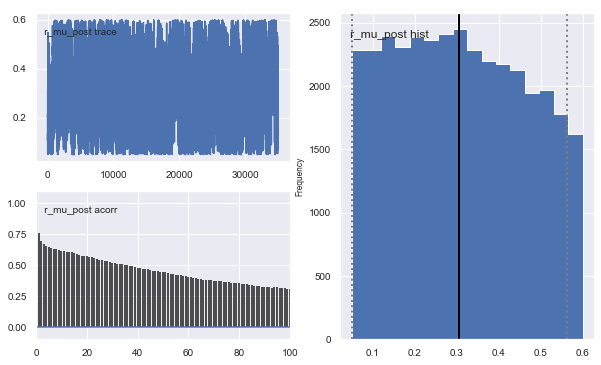

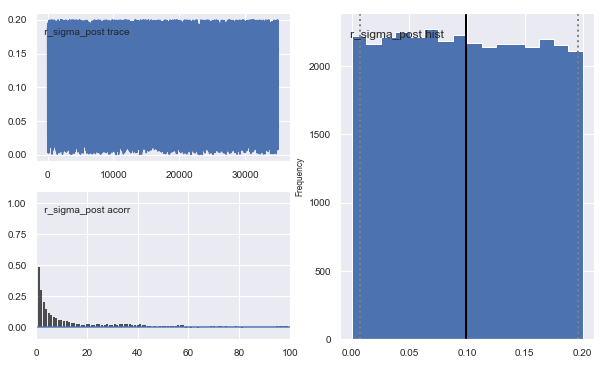

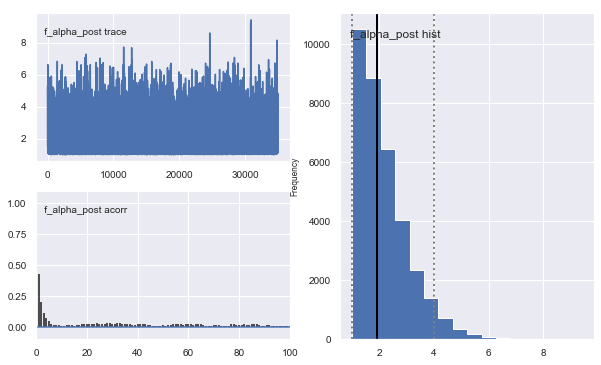

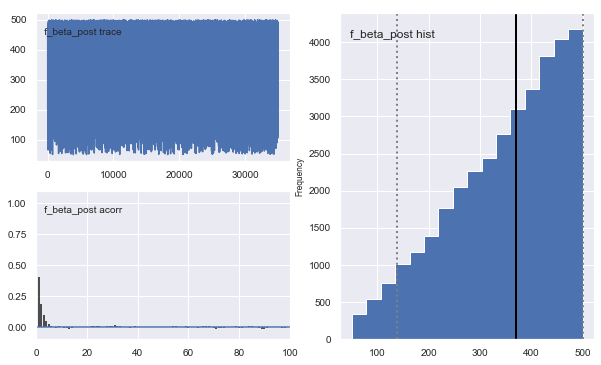

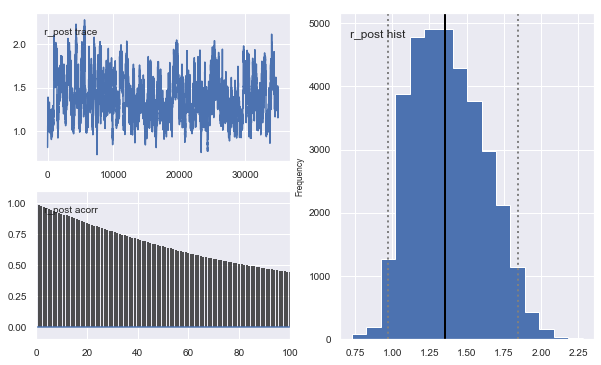

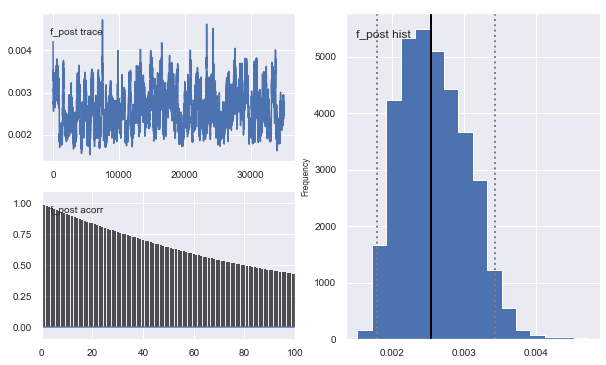

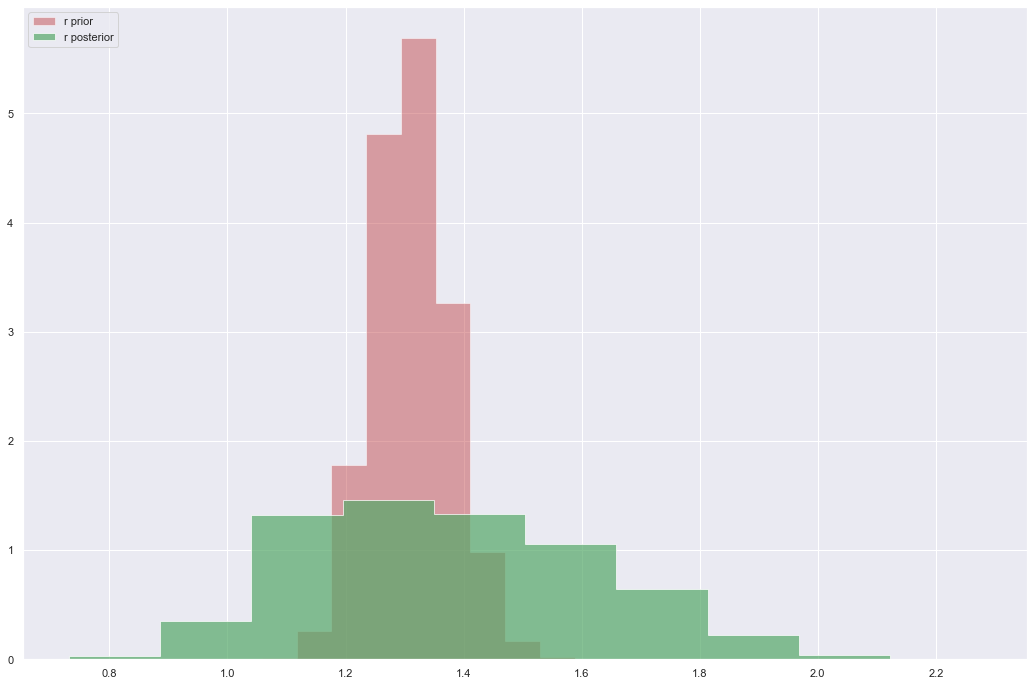

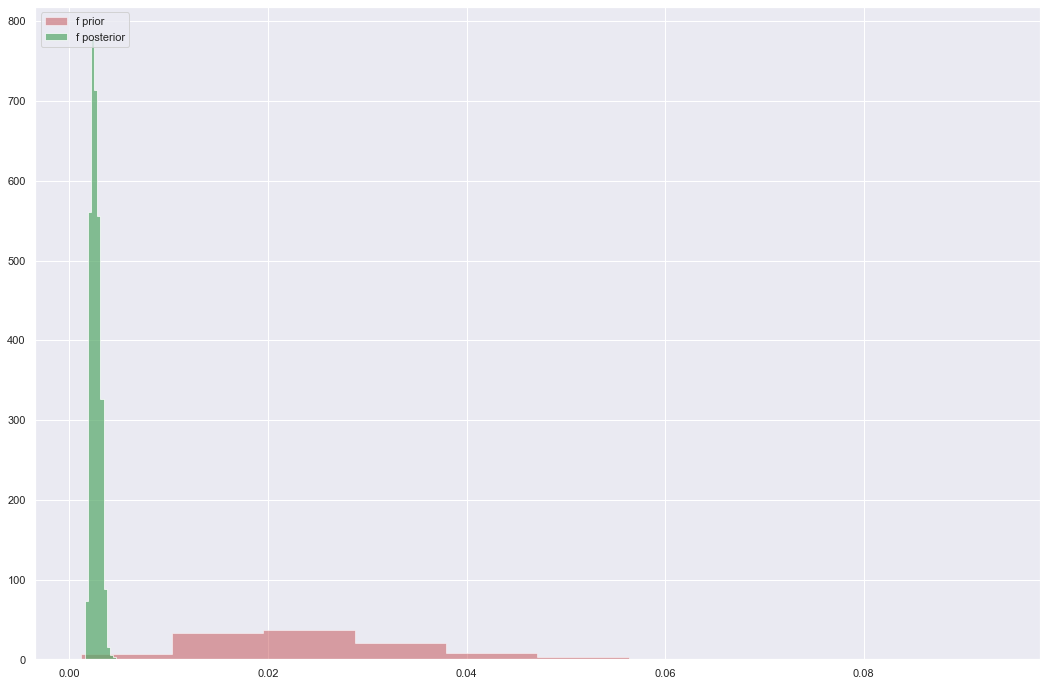

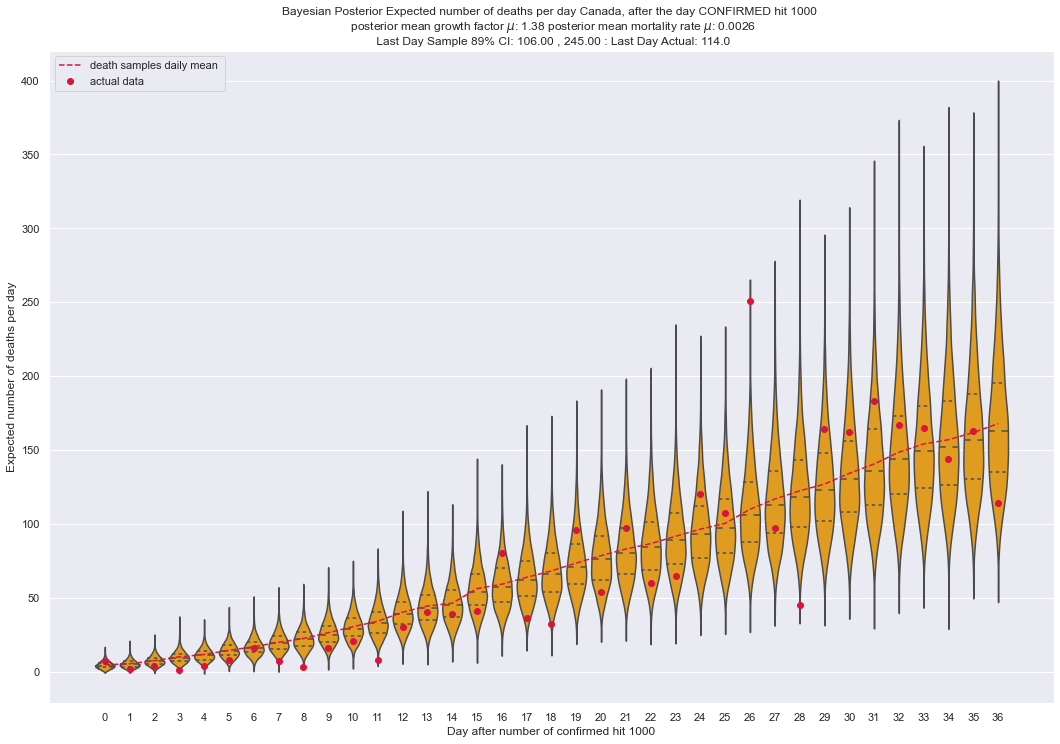

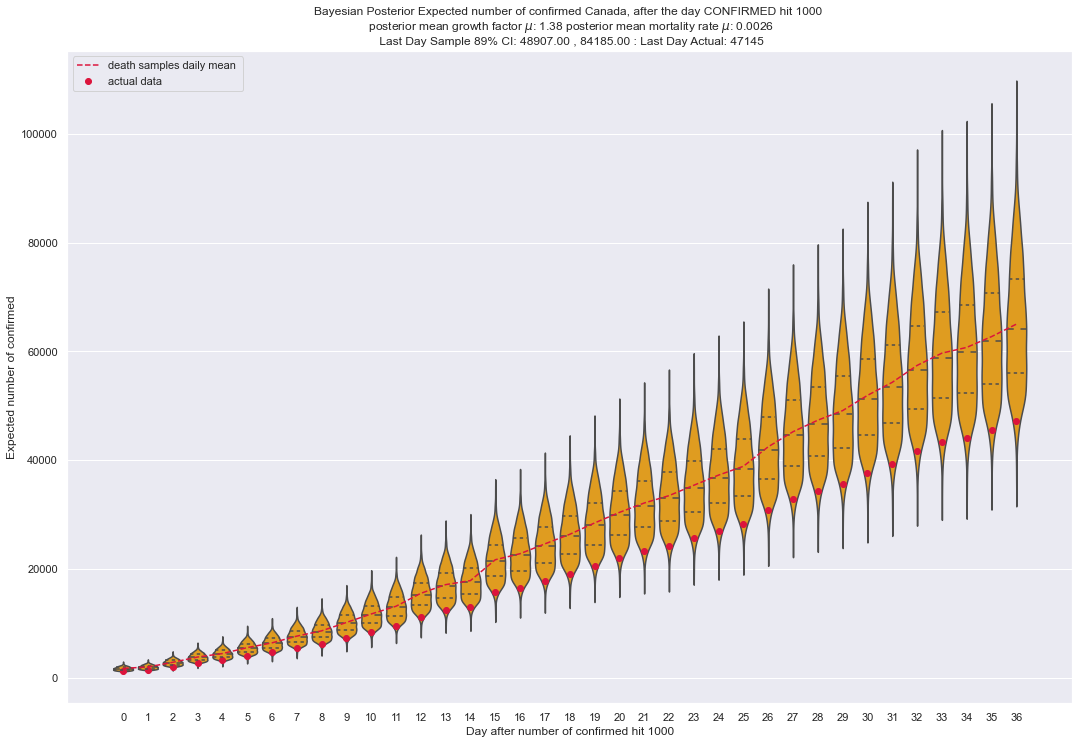

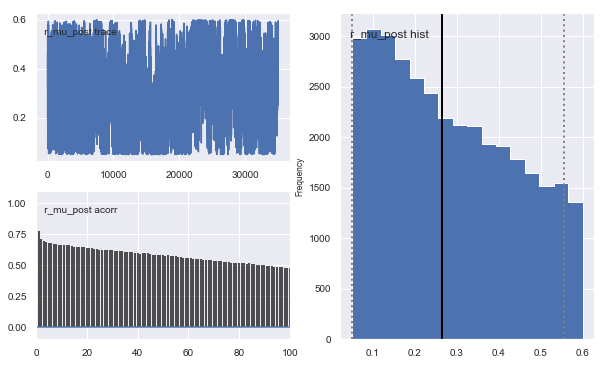

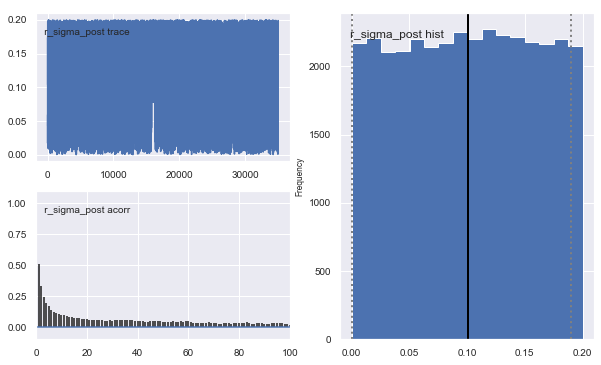

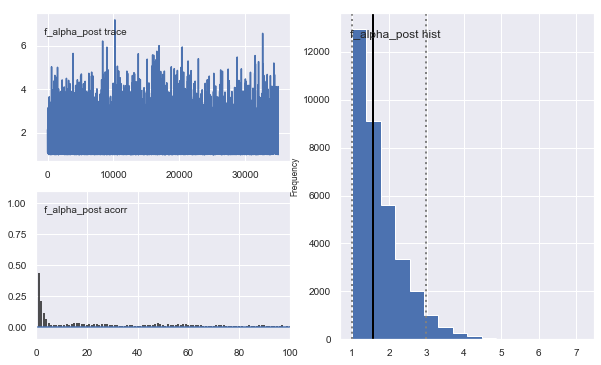

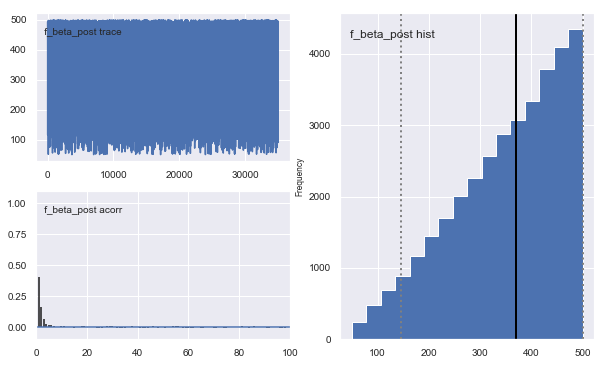

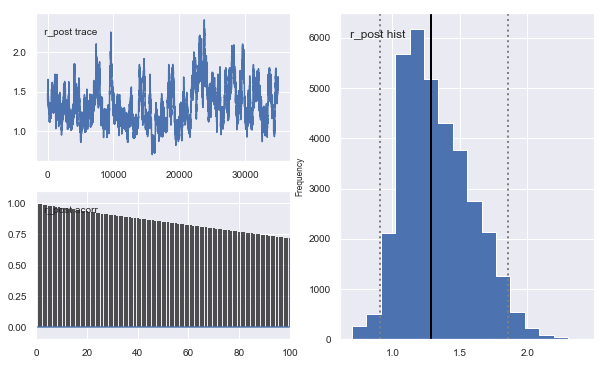

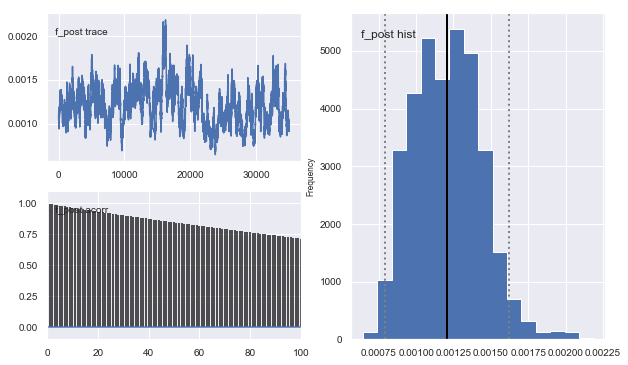

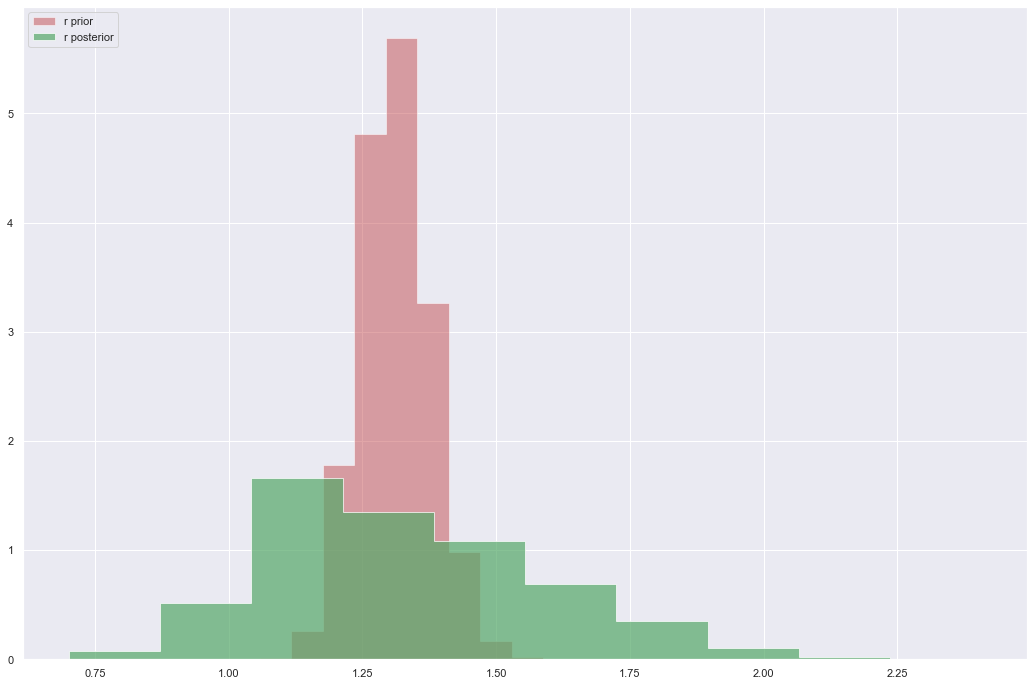

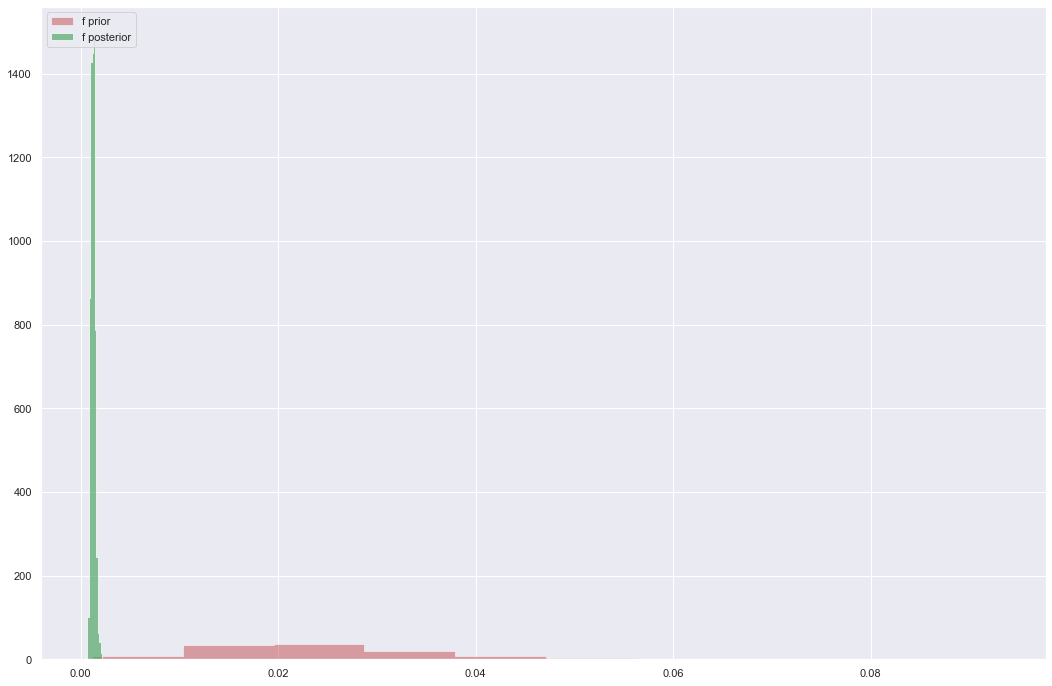

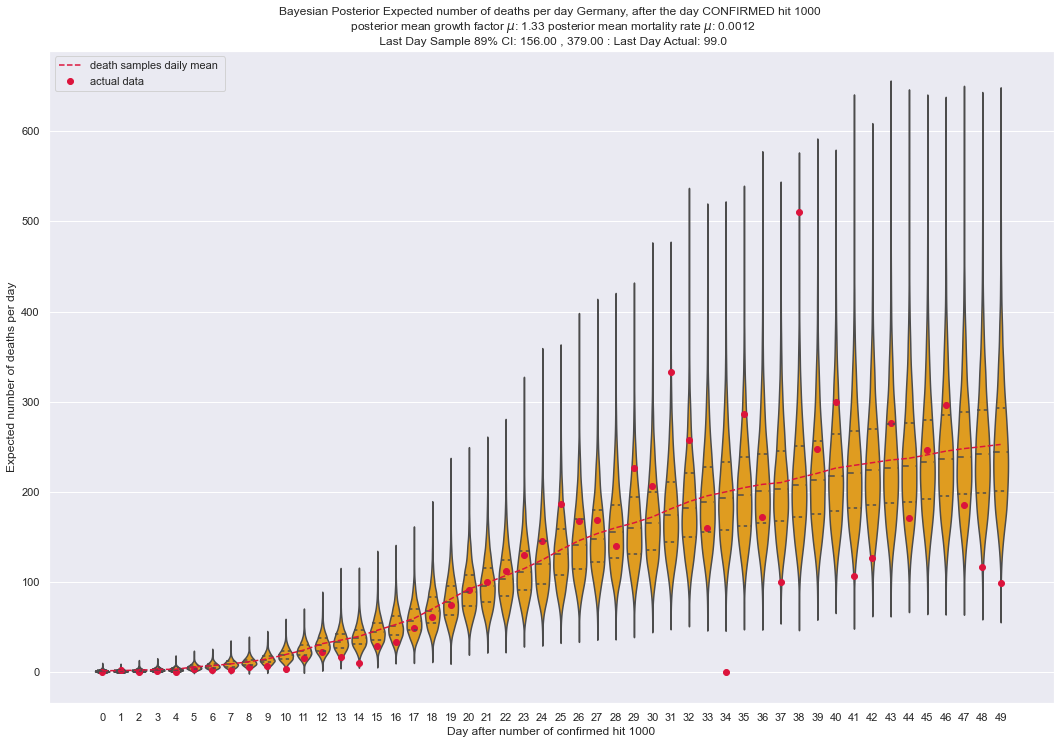

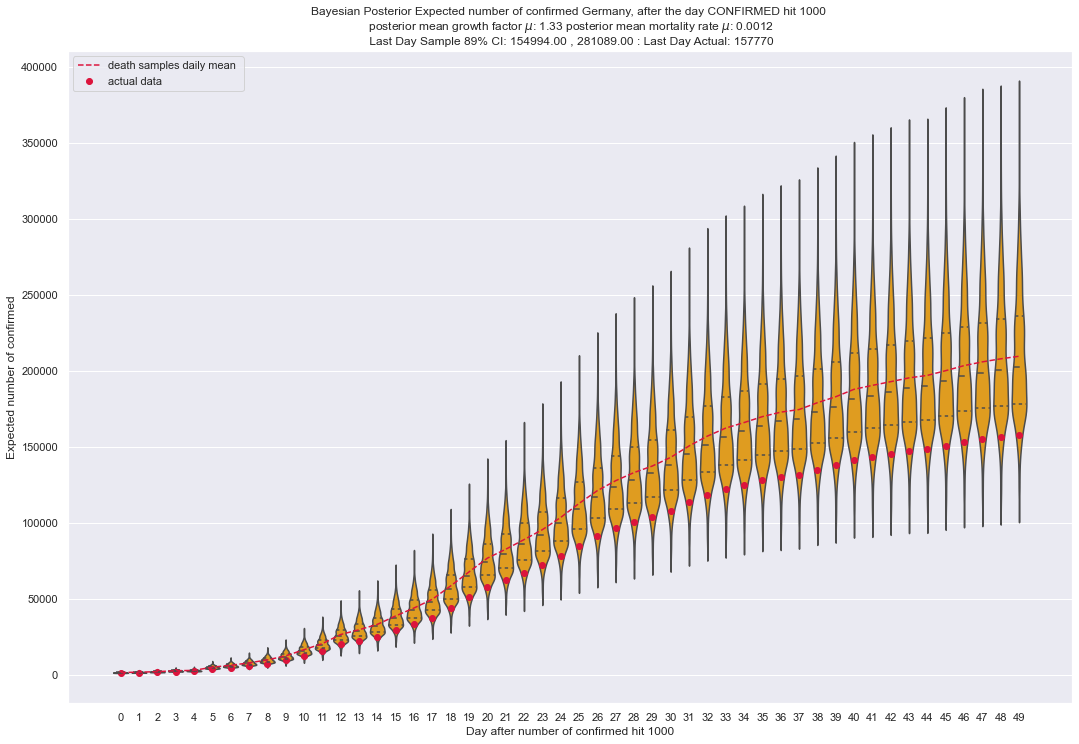

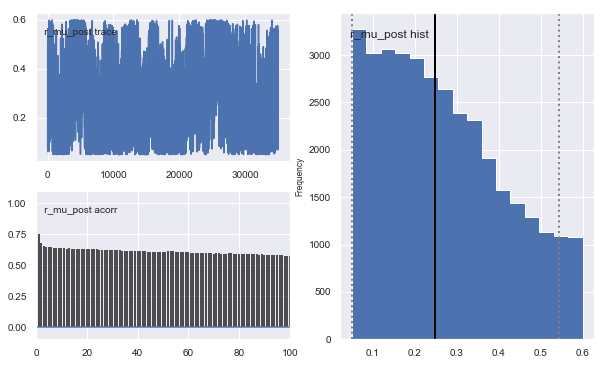

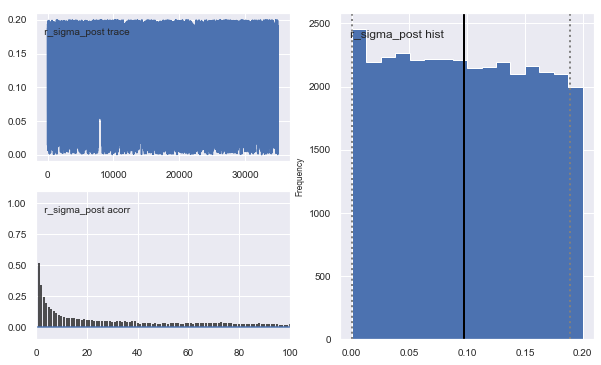

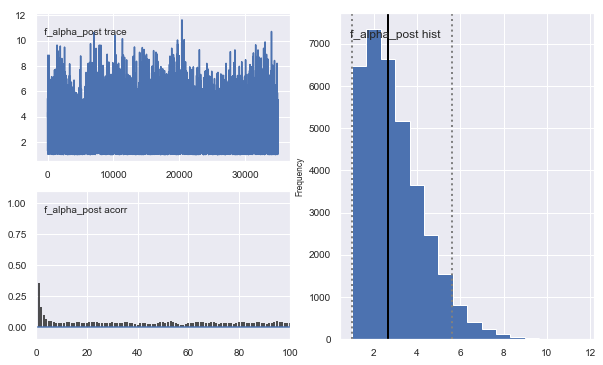

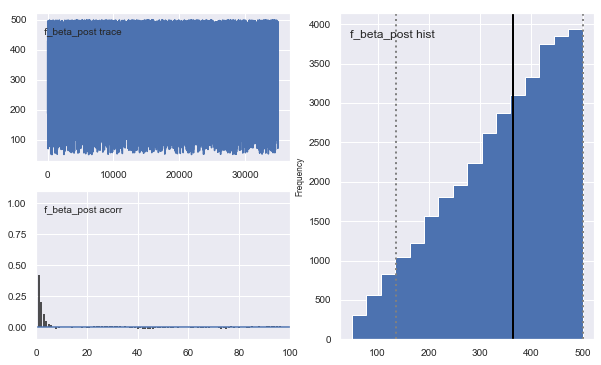

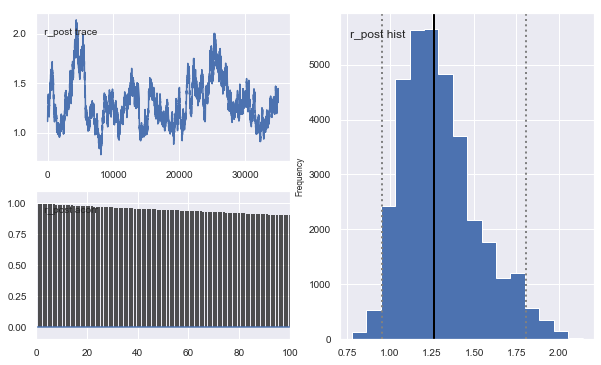

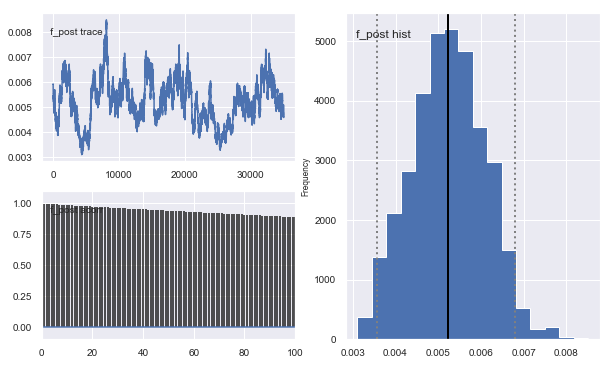

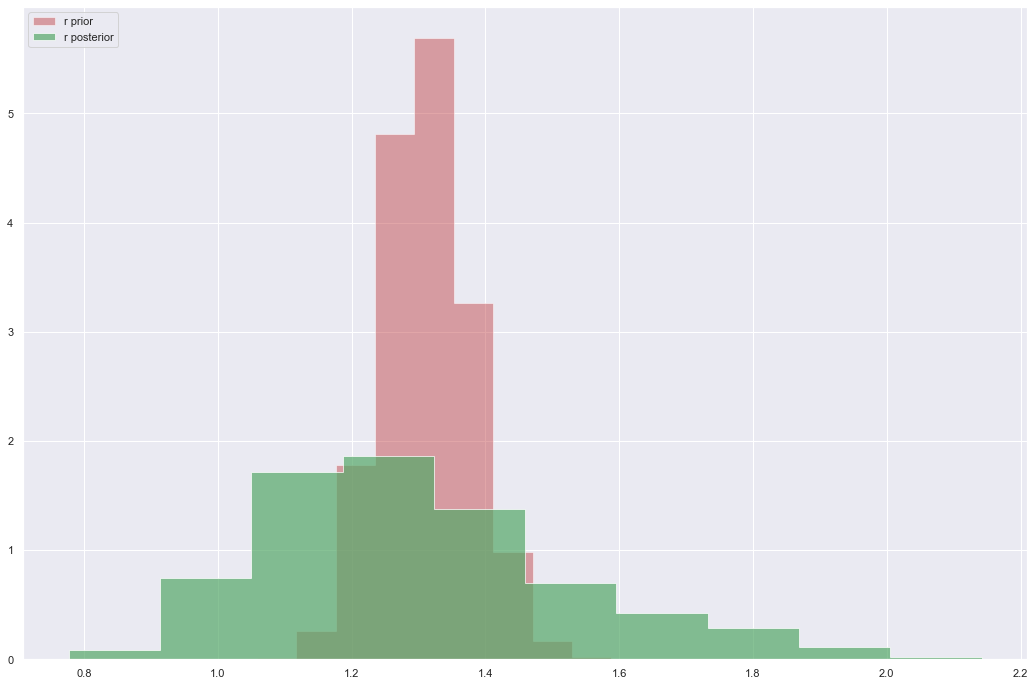

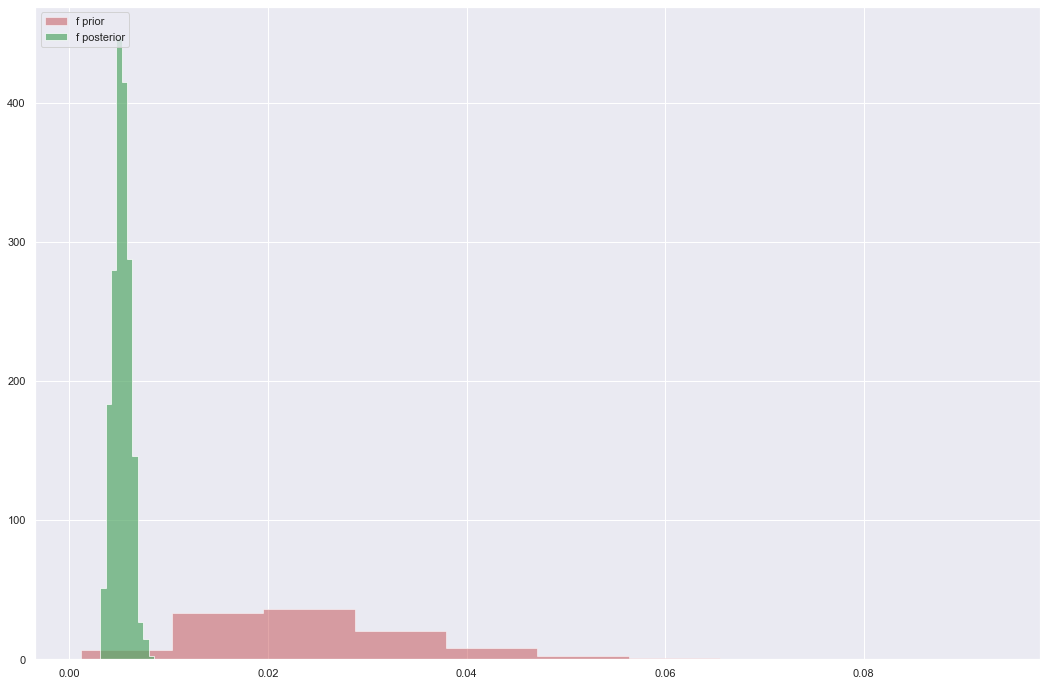

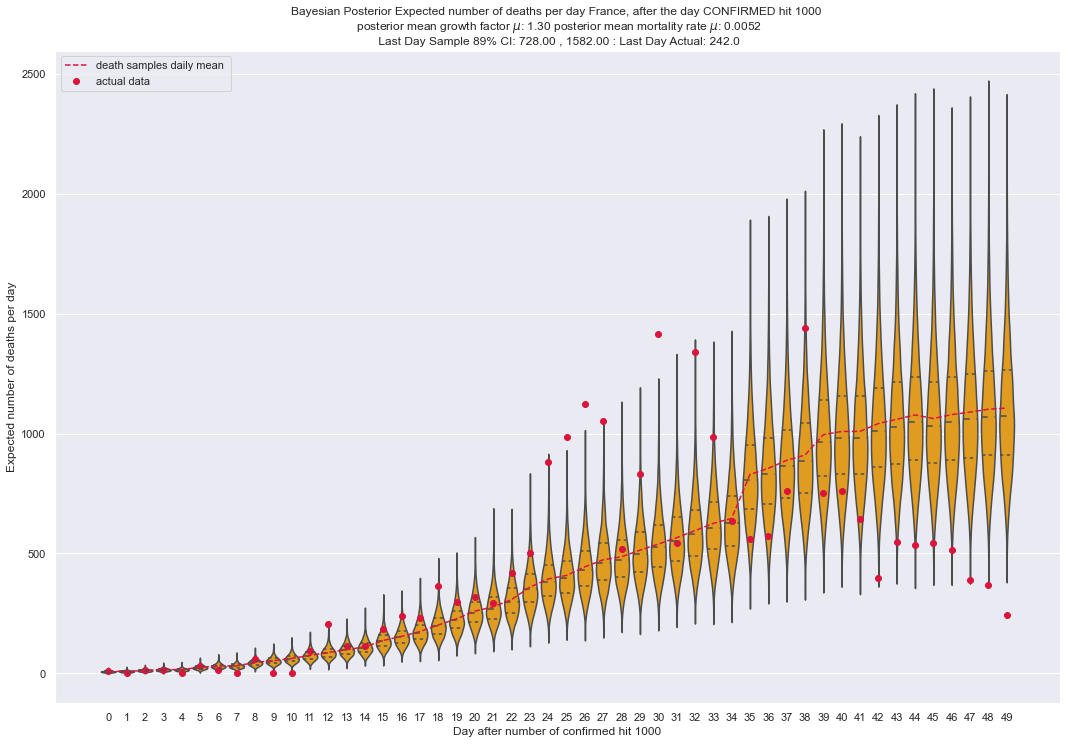

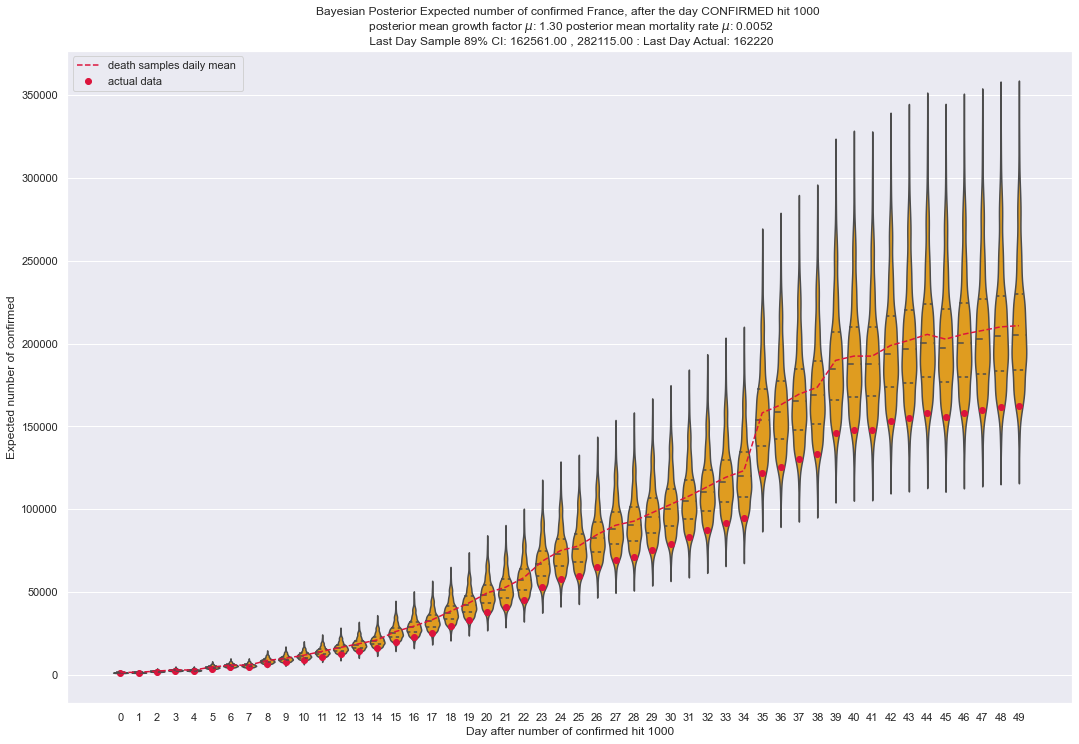

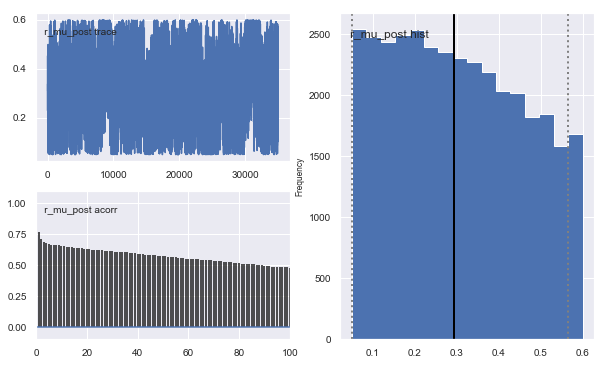

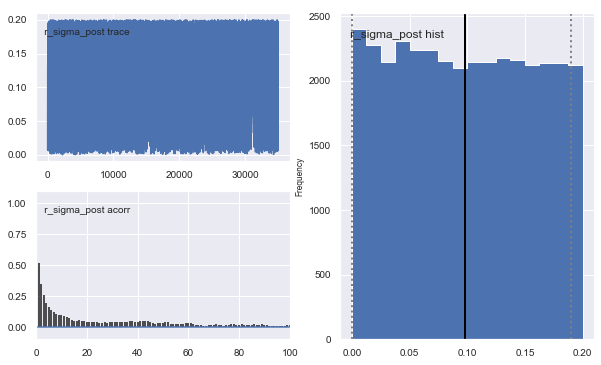

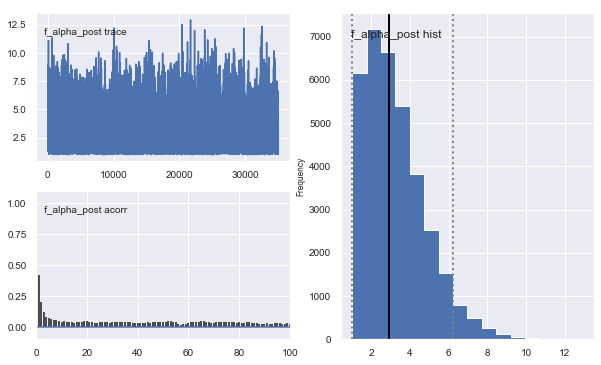

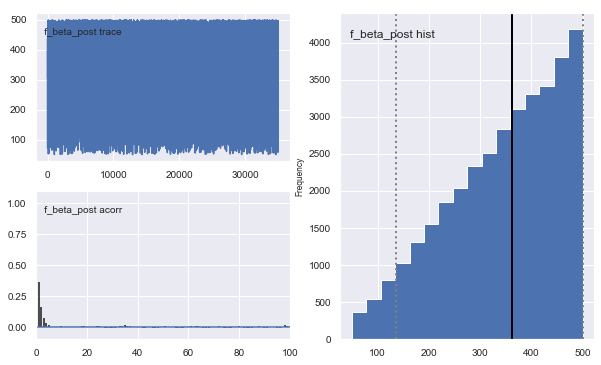

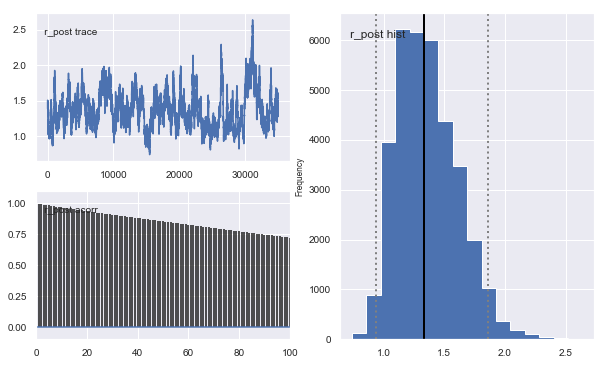

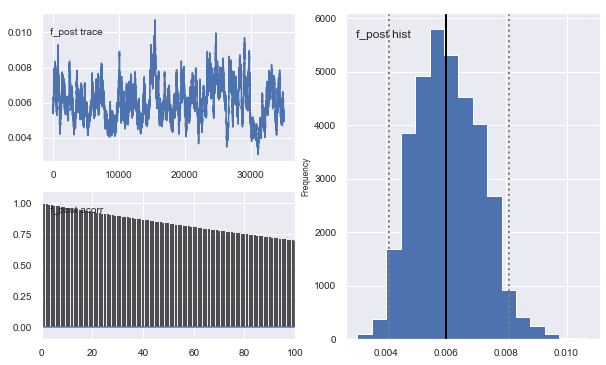

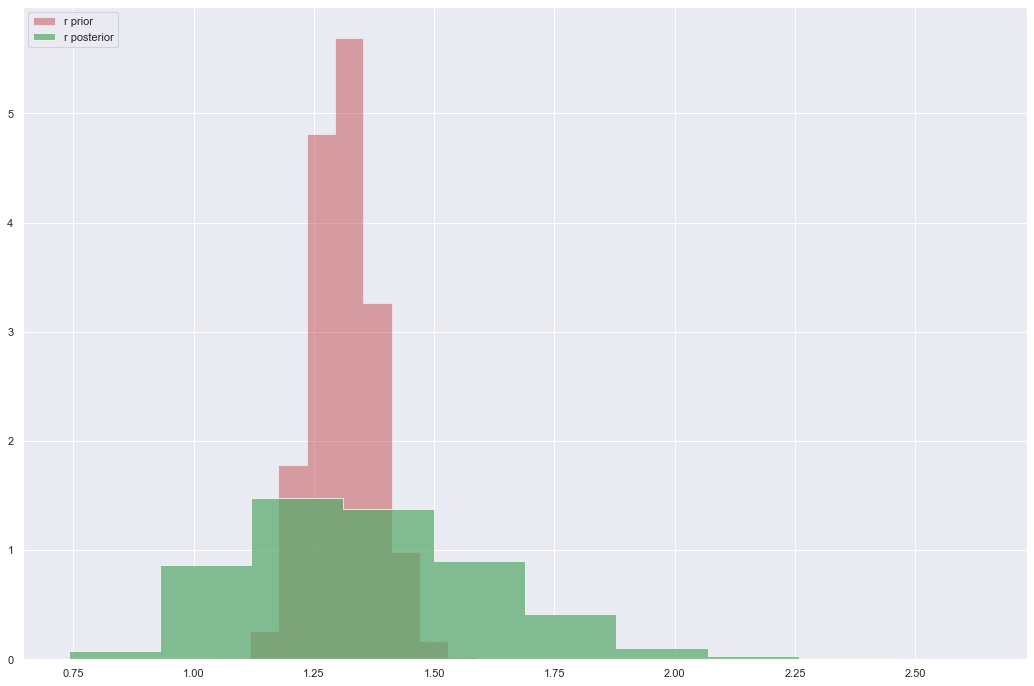

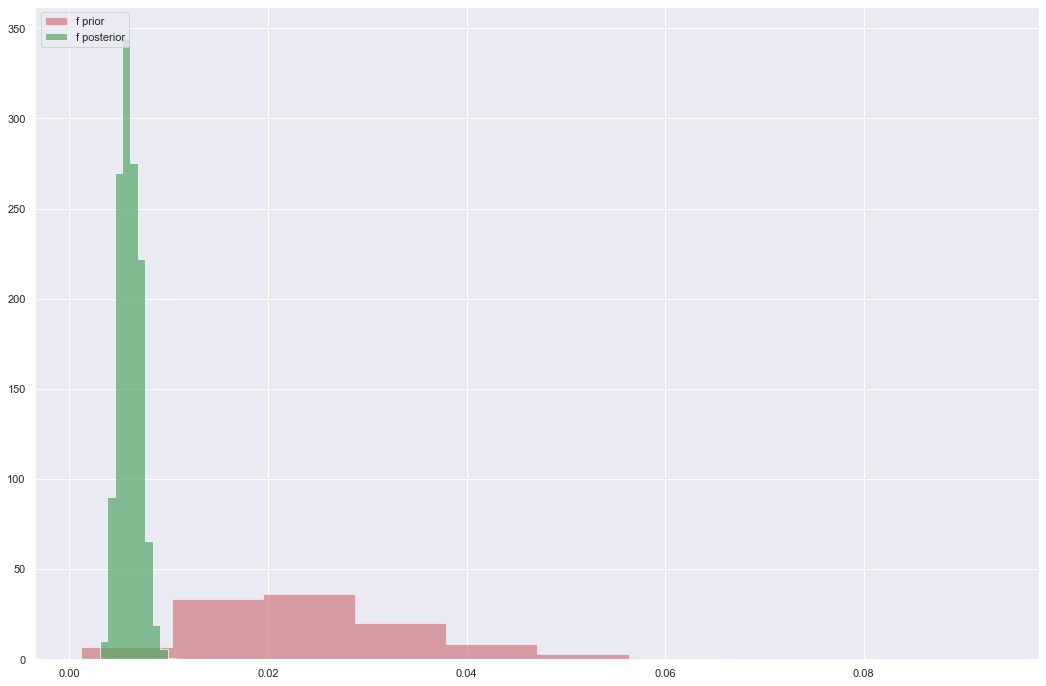

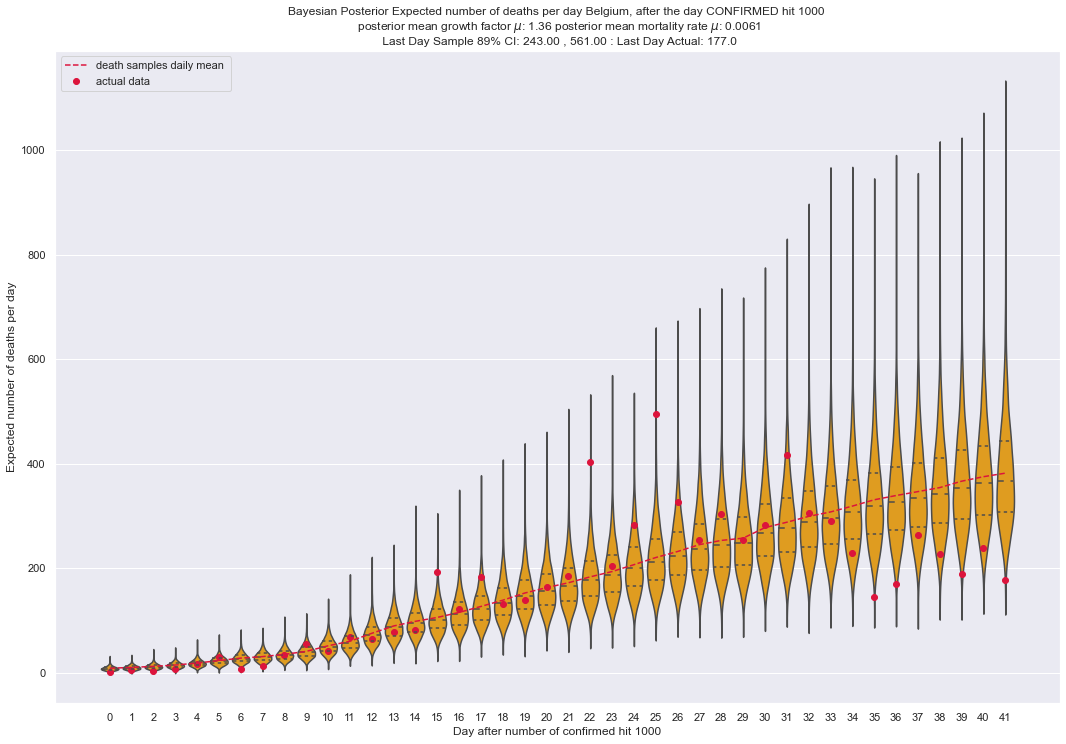

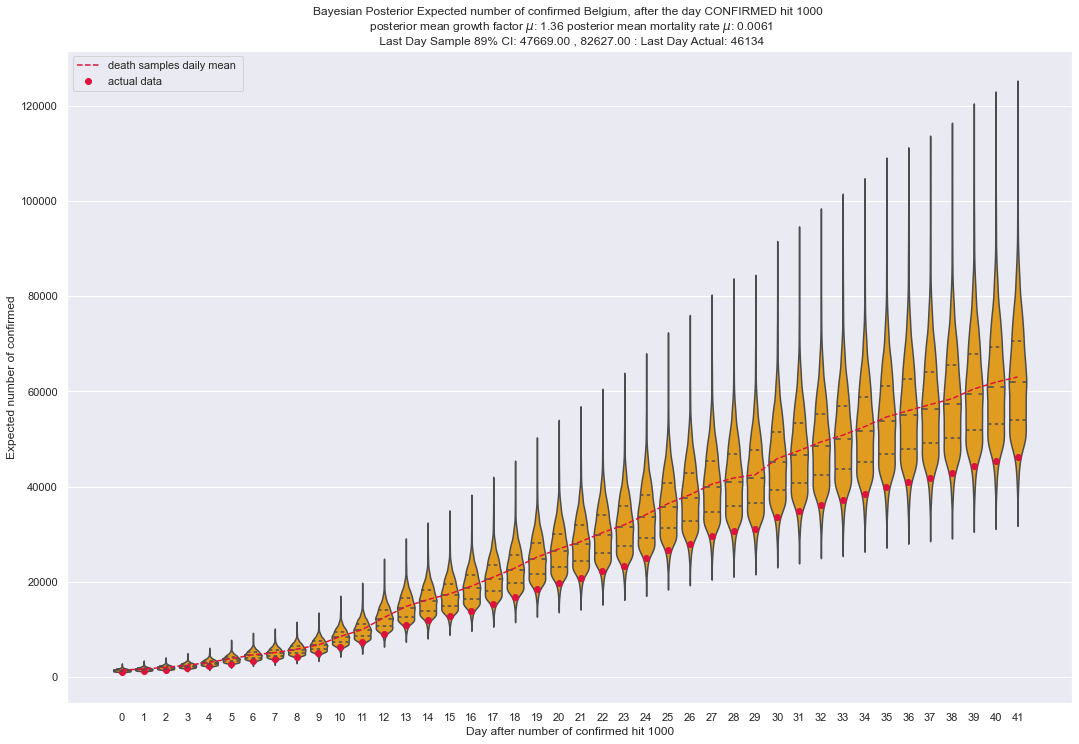

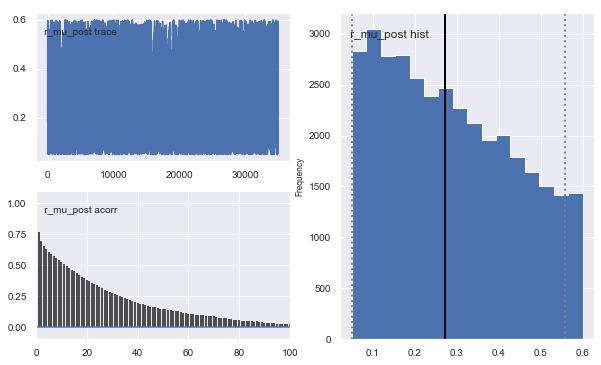

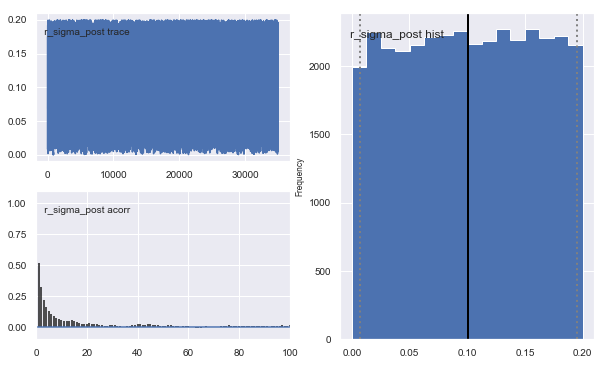

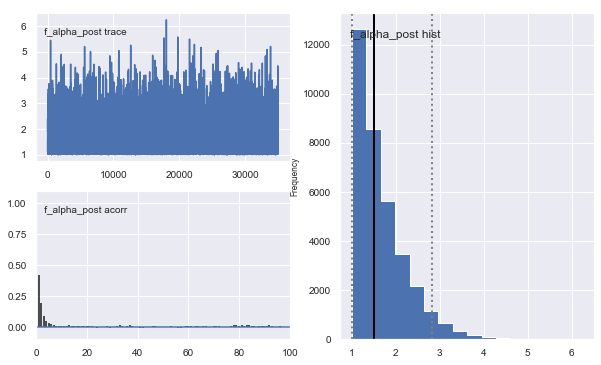

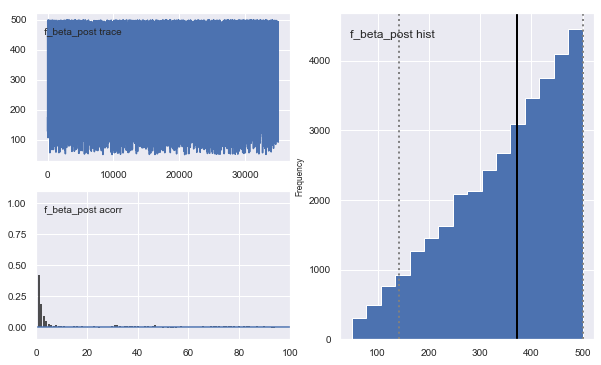

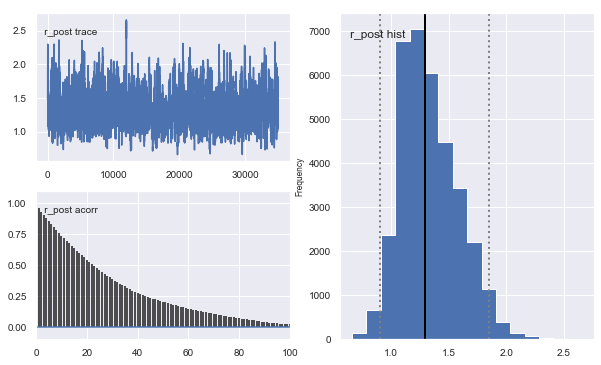

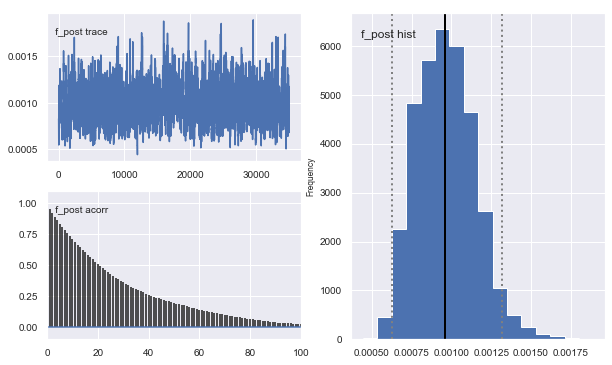

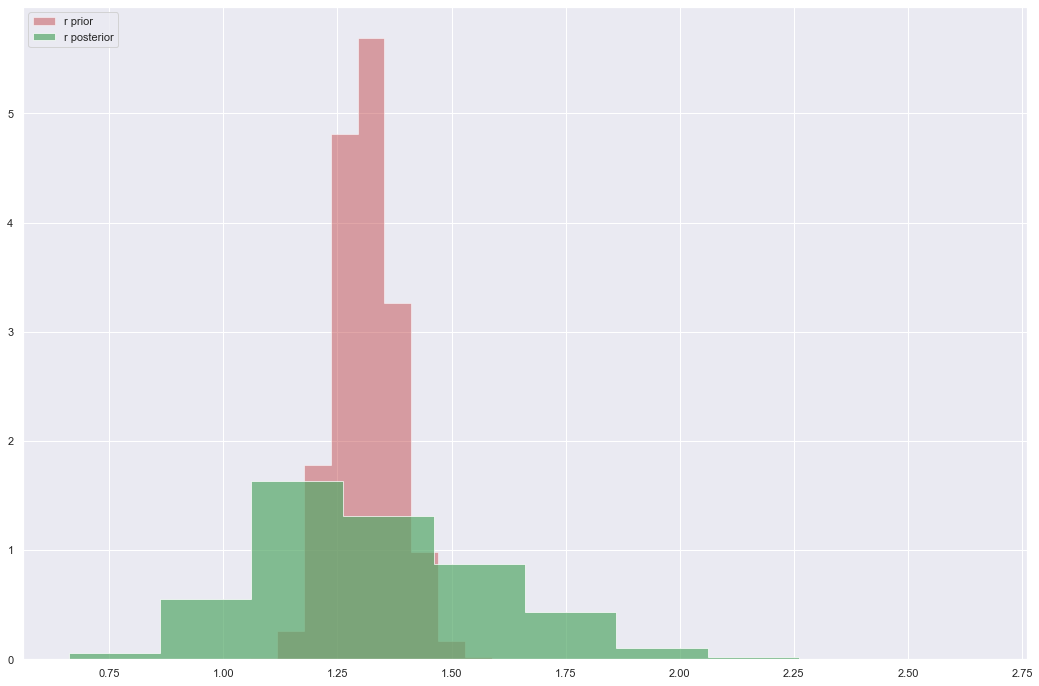

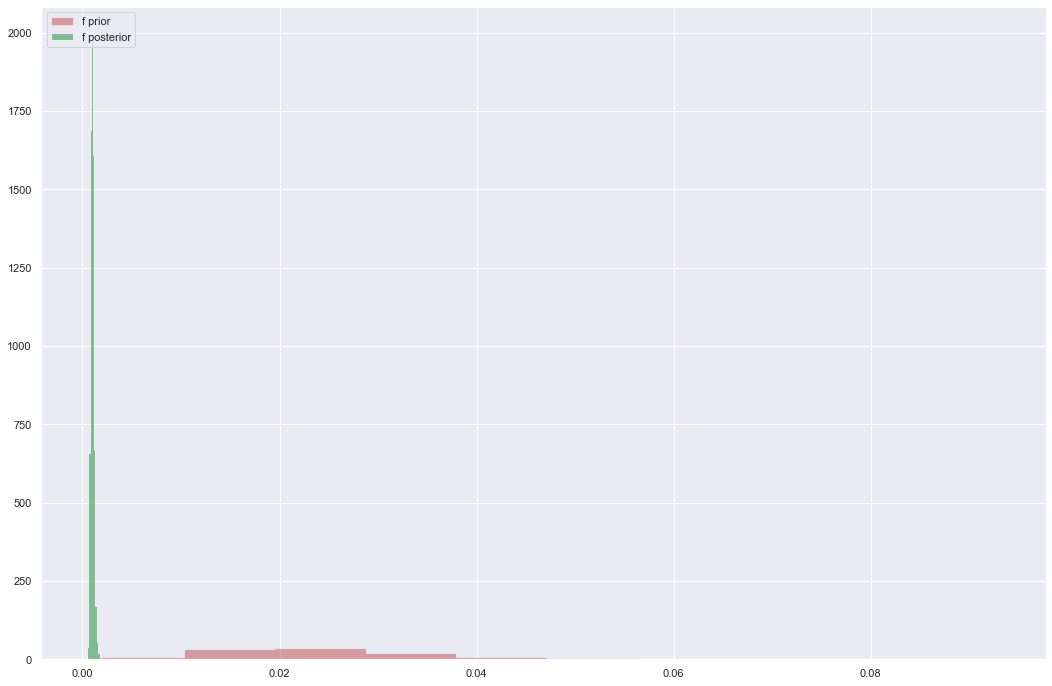

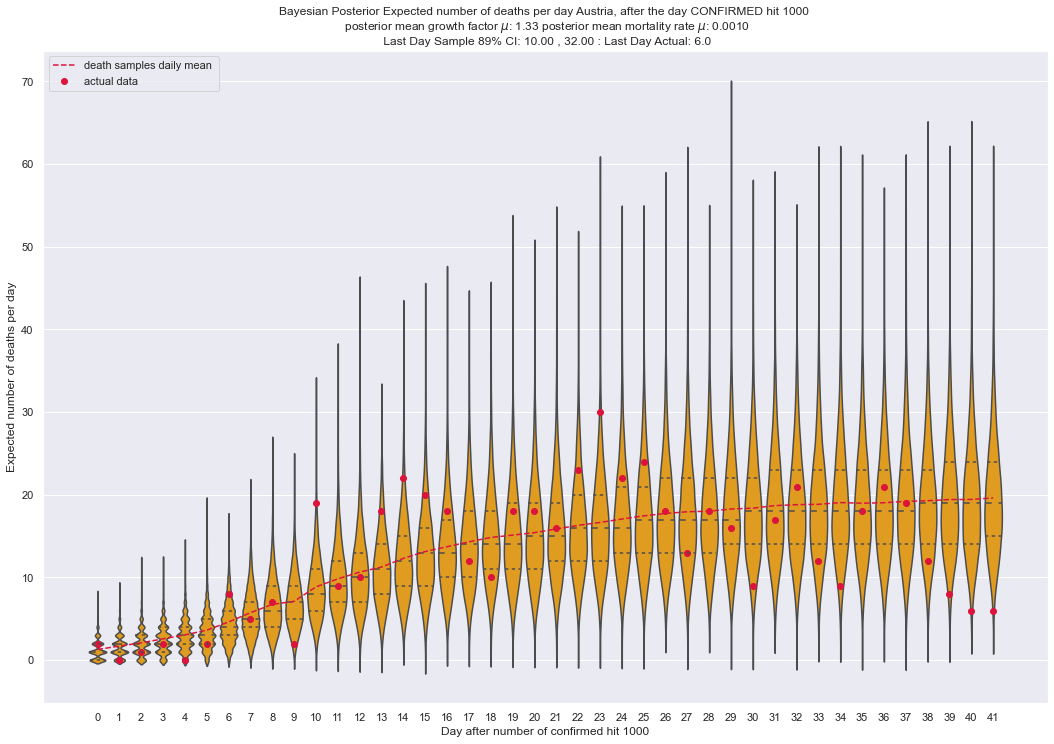

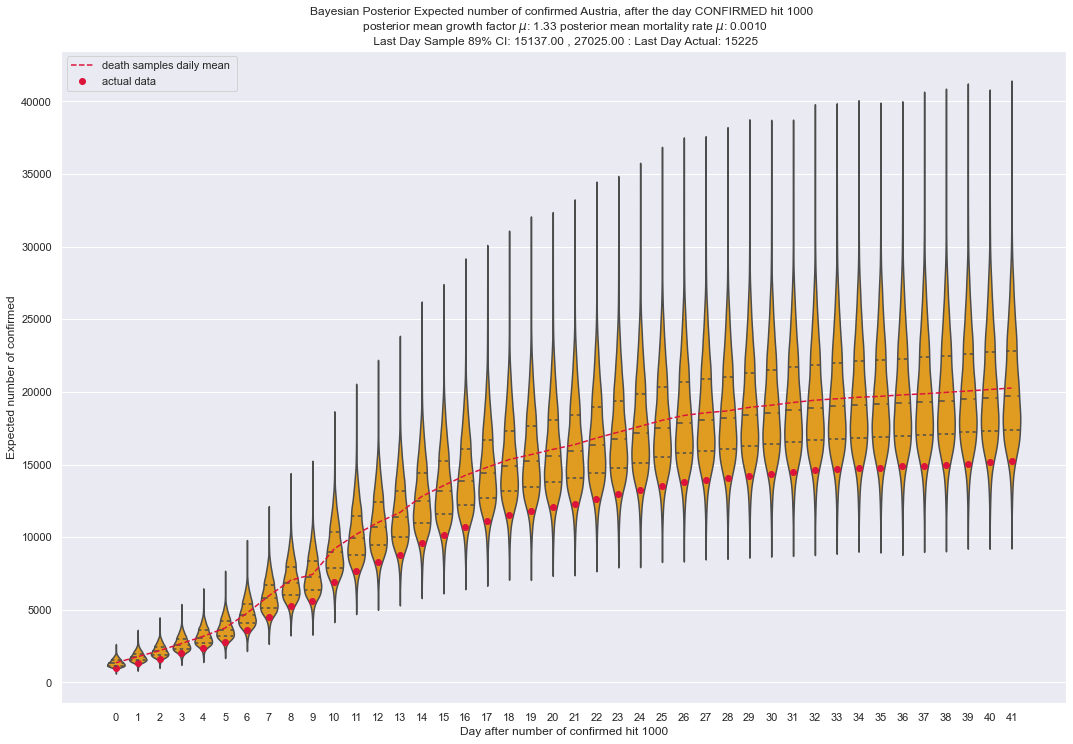

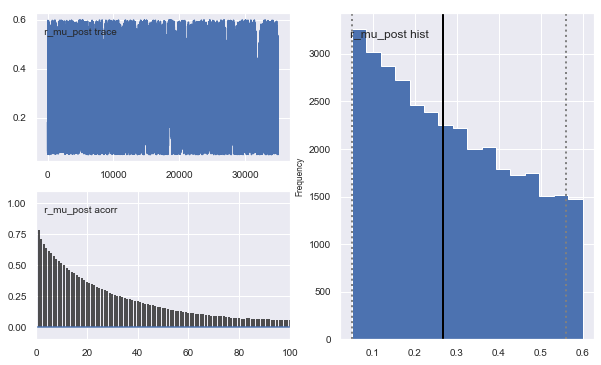

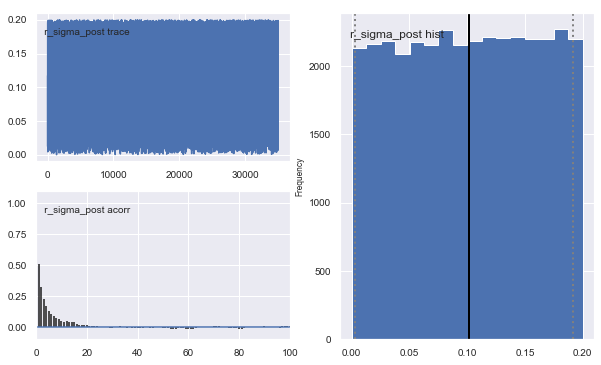

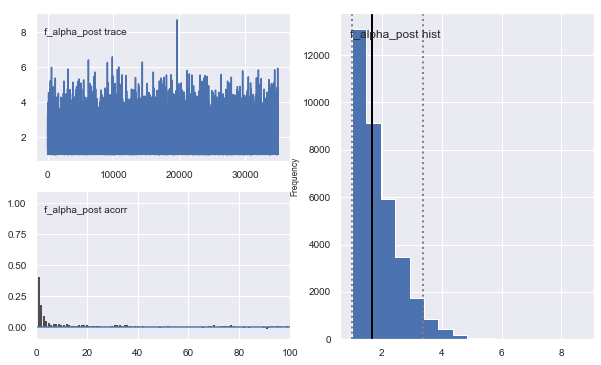

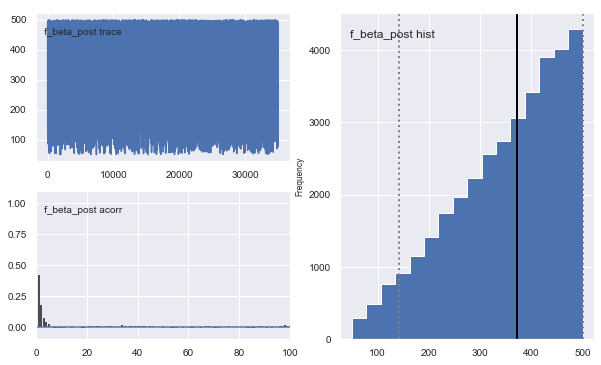

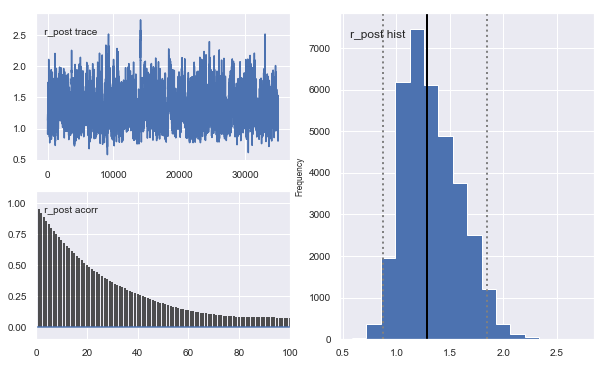

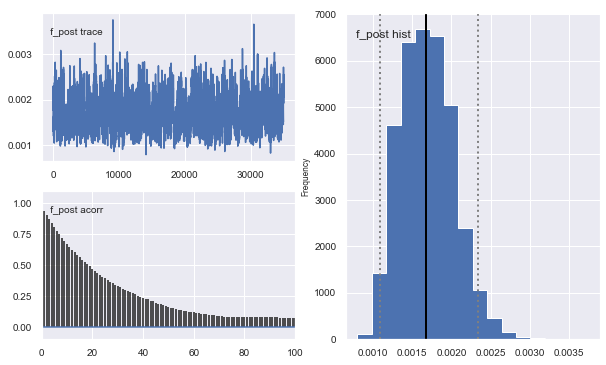

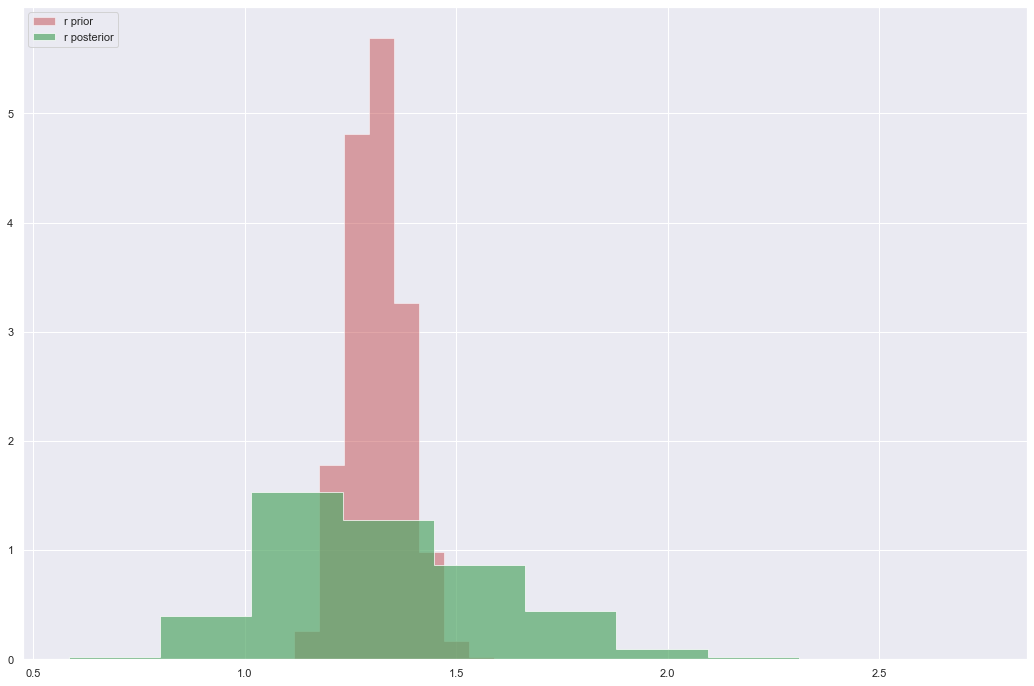

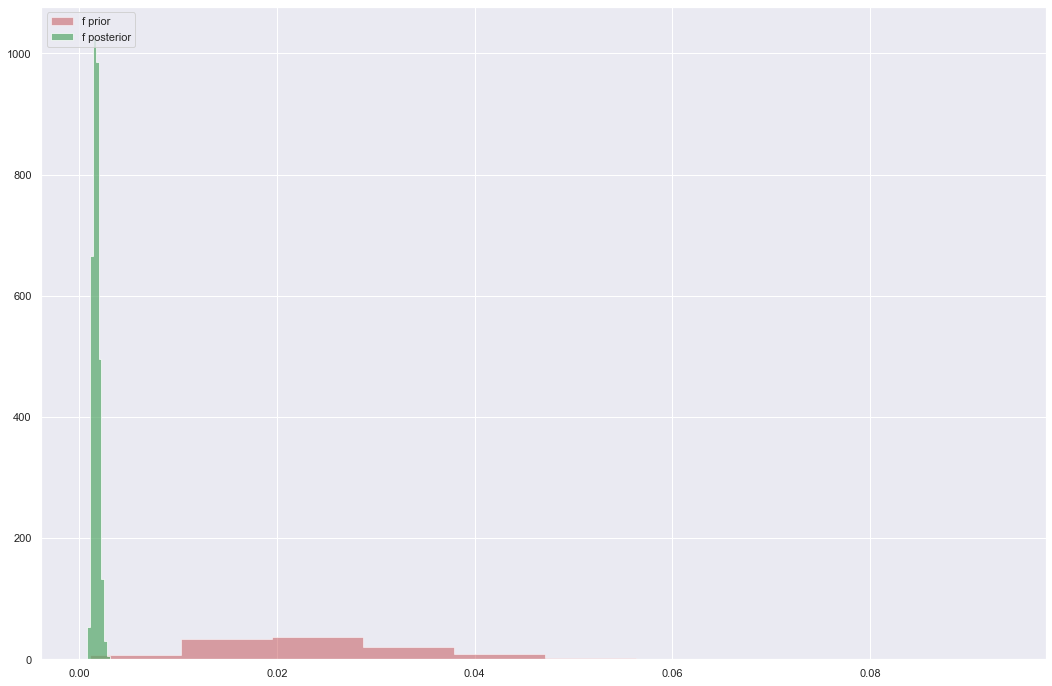

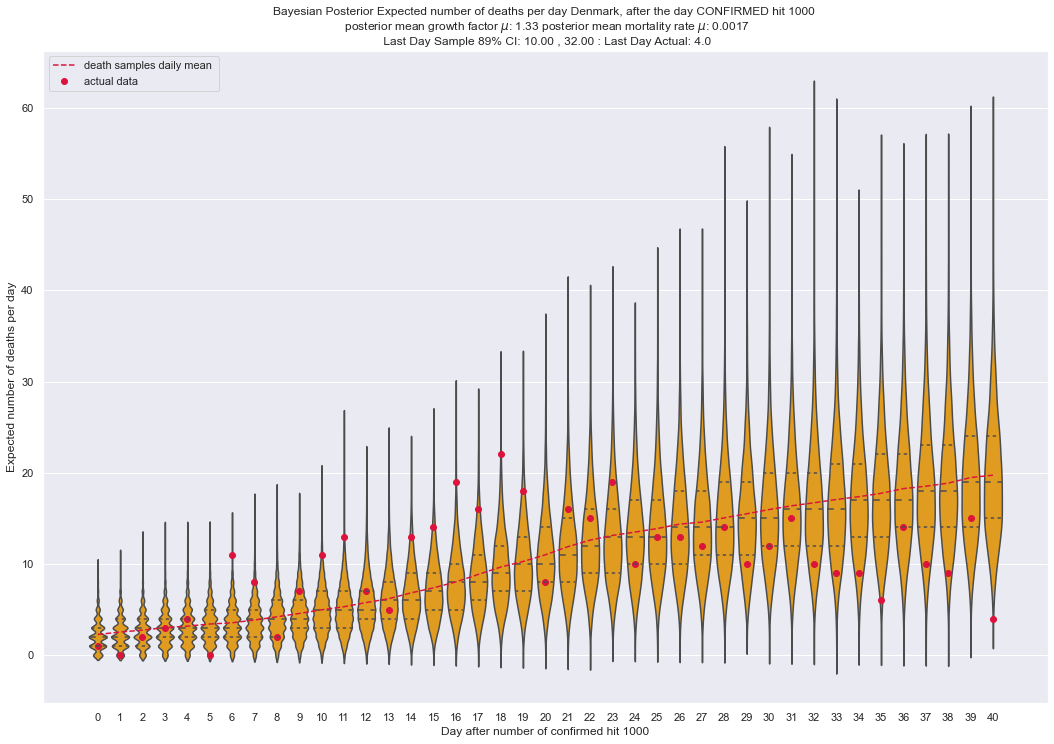

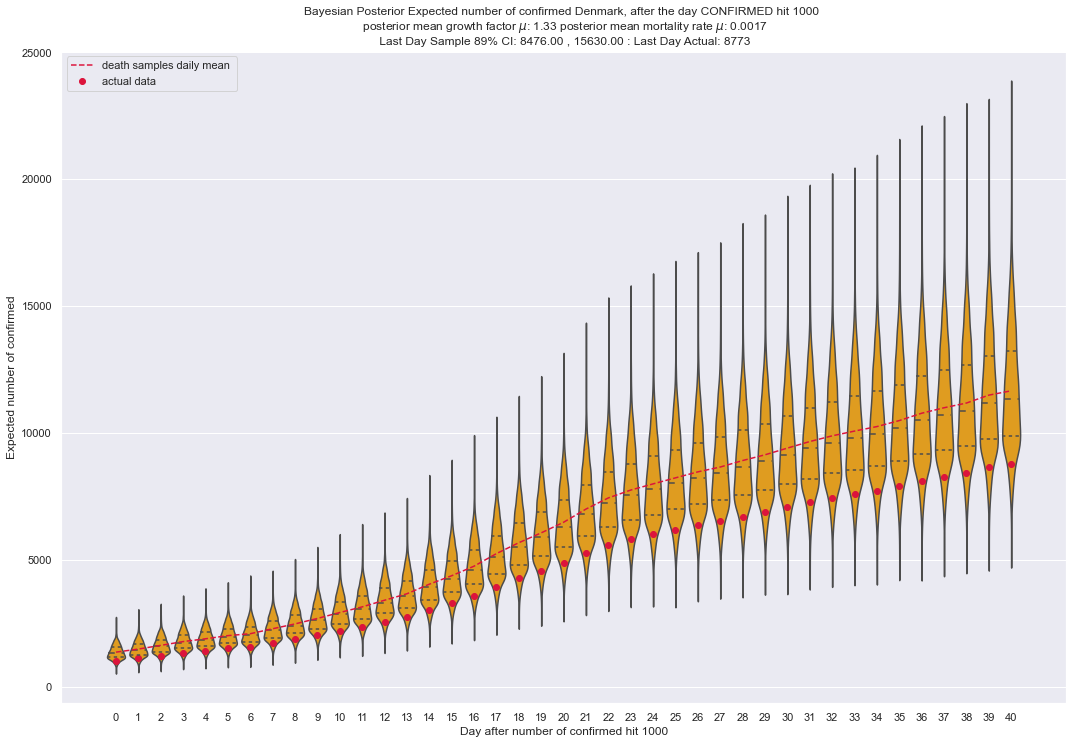

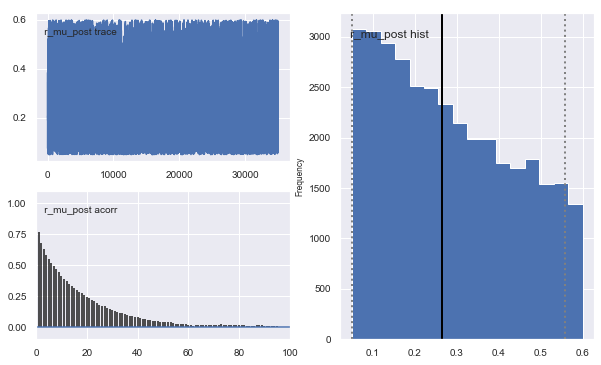

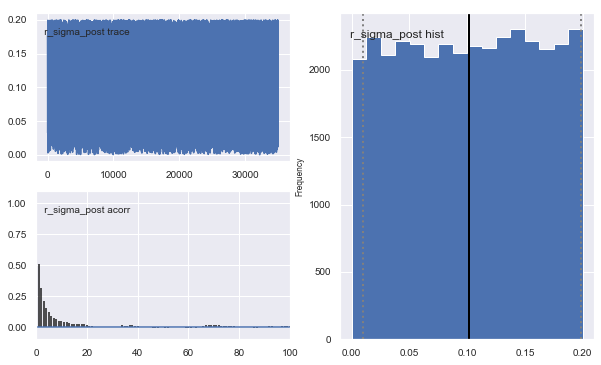

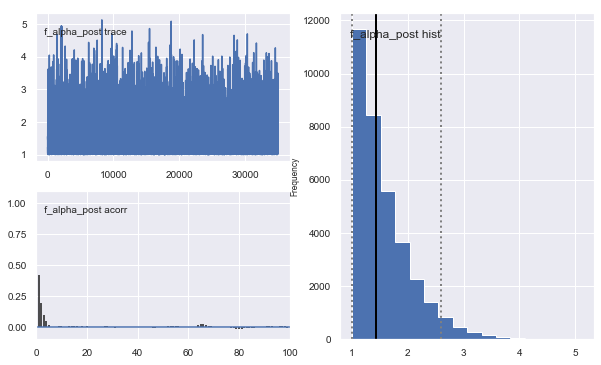

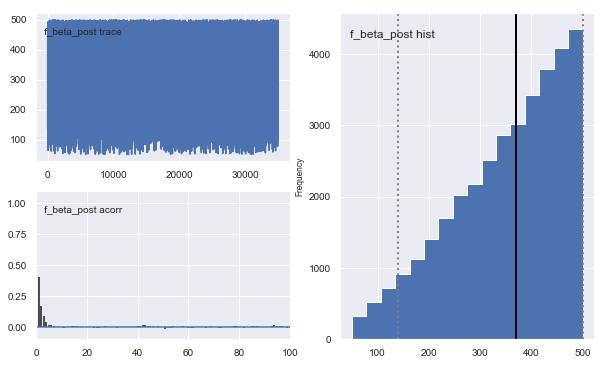

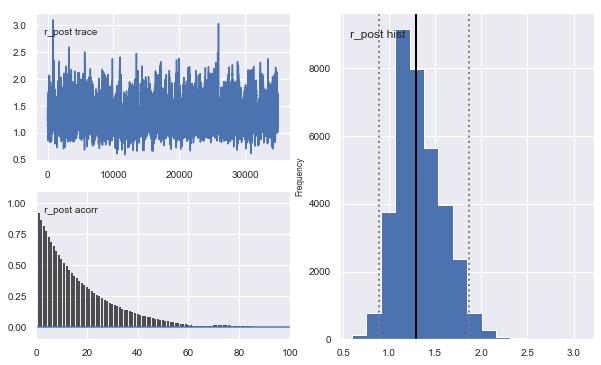

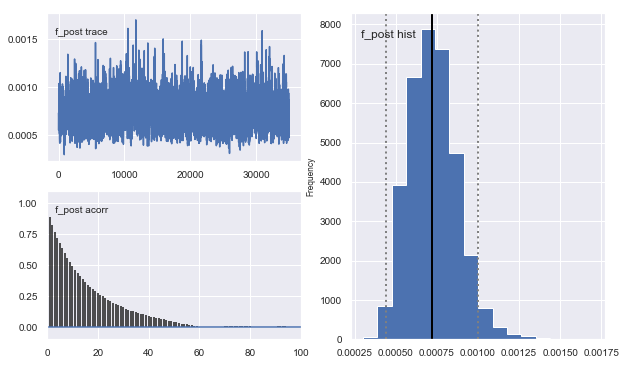

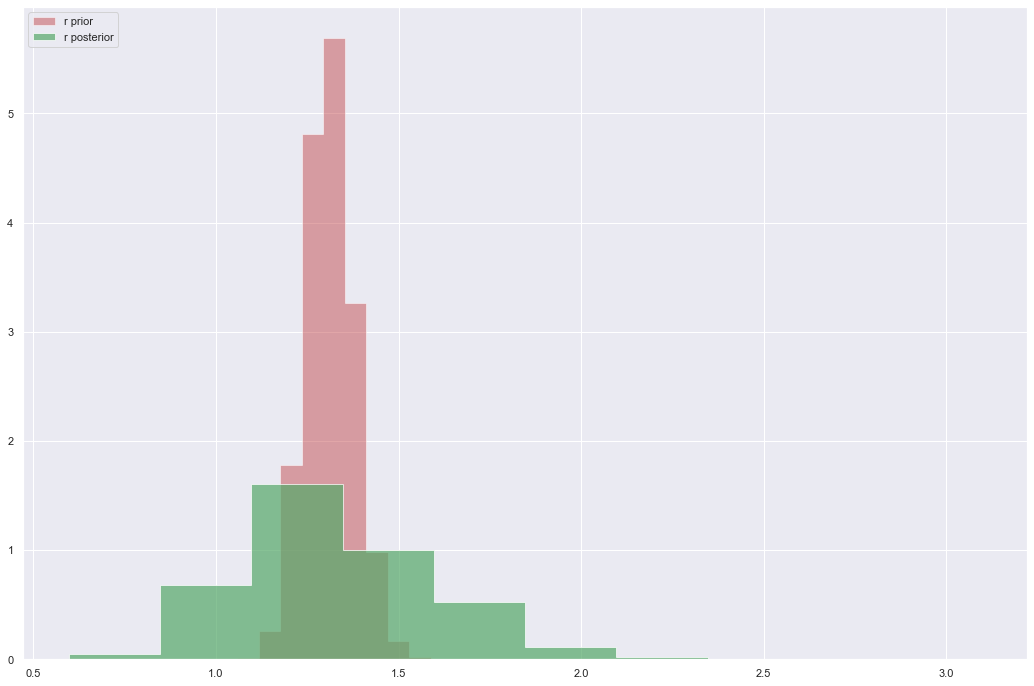

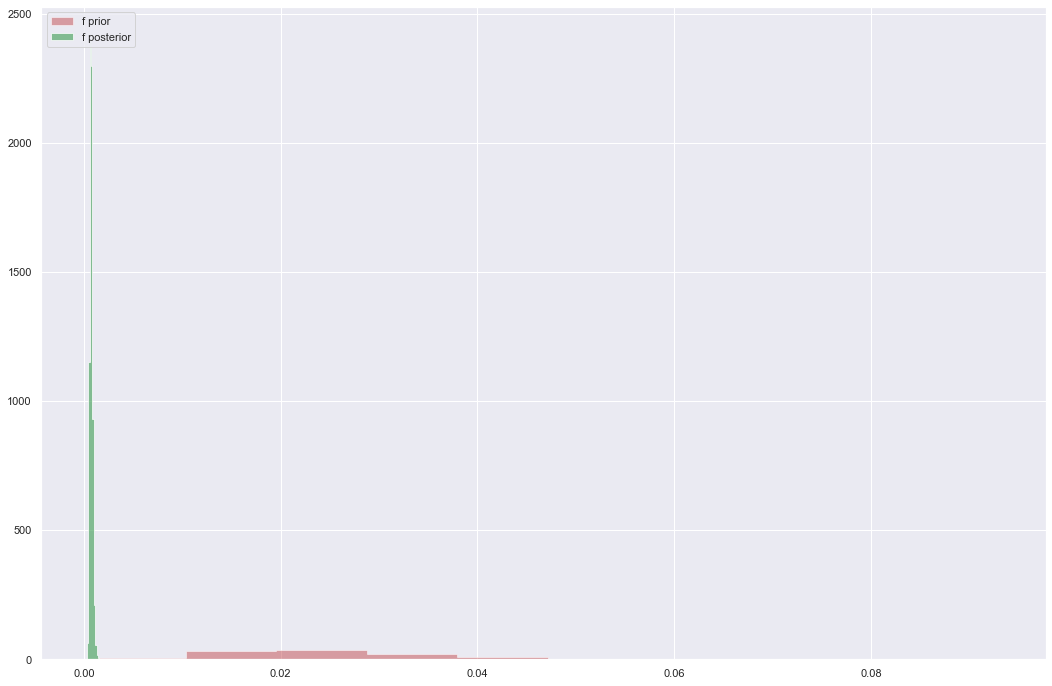

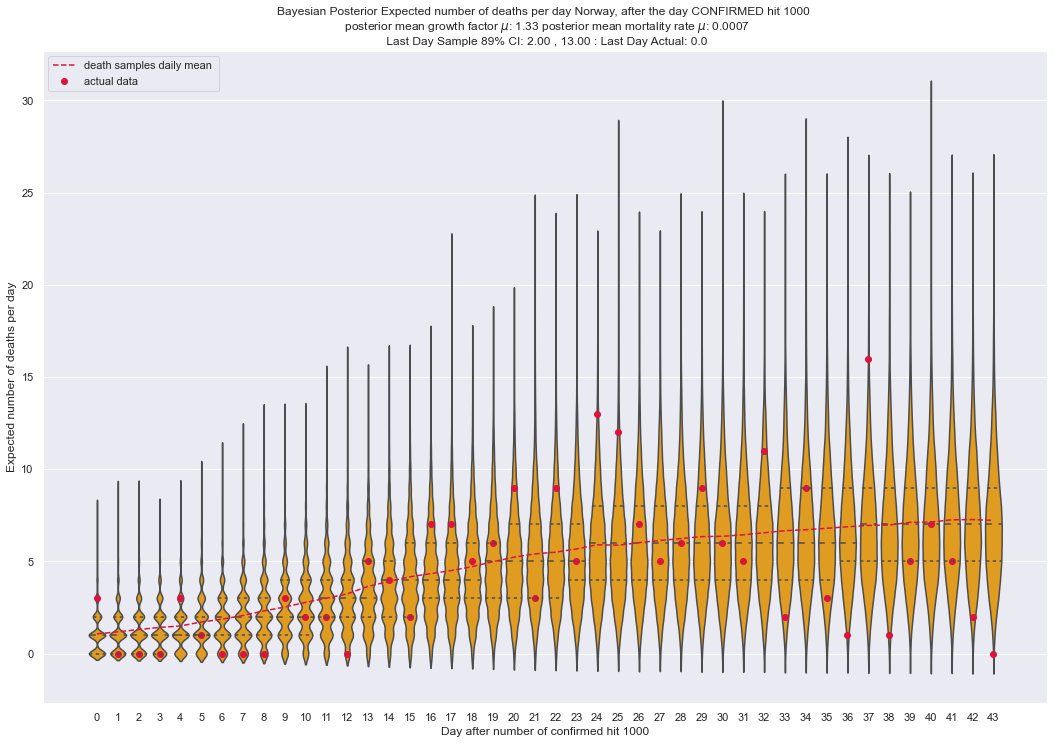

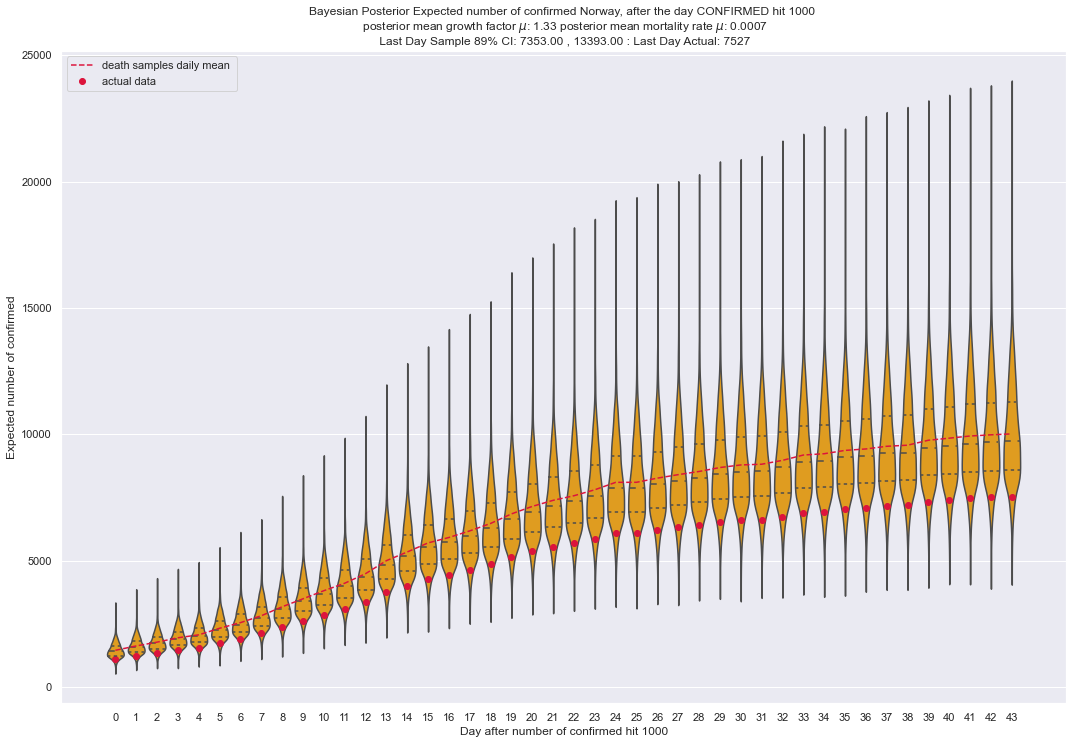

In [48]:
countries = ['Sweden','Italy','Spain','US','United Kingdom',
             'Korea, South','Netherlands','Canada','Germany',
             'France','Belgium','Austria',
            'Denmark','Norway','Finland','Australia','Portugal','india']

#countries = ['United Kingdom','France','Austria','Turkey']
#countries = ['Netherlands','Belgium','France','Austria','United Kingdom']
#countries = ['Sweden']

for country_name in countries:
    
    df = process_country(country_name)

    limit = 1000
    mask = df['confirmed'] >= limit
    df = df[mask]

    #df = df[-10:]

    print ()
    print ('++++++++++++++++++++++ {} +++++++++++++++++++++++'.format(country_name))
    print (df.tail())

    D = df['dead_inc']
    C = df['confirmed']
    
    result = inference(df,C,D,country_name)
    sample_df,conf_sample_df = create_posterior_samples(result)
    
    print ('sample_df()')
    print (sample_df.tail(40))
    print ('daily death mean samples')
    print (sample_df.mean(axis=1).tail(40))
    print ('Last day summary stats')
    sample_df.iloc[-1].describe()
    
    print ('conf sample_df.tail(40)')
    print (conf_sample_df.tail(40))
    print ('conf sample daily mean')
    print (conf_sample_df.mean(axis=1))
    
    plot(result,df,sample_df,country_name)
    plot(result,df,conf_sample_df,country_name,'confirmed','confirmed')
    result.to_pickle('violin_daily_result_{}.pkl'.format(country_name.replace(' ','_')))

In [ ]:
#plot(result,df,sample_df,country_name)


In [ ]:
US = pd.read_pickle('us_state_dict.pkl')

In [ ]:
ny = US['New York']
ny = ny[['confirmed','deceased','recovered','inc','factor','dead_inc','dead_factor']]
ny

In [ ]:
print (ny)

D = ny['dead_inc']
C = ny['confirmed']

country_name='New York'
result = inference(ny,C,D,'New York')
result.to_pickle('violin_daily_result_{}.pkl'.format(country_name.replace(' ','_')))
sample_df,conf_sample_df = create_posterior_samples(result)
plot(result,ny,sample_df,'New York')
plot(result,ny,conf_sample_df,'New York','confirmed','confirmed')